<a href="https://colab.research.google.com/github/dyarparvar/Student-Dropout-Prediction/blob/main/GitHub_Yarparvar_Darya_CAM_C201_Week_6_Mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-project: Applying supervised learning to predict student dropout

In this project, we will examine student data and use supervised learning techniques to predict whether a student will drop out. In the education sector, retaining students is vital for the institution's financial stability and for students’ academic success and personal development. A high dropout rate can lead to significant revenue loss, diminished institutional reputation, and lower overall student satisfaction.


## Business context
********** specialises in providing educational services and resources to students and professionals across various fields. The company's primary focus is on enhancing learning experiences through a range of services, including online courses, tutoring, and educational consulting. By leveraging cutting-edge technology and a team of experienced educators, ********** aims to bridge the gap between traditional learning methods and the evolving needs of today's learners.


Through its comprehensive suite of services, it supports learners and universities at every stage of their educational journey, from high school to postgraduate studies. Its approach is tailored to meet the unique needs of each learner, offering personalised learning paths and flexible scheduling options to accommodate various learning styles and commitments.

**********'s services are designed to be accessible and affordable, making quality education a reality for many individuals. By focusing on the integration of technology and personalised learning, the company aims to empower learners to achieve their full potential and succeed in their academic and professional pursuits. ********** is at the forefront of transforming how people learn and grow through its dedication to innovation and excellence.

********** has provided you with 3 data sets.

1.  Applicant and course information
2.  Student and engagement data
3.  Academic performance data

These stages reflect **********’s real-world data journey and how student information has progressed and become available. Additionally, this approach enables you, through data exploration, to support ********** in better understanding and identifying key metrics to monitor. This approach will also assist you in determining at which stage of the student journey interventions would be most effective.



## Objective
By the end of this mini-project, you will have developed the skills and knowledge to apply advanced machine learning techniques to create a predictive model for student dropout. This project will involve comprehensive data exploration, preprocessing, and feature engineering to ensure high-quality input for the models. You will employ and compare multiple predictive algorithms, such as XGBoost, and a neural network-based model, to determine the most effective model for predicting student dropout.

In the Notebook, you will:
- explore the data sets, taking a phased approach
- preprocess the data and conduct feature engineering
- predict the dropout rate using XGBoost, and a neural network-based model.

You will also write a report summarising the results of your findings and recommendations.

## Assessment criteria
By completing this project, you’ll be able to provide evidence that you can:

- develop accurate predictions across diverse organisational scenarios by building and testing advanced ML models
- inform data-driven decision-making with advanced machine learning algorithms and models
- propose and present effective solutions to organisational problems using data preprocessing, model selection, and insightful analysis techniques.





# 📌 Setup
Setting up the notebook environment:
- installing and/or importing the required libraries
- formatting, styles, and display options for the whole notebook
- discard warning messages from the output

In [ ]:
! pip install keras-tuner --upgrade
! pip install --upgrade xgboost

In [ ]:
# --- Libraries ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime

import random
import warnings

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import sklearn.metrics as metrics
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.initializers import GlorotUniform
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, F1Score, AUC
from keras.callbacks import EarlyStopping, ModelCheckpoint
from hyperopt import hp
import keras_tuner as kt

import shap
# Initialise the necessary JS environment for SHAP
shap.initjs()




# --- Preparation for saving the results further down the line ---
from google.colab import drive
import os
# Mount the drive
drive.mount('/content/drive')
# Define a consistent path in the Drive
parent_log_dir = '/content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3'

# Load the TensorBoard notebook extension
%load_ext tensorboard




# --- Display Options for Pandas ---
# Show all columns and rows in a DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Format floats to consistent decimal places
pd.set_option('display.float_format', lambda x: f'{x:.2f}')



# --- Print Options for NumPy ---
# Suppress the scientific notation and set a consistent number of digits
np.set_printoptions(suppress=True, precision=2)



# --- Styling for Matplotlib and Seaborn ---
# A clean, whitegrid style and a categorical Color Brewer palette
sns.set_theme(style="ticks", palette="Set2")
# sns.despine()

# Font size and styling for the notebook
sns.set_context("notebook", font_scale=0.8)



# --- Warnings ---
# Suppress warnings to keep the output clean
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Visualising the chosen palettes & swatches - for further reference

In [ ]:
palette_set2 = sns.color_palette("Set2")
palette_set2

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

# 📌 Configuration

A global configuration variable that keeps the parameters that define how the code should run:

In [ ]:
CONFIGURATION = {
    "randomness_strategy": {
        "seed": 42
    },

    "missing_value_strategy": {
        "missing_rate>0.5": "remove",
        "numeric": "median",
        "categorical": "NaN"
    },

    "encoding": {
        "method": "onehot",
        "handle_unknown": "ignore"
    },

    "scaling": {
        "method": "standard",
        "numeric_features": True,
        "derived_features": True
    },

    "feature_engineering": {
        "create_age": True,
        "create_subject_group": True,
        "create_degree_group": True,
        "create_pass_rate": True,
    },

    "outlier_handling": {
        "method": "retain",
    },

    "train_test_split": {
        "test_size": 0.2,
        "validation_size": 0.1,
        "stratify": True
    },

    "model_params": {

        "neural_network": {
            "api": "sequential",
            "layer": "dense",
            "n_neuron": [16, 16, 1],
            "hidden_activation": "relu",
            "output_activation": "sigmoid",
            "dropout_rate": 0.5,

            "optimizer": "adam",
            "learning_rate": 0.001,

            "loss": "binary_crossentropy",

            "metrics": [
                BinaryAccuracy(name="accuracy"),
                Precision(name="precision"),
                Recall(name="recall"),
                F1Score (name="f1_score"),
                AUC(name="roc_auc", curve="ROC"),
                AUC(name="pr_auc", curve="PR") # used as the tuner objective
            ],
            "decision_threshold": 0.5,

            "epochs": 50,
            "batch_size": 32,

            "early_stoppying_monitor": "val_loss",
            "patience": 5,

            "checkpoint_monitor": {
                "loss": ["val_loss", "min"],
                "accuracy": ["val_accuracy", "max"],
                "pr_auc": ["val_pr_auc", "max"],
              },

            "tuner_objective": kt.Objective("val_pr_auc", direction="max"),
        },


        "xgboost": {
            "objective": "binary:logistic",
            "enable_categorical": True,
            "max_depth": 5,
            "learning_rate": 0.1,
            "n_estimators": 100,
            "eval_metric": ["logloss", "aucpr", "auc"],

            "scoring": {
                "accuracy": "accuracy",
                "precision": "precision",
                "recall": "recall",
                "f1": "f1",
                "roc_auc": "roc_auc",
                "pr_auc": "average_precision"
            },
            "decision_threshold": 0.5,

            "cross_validation": "custom_split",
            "refit": "pr_auc"
        }
    }
}

In [ ]:
config = dict(CONFIGURATION)

# 📌 Helper Functions

## Reproducibility

Function to establish reproducibility by fixing the seed

In [ ]:
def set_seed(seed=42):
    # Python randomness
    random.seed(seed)
    # Python hash randomness
    os.environ["PYTHONHASHSEED"] = str(seed)

    # NumPy randomness
    np.random.seed(seed)

    # TensorFlow randomness
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()

## Cleaning & EDA

Helper funcitons to decrease cardinality and/or standardise

In [ ]:
# Helper function to classify subject matters into 4 core groups + other
def subject_classifier(name):
    if pd.notnull(name):  # handle NaN
        name = name.lower()
        if any(x in name for x in ["business", "management", "finance", "economics", "accounting"]):
            return "business"
        elif any(x in name for x in ["engineering", "computing", "science", "technology", "mathematics", "physical"]):
            return "engineering_science"
        elif any(x in name for x in ["life", "health", "medical", "biological"]):
            return "life_science"
        elif any(x in name for x in ["law", "social", "humanities", "arts", "media"]):
            return "social_humanities"
        else:
            return "other"
    else:
      return np.nan

In [ ]:
# Helper function to classify degrees into core groups
def degree_classifier(degree):
    if pd.notnull(degree):  # handle NaN
        degree = degree.lower()
        if any(x in degree for x in ["bsc", "ba", "beng", "llb", "bbl", "bcl", "be", "bmus", "mbchb", "bds", "bsocsc", "bcomm", "mbbch", "bmedsci"]):
            return "bachelor"
        elif any(x in degree for x in ["ma", "msc", "meng", "llm", "mcomp", "mchem", "mchd", "mbiol", "mpsyc", "mbiomed", "mds", "mph", "mlit"]):
            return "masters"
        elif "phd" in degree:
            return "PhD"
        else:
            return "unknown"
    else:
      return np.nan

In [ ]:
# Helper function to standardise University names
def uni_standardiser(uni):
    if pd.notnull(uni):  # handle NaN
        uni = uni.lower()
        if any(x in uni for x in ["holland isc", "vu amsterdam", "erasmus rotterdam", "hanze uas", "tilburg"]):
            return "holland isc"
        elif any(x in uni for x in ["strathclyde"]):
            return "university of strathclyde"
        else:
            return uni
    else:
      return np.nan

Function to prepare data for EDA

In [ ]:
def eda_prep(data, config,
            stage=3,
            rename_dict=None,
            irr_cols=None,
            missing_cols=None,
            high_card_cols=None,
            del_cols=None):


    # Deduplication (before splitting X and y)
    data = data.drop_duplicates()
    data.shape


    # Define the sequence of steps
    preprocessing_steps = [
        ("cleaner", DataPreprocesser(
            stage=stage,
            rename_dict=rename_dict,
            irr_cols=irr_cols,
            missing_cols=missing_cols,
            high_card_cols=high_card_cols,
            del_cols=del_cols
        ))
    ]


    # Create the pipeline
    preprocessing_pipeline = Pipeline(steps=preprocessing_steps)


    # Fit and transform the data
    data_processed = preprocessing_pipeline.fit_transform(data)



    return {
        'eda_data': data_processed,
        'eda_pipeline': preprocessing_pipeline
    }

## Pre-processing Pipeline

Required classes and functions have been created to encapsulate all data cleaning, feature engineering, and transformation steps into and pipelines and reusable components, ensuring consistency and preventing data leakage.

<br>

For **Neural Network** modelling:

The neural network requires fully numeric, scaled data, so the pipeline includes scaling and one-hot encoding after feature engineering.

- Initial Split: The data is deduplicated, and split into features (X) and target (y), and then X and y are stratified into train, validation, and test sets.

- Imputation (only for Stage 2 and 3): Median Imputation is fitted only on the training set to fill missing values in newly added features, preventing data leakage.

- Cleaning (DataPreprocesser): Cleans the data and performs feature engineering.

- Ordinal Encoding (OrdinalEncoder): Maps ordinal features to numeric integer values.

- Scaling and One-hot Encoding (ColumnTransformer): StandardScaler standardises numeric features, and OneHotEncoder converts nominal features to binary columns.

- The entire preprocessing pipeline is fitted on the training data and then transformed on all three datasets (train, validation, test).

<br>

For **XGBoost** modelling:

All the steps are similar to data preparation for the neural network modelling, except the following:
 - The "object" data type should be converted to "category"
- XGBoost can handle missing values and does not requires fully numeric, scaled data, so the pipeline does not include scaling and one-hot encoding.

Custom transformer for cleaning the data and creating new features

In [ ]:
# Define a custom transformer for cleaning the data
class DataPreprocesser(BaseEstimator, TransformerMixin):
    def __init__(self, stage=1, rename_dict=None, irr_cols=None, missing_cols=None, high_card_cols=None, del_cols=None):
        self.stage = stage
        self.rename_dict = rename_dict
        self.irr_cols = irr_cols
        self.missing_cols = missing_cols
        self.high_card_cols = high_card_cols
        self.del_cols = del_cols
        self.drop_cols = []


    def get_feature_names_out(self, input_features=None):
        # After transformation, output columns are:
        output_cols = list(self.output_columns_) if hasattr(self, "output_columns_") else input_features
        return np.array(output_cols)


    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()  # Copy the input to avoid modifying the original

        # --- For all stages ---
        # Rename features
        X_transformed = X_transformed.rename(columns=self.rename_dict)

        # Feature engineering
        X_transformed["age"] = pd.to_datetime("today").year - pd.to_datetime(X_transformed["dob"], dayfirst=True).dt.year
        X_transformed["first_intake"] = X_transformed["first_intake"].replace({True: "yes", False: "no"}).astype("category")
        X_transformed["subject_group"] = X_transformed["course_name"].apply(subject_classifier).astype("category")
        X_transformed["degree_group"] = X_transformed["degree"].apply(degree_classifier).astype("category")
        X_transformed["uni"] = X_transformed["uni"].apply(uni_standardiser).astype("category")


        # --- For stage 3 ---
        if self.stage==3:
            # Create the pass rate feature
            X_transformed["pass_rate"] = X_transformed["passed"]/(X_transformed["assessed"])


        # Combine all columns to drop
        self.drop_cols = self.irr_cols + self.missing_cols + self.high_card_cols + self.del_cols

        # Drop unneccesary features
        X_transformed = X_transformed.drop(columns=self.drop_cols, axis=1)

        self.output_columns_ = X_transformed.columns

        return X_transformed


Custom transformer for encoding the ordinal data

In [ ]:
# Define a custom transformer for encoding the ordinal data
class OrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal_map=None):
        self.ordinal_map = ordinal_map

    def get_feature_names_out(self, input_features=None):
        # After transformation, output columns are:
        output_cols = list(self.output_columns_) if hasattr(self, "output_columns_") else input_features
        return np.array(output_cols)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col, ordinal_map in self.ordinal_map.items():
            if col in X_transformed.columns:
                X_transformed[col] = X_transformed[col].map(ordinal_map)

        self.output_columns_ = X_transformed.columns

        return X_transformed

Function to pre-process and prepare data for modelling:

In [ ]:
def pre_modelling_prep(data,
                       config,
                       stage=1,
                       rename_dict=None,
                       irr_cols=None,
                       missing_cols=None,
                       high_card_cols=None,
                       ordinal_map=None,
                       numeric_features=None,
                       nominal_features=None,
                       added_cols=None,
                       del_cols=None,
                       modelling=None):


    # Deduplication (before splitting X and y)
    data = data.drop_duplicates()
    data.shape


    # Split the data into y (target variable) and X (input variable)
    y = (data[target_col] == "No").astype(int)
    y = y.rename("dropout")

    X = data.drop(target_col, axis=1)

    # Split the data into train, validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y,
        test_size=config["train_test_split"]["test_size"],
        random_state=config["randomness_strategy"]["seed"],
        stratify=y
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=config["train_test_split"]["validation_size"],
        random_state=config["randomness_strategy"]["seed"],
        stratify=y_train_val
    )

    # Create ColumnTransformer for scaling the numeric and the ordinal features & encoding the nominal features
    scaler_encoder = ColumnTransformer(
        transformers=[
            ("scaler", StandardScaler(), numeric_features),
            ("one_hot_enc", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), nominal_features)

        ],
        remainder="passthrough"
    )

    if modelling == "neural_network":
        # The imputation of missing values in the newly added columns should be done
        # after splitting X into training, validation and test sets to avoid data leakage.
        if stage>=2:
            # Create ColumnTransformer for imputing missing values
            median_imputer = ColumnTransformer(
                transformers=[
                    ("imputer", SimpleImputer(strategy="median"), added_cols)
                ],
                remainder="passthrough"
            )
            # Transformations are fitted only on the training data
            # and then applied to the validation and test sets to avoid data leakage
            X_train[added_cols] = median_imputer.fit_transform(X_train[added_cols])
            X_val[added_cols] = median_imputer.transform(X_val[added_cols])
            X_test[added_cols] = median_imputer.transform(X_test[added_cols])

        # Define the sequence of steps
        preprocessing_steps = [
            ("cleaner", DataPreprocesser(
                stage=stage,
                rename_dict=rename_dict,
                irr_cols=irr_cols,
                missing_cols=missing_cols,
                high_card_cols=high_card_cols,
                del_cols=del_cols
            )),
            ("ordinal_encoder", OrdinalEncoder(
                ordinal_map=ordinal_map
            )),
            ("scaler_encoder", scaler_encoder)
        ]


    elif modelling == "xgboost":
        # Convert "object" to "category", the proper dtype for XGBoost
        obj_cols = X.select_dtypes(include="object").columns
        X_train[obj_cols] = X_train[obj_cols].astype("category")
        X_val[obj_cols] = X_val[obj_cols].astype("category")
        X_test[obj_cols] = X_test[obj_cols].astype("category")

        # Define the sequence of steps
        preprocessing_steps = [
            ("cleaner", DataPreprocesser(
                stage=stage,
                rename_dict=rename_dict,
                irr_cols=irr_cols,
                missing_cols=missing_cols,
                high_card_cols=high_card_cols,
                del_cols=del_cols
            )),
            ("ordinal_encoder", OrdinalEncoder(
                ordinal_map=ordinal_map
            ))
        ]


    # Create the pipeline
    preprocessing_pipeline = Pipeline(steps=preprocessing_steps)


    # Fit and transform the data
    # Transformations are fitted only on the training data
    # and then applied to the validation and test sets to avoid data leakage
    X_train_processed = preprocessing_pipeline.fit_transform(X_train)
    X_val_processed = preprocessing_pipeline.transform(X_val)
    X_test_processed = preprocessing_pipeline.transform(X_test)



    return {
        "X_train": X_train_processed,
        "X_val": X_val_processed,
        "X_test": X_test_processed,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test,
        "pipeline": preprocessing_pipeline
    }

## Neural Network

###  Modelling and Evaluation

Funciton that creates the model architecture

In [ ]:
def create_nn_model(nn_config, X, seed):

    # Set kernel initializer with fixed seed
    initializer = GlorotUniform(seed)

    model = Sequential()

    input_shape = X.shape[1]

    # Add hidden layers
    for i, n in enumerate(nn_config["n_neuron"][:-1]):

        if i == 0:
            # First layer
            model.add(Dense(n,
                activation=nn_config["hidden_activation"],
                input_shape=(input_shape,),
                kernel_initializer=initializer
            ))
        else:
            # Hidden layers
            model.add(Dense(
                n,
                activation=nn_config["hidden_activation"],
                kernel_initializer=initializer
            ))

        # Add dropout after each hidden layer
        if nn_config["dropout_rate"] > 0:
            model.add(Dropout(nn_config["dropout_rate"]), seed)


    # Output layer
    model.add(Dense(
        nn_config["n_neuron"][-1],
        activation=nn_config["output_activation"],
        kernel_initializer=initializer
    ))

    # Instantiate optimizer
    if nn_config["optimizer"] == "adam":
        optimizer = Adam(learning_rate=nn_config["learning_rate"])
    elif nn_config["optimizer"] == "rmsprop":
        optimizer = RMSprop(learning_rate=nn_config["learning_rate"])

    # Compile model
    model.compile(loss=nn_config["loss"],
                  optimizer=optimizer,
                  metrics=nn_config["metrics"])

    return model

Funciton that trains and saves the model

In [ ]:
def train_nn_model(stage, seed, X_train, y_train, X_val, y_val, nn_config, parent_log_dir):

    tf.random.set_seed(seed)

    viz_dir = f"{parent_log_dir}/viz/stage_{stage}"
    # TensorBoard callback for monitoring the training and validation process
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=viz_dir, histogram_freq=1)



    # Early stopping callback
    early_stopping_callback = EarlyStopping(
        monitor=nn_config["early_stoppying_monitor"],
        patience=nn_config["patience"],
        restore_best_weights=True
    )

    checkpoint_dir = f"{parent_log_dir}/checkpoint/stage_{stage}"
    cp = nn_config["checkpoint_monitor"]
    # Save best model based on min loss
    checkpoint_loss_callback = ModelCheckpoint(
        filepath=f"{checkpoint_dir}/best_model_{cp["loss"][0]}.keras",
        monitor=cp["loss"][0],
        save_best_only=True,
        mode=cp["loss"][1],
        verbose=0
    )

    # Save best model based on max accuracy
    checkpoint_acc_callback = ModelCheckpoint(
        filepath=f"{checkpoint_dir}/best_model_{cp["accuracy"][0]}.keras",
        monitor=cp["accuracy"][0],
        save_best_only=True,
        mode=cp["accuracy"][1],
        verbose=0
    )

    # Save best model based on max pr-auc
    checkpoint_auc_callback = ModelCheckpoint(
        filepath=f"{checkpoint_dir}/best_model_{cp["pr_auc"][0]}.keras",
        monitor=cp["pr_auc"][0],
        save_best_only=True,
        mode=cp["pr_auc"][1],
        verbose=1
    )

    # Create the model
    model = create_nn_model(nn_config, X_train, seed)

    # Fit
    history = model.fit(
        X_train,
        y_train,
        epochs=nn_config["epochs"],
        batch_size=nn_config["batch_size"],
        validation_data=(X_val, y_val),
        verbose=0,
        callbacks=[
            tensorboard_callback,
            early_stopping_callback,
            checkpoint_loss_callback,
            checkpoint_acc_callback,
            checkpoint_auc_callback
        ]
    )

    return {
        "model": model,
        "history": history
    }


Funciton that evaluates the best model on the test set

In [ ]:
def evaluate_nn(stage, X_test, y_test, nn_config, nn_model, class_labels):

    # Use the same batch size for evaluation
    batch_size = nn_config["batch_size"]

    # Calculate the model's metrics (keras by default uses 0.5 threshold to convert probability to class and calculate the threshold-dependent metrics)
    loss, accuracy, precision, recall, f1, roc_auc, pr_auc = nn_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

    print(
        f"Keras metrics  \n"
        f"Stage : {stage} \n"
        f"Loss : {loss} \n"
        f"PR-AUC: {pr_auc} \n"
        f"ROC-AUC: {roc_auc} \n"
        f"Accuracy: {accuracy} \n"
        f"Precision: {precision} \n"
        f"Recall : {recall} \n"
        f"F1: {f1} \n"
    )


    # Calculate the model's predicted values (probability)
    y_pred_proba = nn_model.predict(X_test, batch_size=batch_size)

    # Calculate & print the threshold-independent metrics
    pr_auc_score = metrics.average_precision_score(y_test, y_pred_proba)
    roc_auc_score = metrics.roc_auc_score(y_test, y_pred_proba)

    print(
        f"Threshold-independent metrics  \n"
        f"Stage{stage}\n"
        f"pr-auc: {pr_auc_score} \n"
        f"roc-auc: {roc_auc_score} \n"
    )


    # Calculate the model's predicted values (based on the decision threshold)
    y_pred = (y_pred_proba > nn_config["decision_threshold"]).astype(int)

    # Calculate & print the threshold-dependent metrics
    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    precision_score = metrics.precision_score(y_test, y_pred)
    recall_score = metrics.recall_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)

    print(
        f"Threshold-dependent metrics (desision threshold: {nn_config["decision_threshold"]}) \n"
        f"Stage{stage}\n"
        f"accuracy: {accuracy_score} \n"
        f"precision: {precision_score} \n"
        f"recall: {recall_score} \n"
        f"f1: {f1_score} \n"
    )



    # Calculate the values for the confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])

    # Visualise the confusion matrix
    fig, ax = plt.subplots(figsize=(3, 3))
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.title(f"Stage {stage} - Neural Network")

    results = {
        "pr_auc": pr_auc_score,
        "roc_auc": roc_auc_score,
        "accuracy": accuracy_score,
        "precision": precision_score,
        "recall": recall_score,
        "f1": f1_score
    }

    return results



### Hyperparameter Tuning

Funcitons required for performing an exhaustive hyperparameter tuning of the neural network

In [ ]:
def build_wrapper(nn_config, X_train, seed):
  def model_builder(hp):

    # Tuning over the index of n_neuron hyperparameter
    n_neuron_indx = hp.Choice("n_neuron_indx", nn_param_grid["n_neuron_indx"])

    # Create the hyperparameter tuning config
    tuning_config = {
        # Use the index to access the n_neuron
        "n_neuron": nn_param_grid["n_neuron"][n_neuron_indx],

        # Use hp.Choice for the hyperparameters that will be tuned
        "hidden_activation": hp.Choice("hidden_activation", nn_param_grid["hidden_activation"]),

        # For the rest of the hyperparameters use the original config hyperparameters values
        "output_activation": nn_config["output_activation"],

        "optimizer": hp.Choice("optimizer", nn_param_grid["optimizer"]),
        "learning_rate": hp.Choice("learning_rate", nn_param_grid["learning_rate"]),

        "loss": nn_config["loss"],
        "metrics": nn_config["metrics"],

        "epochs": nn_config["epochs"],
        "batch_size": nn_config["batch_size"],
        "dropout_rate": nn_config["dropout_rate"],
        "patience": nn_config["patience"]
    }

    return create_nn_model(tuning_config, X_train, seed=seed)

  return model_builder

In [ ]:
def hp_tuner(stage, seed, build_wrapper, nn_config, X_train, y_train, X_val, y_val, directory, overwrite):
    # Set all the seeds
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
    os.environ["PYTHONHASHSEED"] = str(seed)


    # Use GridSearch & tune the model using all combinations of hyperparameter values
    tuner = kt.GridSearch(
      build_wrapper(nn_config, X_train, seed),
      objective=nn_config["tuner_objective"],
      executions_per_trial=1,
      directory=directory,
      project_name=f"nn_tuning_grid_{stage}",
      overwrite=overwrite
    )


    viz_dir = f"{directory}/viz/stage_{stage}"
    # TensorBoard callback for monitoring the training and validation process
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=viz_dir, histogram_freq=1)


    # Early stopping callback
    early_stopping_callback = EarlyStopping(
        monitor=nn_config["early_stoppying_monitor"],
        patience=nn_config["patience"],
        restore_best_weights=True
    )


    tuner.search(X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=nn_config["epochs"],
                batch_size=nn_config["batch_size"],
                verbose=0,
                callbacks=[
                    tensorboard_callback,
                    early_stopping_callback
                ]
    )

    return tuner

Funciton that provides the best hyperparameter combination

In [ ]:
def best_nn_hp(tuner, nn_param_grid, nn_config):
    # Retrieve the best model and hyperparameters values
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Retrieve the neuron index
    n_neuron_indx = best_hp.get("n_neuron_indx")
    best_neurons = nn_param_grid["n_neuron"][n_neuron_indx]

    print(
        f"Best hyperparameters:\n"
        f"Hidden activation: {best_hp.get("hidden_activation")}\n"
        f"Optimizer: {best_hp.get("optimizer")}\n"
        f"Learning rate: {best_hp.get("learning_rate")}\n"
        f"Number of neurons: {best_neurons}\n"
    )

    # Copy config
    best_nn_config = dict(nn_config)

    # Update with best hyperparameter values
    best_nn_config.update({
        "n_neuron": best_neurons,
        "hidden_activation": best_hp.get("hidden_activation"),
        "optimizer": best_hp.get("optimizer"),
        "learning_rate": best_hp.get("learning_rate")
    })

    return {
        # "best_nn_model": best_model,
        "best_nn_hp": best_hp,
        "best_nn_config": best_nn_config
    }

## XGBoost

### Modelling and Evaluation

Function for XGBoost model training

In [ ]:
def train_xgb_model(stage, seed, X_train, y_train, X_val, y_val, xgb_config):

    # Instantiate the classifier
    model = xgb.XGBClassifier(
        objective=xgb_config["objective"],
        enable_categorical=xgb_config["enable_categorical"],
        max_depth=xgb_config["max_depth"],
        learning_rate=xgb_config["learning_rate"],
        n_estimators=xgb_config["n_estimators"],
        eval_metric=xgb_config["eval_metric"],
        random_state=seed,
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    return model

Function for XGBoost model evaluation

In [ ]:
def evaluate_xgb(stage, X_test, y_test_proba, xgb_config, xgb_model, class_labels):

    # Calculate the model's predicted values (probability)
    y_pred_proba = xgb_model.predict(X_test)

    # Calculate & print the threshold-independent metrics
    pr_auc_score = metrics.average_precision_score(y_test_proba, y_pred_proba)
    roc_auc_score = metrics.roc_auc_score(y_test_proba, y_pred_proba)


    # Calculate the model's predicted values (based on the decision threshold)
    y_pred = (y_pred_proba > xgb_config["decision_threshold"]).astype(int)
    y_test = (y_test_proba > xgb_config["decision_threshold"]).astype(int)

    # Calculate & print the threshold-dependent metrics
    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    precision_score = metrics.precision_score(y_test, y_pred)
    recall_score = metrics.recall_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)

    print(
        f"Threshold-independent metrics  \n"
        f"Stage {stage}\n"
        f"pr-auc: {pr_auc_score} \n"
        f"roc-auc: {roc_auc_score} \n"
    )


    print(
        f"Threshold-dependent metrics (desision threshold: {xgb_config["decision_threshold"]}) \n"
        f"Stage {stage}\n"
        f"accuracy: {accuracy_score} \n"
        f"precision: {precision_score} \n"
        f"recall: {recall_score} \n"
        f"f1: {f1_score} \n"
    )


    # Calculate the values for the confusion matrix
    cm = metrics.confusion_matrix(y_test_proba, y_pred, labels=[0, 1])

    # Visualise the confusion matrix
    fig, ax = plt.subplots(figsize=(3, 3))
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.title(f"Stage {stage} - XGBoost")

    results = {
        "pr_auc_score": pr_auc_score,
        "roc_auc_score": roc_auc_score,
        "accuracy_score": accuracy_score,
        "precision_score": precision_score,
        "recall_score": recall_score,
        "f1_score": f1_score,
    }

    return results



Function to extract feature importance from an XGBoost model

In [ ]:
def feature_imp_xgb(stage, xgb_model):

    # Get the feature importance scores (based on "gain")
    booster = xgb_model.get_booster()
    importance_scores = booster.get_score(importance_type="gain")

    # Create a DataFrame
    importance_df = pd.DataFrame({
        "feature": list(importance_scores.keys()),
        "importance": list(importance_scores.values())
    }).sort_values("importance", ascending=False).reset_index(drop=True)

    # Calculate percentage importance
    total_importance = importance_df["importance"].sum()

    importance_df["percentage_imp"] = 100 * (importance_df["importance"] / total_importance)

    # Calculate cumulative importance
    importance_df["cumulative_imp"] = importance_df["percentage_imp"].cumsum()

    importance_df = importance_df.sort_values("importance", ascending=True).reset_index(drop=True)

    # Find the index where cumulative importance first exceeds 90%
    threshold_idx = importance_df[importance_df["cumulative_imp"] >= 90].index.max()

    # Visualise
    fig, ax = plt.subplots(figsize=(6, 5))
    plt.barh(
        data = importance_df,
        y=importance_df["feature"],
        width=importance_df["importance"]
    )

    # Line after the feature with cumulative importance of minimum 90%
    ax.axhline(
        y=threshold_idx - 0.5,
        color="r",
        linestyle="--",
        linewidth=2,
        label="90% Cumulative Importance"
    )
    ax.legend(loc="lower right")
    ax.set_title(f"Stage {stage} - XGBoost Feature Importance (Gain)")
    ax.set_ylabel("Feature")
    ax.set_xlabel("Importance Score (Gain)")
    plt.tight_layout()
    plt.show()

    return importance_df



### Hyperparameter Tuning

Function to perform an exhaustive hyperparameter tuning and to get the best hyperparameters and the best XGBoost model

In [ ]:
def best_xgb_model(stage, seed, X_train, y_train, X_val, y_val, nominal_features, xgb_param_grid, xgb_config):

    # Concatenate training and validation sets
    X_full = pd.concat([X_train, X_val], axis=0, ignore_index=True)
    y_full = pd.concat([y_train, y_val], axis=0, ignore_index=True)

    # Convert the dtype from "object" to "category"
    X_full[nominal_features] = X_full[nominal_features].astype("category")

    # Predefined split of train and validation sets (to have the same inputs as Neural Network)
    split_index = np.array([-1]*len(X_train) + [0]*len(X_val))
    custom_split = PredefinedSplit(test_fold=split_index)


    # Instantiate the classifier
    model = xgb.XGBClassifier(
        objective=xgb_config["objective"],
        enable_categorical=xgb_config["enable_categorical"],
        random_state=seed
    )

    # Instantiate the GridSearchCV object
    xgb_cv = GridSearchCV(
        model,
        xgb_param_grid,
        scoring=xgb_config["scoring"],
        cv=custom_split,
        refit=xgb_config["refit"]
    )

    # Fit the model
    xgb_cv.fit(X_full, y_full)

    # Retrieve the best score
    best_score = xgb_cv.best_score_

    # Retrieve the best model
    best_model = xgb_cv.best_estimator_

    # Retrieve the best hyperparameters
    best_hp = xgb_cv.best_params_


    # All the models resulted from the cross validation
    cv_results = pd.DataFrame(xgb_cv.cv_results_)
    # The row with the max(metric) score
    best_row_idx = cv_results["mean_test_" + xgb_config["refit"]].idxmax()
    best_xgb_result = cv_results.iloc[best_row_idx, :]
    # Calculate the model's metrics
    accuracy = best_xgb_result["mean_test_accuracy"]
    precision = best_xgb_result["mean_test_precision"]
    recall = best_xgb_result["mean_test_recall"]
    f1 = best_xgb_result["mean_test_f1"]
    roc_auc = best_xgb_result["mean_test_roc_auc"]
    pr_auc = best_xgb_result["mean_test_pr_auc"]

    print(
        f"Stage : {stage} \n"
        f"Validation PR-AUC: {pr_auc} \n"
        f"Validation ROC-AUC: {roc_auc} \n"
        f"Validation Accuracy: {accuracy} \n"
        f"Validation Precision: {precision} \n"
        f"Validation Recall: {recall} \n"
        f"Validation F1 Score: {f1} \n"
    )

    print(
        f"Best hyperparameters:\n"
        f"Max depth: {best_hp.get("max_depth")}\n"
        f"Learning rate: {best_hp.get("learning_rate")}\n"
        f"Number of estimators: {best_hp.get("n_estimators")}\n"
    )

    # Copy config
    best_xgb_config = dict(xgb_config)

    # Update with best hyperparameter values
    best_xgb_config.update({
        "max_depth": best_hp.get("max_depth"),
        "learning_rate": best_hp.get("learning_rate"),
        "n_estimators": best_hp.get("n_estimators")
    })

    return {
        "best_xgb_model": best_model,
        "best_xgb_hp": best_hp,
        "best_xgb_score": best_score,
        "best_xgb_config": best_xgb_config
    }



## Comparison

Function to get the results of all Stages

In [ ]:
def all_stages(n_stages, X_tests, y_tests, best_configs, best_models, class_labels, modelling):
    results = {}

    if modelling=="neural_network":
        for i in range(n_stages):
            results[f"evaluate_{i+1}"] = evaluate_nn(
                i+1,
                X_tests[i],
                y_tests[i],
                best_configs[i],
                best_models[i],
                class_labels
            )
    elif modelling=="xgboost":
        for i in range(n_stages):
            results[f"evaluate_{i+1}"] = evaluate_xgb(
                i+1,
                X_tests[i],
                y_tests[i],
                best_configs[i],
                best_models[i],
                class_labels
            )

    return results

# Reproducibility

By fixing the initial state of various random number generators, I aim to establish reproducibility. Without setting these seeds, operations that involve randomness (like splitting data or initialising neural network weights) would produce different results every time the script is run, making it impossible to reliably compare models, debug issues, or replicate results.
For a CPU-only environment, setting the seeds for Python, NumPy, and TensorFlow would be sufficient to ensure near-perfect reproducibility.

In [ ]:
# Set the seed for reproducibility
seed = config["randomness_strategy"]["seed"]
set_seed(seed)

# Load the data

## Stage 1

The Stage 1 data contains 25,059 rows, each representing a learner with details about the learner and the courses. The data set has 15 features:

- CentreName: ********** centre name/identifier

- LearnerCode: Student identifier

- BookingType: The type of booking made for the course

- LeadSource: How the learner found out about the course

- DiscountType: The type of discount applied to the learner’s course fees, if any

- DateofBirth: The student's date of birth

- Gender: The student’s gender

- Nationality: The student's nationality

- HomeState: The state or province where the learner's permanent residence is located

- HomeCity: The city where the learner's permanent residence is located

- CourseLevel: The academic level of ********** course, e.g. foundation, International Year 1 or Pre-Masters

- CourseName: The full name of the course studied, e.g. Pre-Masters Business

- IsFirstIntake: A boolean indicating if this is the learner's first intake for the course

- ProgressionDegree: The student’s intended degree of study at the partner university (if eligible to progress)

- ProgressionUniversity: The student’s intended partner university (if eligible to progress)

The target variable is:
- CompletedCourse: Yes/No whether the student completed the course

In [ ]:
# File URL
file_url_1 = "https://******"

In [ ]:
# Load the data
raw_data_1 = pd.read_csv(file_url_1)

In [ ]:
raw_data_1.shape

(25059, 16)

## Stage 2

The Stage 2 data encompasses additional data providing an overview of the learner's engagement throughout the course:

- AuthorisedAbsenceCount: Count of lessons where student’s absence was explained and authorised e.g. medical reasons, extenuating circumstances, etc. (across all modules)

- UnauthorisedAbsenceCount: Count of lessons where no explanation was given for student absence, or explanation was deemed unsatisfactory (across all modules)

In [ ]:
# File URL
file_url_2 = "https://******"

In [ ]:
# Laod the data
raw_data_2 = pd.read_csv(file_url_2)

In [ ]:
raw_data_2.shape

(25059, 18)

Verifying that the observations in Stage 2 align with those in Stage 1

In [ ]:
set(raw_data_1["LearnerCode"]) == set(raw_data_2["LearnerCode"])

True

In [ ]:
# Check if both are NaN
both_nan = raw_data_1[raw_data_1.columns].isna() & raw_data_2[raw_data_1.columns].isna()

# Check where both are equal
both_equal = (raw_data_1[raw_data_1.columns] == raw_data_2[raw_data_1.columns])

# Combine the conditions
comparison = both_nan | both_equal

# Check if the condition is True across all columns for each row
all_match = comparison.all(axis=1)

# Output the counts
all_match.value_counts()

,count
True,25059


## Stage 3

The Stage 3 data encompasses additional data providing an overview of the learner's performance:

- AssessedModule: Total number of modules with assessment data  

- PassedModules: The total number of modules the learner passed

- FailedModules: The total number of modules the learner failed



In [ ]:
# File URL
file_url_3 = "******"

In [ ]:
raw_data_3 = pd.read_csv(file_url_3)

In [ ]:
raw_data_3.shape

(25059, 21)

Verifying that the observations in Stage 3 align with those in Stage 2

In [ ]:
set(raw_data_3["LearnerCode"]) == set(raw_data_2["LearnerCode"])

True

In [ ]:
# Check if both are NaN
both_nan = raw_data_3[raw_data_2.columns].isna() & raw_data_2[raw_data_2.columns].isna()

# Check where both are equal
both_equal = raw_data_3[raw_data_2.columns] == raw_data_2[raw_data_2.columns]

# Combine the conditions
comparison = both_nan | both_equal

# Check if the condition is True across all columns for each row
all_match = comparison.all(axis=1)

# Output the counts
all_match.value_counts()

,count
True,25059


### 🔹 Insights
- It was verified that Stage 3 encompasses all Stage 2 data, and Stage 2 encompasses all Stage 1 data.

# Pre-processing & EDA

### Stage 1

**Stage 1: Pre-processing instructions**
- Remove any columns not useful in the analysis (LearnerCode).
- Remove columns with high cardinality (use >200 unique values, as a guideline for this data set).
- Remove columns with > 50% data missing.
- Perform ordinal encoding for ordinal data.
- Perform one-hot encoding for all other categorical data.

In [ ]:
data_1 = raw_data_1.copy()

In [ ]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CentreName             25059 non-null  object
 1   LearnerCode            25059 non-null  int64 
 2   BookingType            25059 non-null  object
 3   LeadSource             25059 non-null  object
 4   DiscountType           7595 non-null   object
 5   DateofBirth            25059 non-null  object
 6   Gender                 25059 non-null  object
 7   Nationality            25059 non-null  object
 8   HomeState              8925 non-null   object
 9   HomeCity               21611 non-null  object
 10  CourseLevel            25059 non-null  object
 11  CourseName             25059 non-null  object
 12  IsFirstIntake          25059 non-null  bool  
 13  CompletedCourse        25059 non-null  object
 14  ProgressionDegree      24184 non-null  object
 15  ProgressionUniversi

In [ ]:
data_1.shape

(25059, 16)

Checking for duplicated entries

In [ ]:
data_1.duplicated().sum()

np.int64(0)

Creating cohesive feature names

In [ ]:
data_1 = raw_data_1.rename(columns={
    "CentreName": "centre",
    "LearnerCode": "learner_code",
    "BookingType": "booking_type",
    "LeadSource": "lead_src",
    "DiscountType": "discount_type",
    "DateofBirth": "dob",
    "Gender": "gender",
    "Nationality": "nationality",
    "HomeState": "state",
    "HomeCity": "city",
    "CourseLevel": "course_lvl",
    "CourseName": "course_name",
    "IsFirstIntake": "first_intake",
    "CompletedCourse": "completed",
    "ProgressionDegree": "degree",
    "ProgressionUniversity": "uni"
})

data_1.columns

Index(['centre', 'learner_code', 'booking_type', 'lead_src', 'discount_type',
       'dob', 'gender', 'nationality', 'state', 'city', 'course_lvl',
       'course_name', 'first_intake', 'completed', 'degree', 'uni'],
      dtype='object')

Removing irrelevant features:
*learner_code*

In [ ]:
data_1 = data_1.drop(columns=["learner_code"], axis=1)
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   centre         25059 non-null  object
 1   booking_type   25059 non-null  object
 2   lead_src       25059 non-null  object
 3   discount_type  7595 non-null   object
 4   dob            25059 non-null  object
 5   gender         25059 non-null  object
 6   nationality    25059 non-null  object
 7   state          8925 non-null   object
 8   city           21611 non-null  object
 9   course_lvl     25059 non-null  object
 10  course_name    25059 non-null  object
 11  first_intake   25059 non-null  bool  
 12  completed      25059 non-null  object
 13  degree         24184 non-null  object
 14  uni            25059 non-null  object
dtypes: bool(1), object(14)
memory usage: 2.7+ MB


Handling missing values

In [ ]:
# Percentage of missing values for each column (missing rate)
data_1.isnull().mean() * 100

,0
centre,0.00
booking_type,0.00
lead_src,0.00
discount_type,69.69
dob,0.00
gender,0.00
nationality,0.00
state,64.38
city,13.76
course_lvl,0.00


Removing features with more than 50% missing data

In [ ]:
# Features with more than 50% missing data
missing_cols = data_1.columns[data_1.isnull().mean() > 0.5].to_list()
missing_cols

['discount_type', 'state']

In [ ]:
data_1 = data_1.drop(columns=missing_cols)
data_1.isnull().mean() * 100

,0
centre,0.00
booking_type,0.00
lead_src,0.00
dob,0.00
gender,0.00
nationality,0.00
city,13.76
course_lvl,0.00
course_name,0.00
first_intake,0.00


Handling Boolean features

In [ ]:
# Convert Boolean to Category
data_1["first_intake"] = data_1["first_intake"].replace({True: "yes", False: "no"}).astype("category")

Handling categorical features

In [ ]:
categorical_features = data_1.select_dtypes(include="object").columns
categorical_features

Index(['centre', 'booking_type', 'lead_src', 'dob', 'gender', 'nationality',
       'city', 'course_lvl', 'course_name', 'completed', 'degree', 'uni'],
      dtype='object')

In [ ]:
data_1[categorical_features].head()

,centre,booking_type,lead_src,dob,gender,nationality,city,course_lvl,course_name,completed,degree,uni
0,ISC_Aberdeen,Agent,Standard Agent Booking,13/01/1998,Male,Chinese,Nanjing,Pre-Masters,Business and Law Pre-Masters,Yes,Msc Econ Accounting and Investment Management,University of Aberdeen
1,ISC_Aberdeen,Agent,Standard Agent Booking,12/2/1998,Male,Chinese,Xi'an,Foundation,Life Sciences Undergraduate Foundation Programme,Yes,BSc Biological Sciences,University of Aberdeen
2,ISC_Aberdeen,Agent,Standard Agent Booking,7/4/2000,Male,Chinese,Chengdu,International Year Two,Business Management and Finance International ...,Yes,MA Finance,University of Aberdeen
3,ISC_Aberdeen,Agent,Standard Agent Booking,18/05/1999,Male,Chinese,LIUYANG CITY ;CHANGSHA,International Year Two,Business Management and Finance International ...,Yes,MA Business Management,University of Aberdeen
4,ISC_Aberdeen,Agent,Standard Agent Booking,19/04/1996,Male,Chinese,Xiamen,Pre-Masters,Business and Law Pre-Masters,Yes,MSc International Business Management,University of Aberdeen


Checking the cardinality of the categorical features

In [ ]:
data_1[categorical_features].nunique()

,0
centre,19
booking_type,2
lead_src,7
dob,4705
gender,2
nationality,151
city,5881
course_lvl,4
course_name,172
completed,2


In [ ]:
# Features with cardinality above 200
cardinality = data_1[categorical_features].nunique()
high_card_cols = data_1[categorical_features].columns[cardinality > 200].tolist()
high_card_cols

['dob', 'city', 'degree']

Checking classes for any mis-spelled values

In [ ]:
data_1["centre"].unique()

array(['ISC_Aberdeen', 'ISC_Cardiff', 'ISC_Dublin', 'ISC_Durham',
       'ISC_Holland', 'ISC_Huddersfield', 'ISC_Kingston', 'ISC_LJMU',
       'ISC_Lancaster', 'ISC_Leeds', 'ISC_Lincoln', 'ISC_London',
       'ISC_Online', 'ISC_RHUL', 'ISC_Sheffield', 'ISC_Strathclyde',
       'ISC_Surrey', 'ISC_Sussex', 'ISC_Teesside'], dtype=object)

In [ ]:
data_1["booking_type"].unique()

array(['Agent', 'Direct'], dtype=object)

In [ ]:
data_1["lead_src"].unique()

array(['Standard Agent Booking', 'Sponsor', 'APD', 'Digital (Web)',
       'Referrals', 'Walk-in', 'Re-enrolment'], dtype=object)

Feature extraction: creating *age* feature from *dob* (date of birth)

In [ ]:
data_1["age"] = pd.to_datetime('today').year - pd.to_datetime(data_1["dob"], dayfirst=True).dt.year
data_1["age"].nunique()

38

Now that the cardinality of *age* is below 200, it can be kept and *dob* can be discarded

In [ ]:
# Discard "dob"
data_1 = data_1.drop("dob", axis=1)

# Refresh the categorical features
categorical_features = data_1.select_dtypes(include="object").columns
data_1[categorical_features].nunique()

,0
centre,19
booking_type,2
lead_src,7
gender,2
nationality,151
city,5881
course_lvl,4
course_name,172
completed,2
degree,2616


Checking the classes:

In [ ]:
data_1["gender"].unique()

array(['Male', 'Female'], dtype=object)

Checking if the high cardinality is due to mis-spelling

In [ ]:
data_1["nationality"].unique()

array(['Chinese', 'Iraqi', 'Kenyan', 'British', 'Kazakhstani',
       'Taiwanese', 'Lebanese', 'Kuwaiti', 'Qatari', 'Vietnamese',
       'Egyptian', 'Emirati', 'Hong Kong Chinese', 'Nigerian', 'Indian',
       'Myanmarian', 'Singaporean', 'Bahraini', 'Japanese', 'Bangladeshi',
       'Libyan', 'Jordanian', 'Saudi', 'Angolan', 'Namibian',
       'Zimbabwean', 'Ghanaian', 'American', 'Omani', 'Senegalese',
       'Brazilian', 'Ugandan', 'Turkish', 'Mexican', 'Peruvian',
       'Mozambican', 'Syrian', 'Pakistani', 'Mauritanian', 'German',
       'Afghan', 'Antiguan', 'Russian', 'Algerian', 'Guyanese',
       'Malaysian', 'Spanish', 'South Sudanese', 'Thai', 'Sri Lankan',
       'Grenadian', 'Korean', 'Guinean', 'Slovak', 'Belgian', 'Sudanese',
       'Indonesian', 'Moroccan', 'Venezuelan', 'Tanzanian', 'Gabonese',
       'Iranian', 'South African', 'Albanian', 'Irish', 'Nepalese',
       'Armenian', 'Ukrainian', 'Eritrean', 'Botswanan', 'Italian',
       'Azerbaijani', 'Uzbek', 'Dominica 

In [ ]:
data_1["city"].unique()

array(['Nanjing', "Xi'an", 'Chengdu', ..., 'Kanchanpur', 'Shan State',
       'Skudai'], dtype=object)

Removing *city* because of high cardinality

In [ ]:
data_1 = data_1.drop(columns=["city"], axis=1)

# Refresh the categorical features
categorical_features = data_1.select_dtypes(include="object").columns
data_1[categorical_features].nunique()

,0
centre,19
booking_type,2
lead_src,7
gender,2
nationality,151
course_lvl,4
course_name,172
completed,2
degree,2616
uni,40


Checking the classes

In [ ]:
data_1["course_name"].unique()

array(['Business and Law Pre-Masters',
       'Life Sciences Undergraduate Foundation Programme',
       'Business Management and Finance International Year Two',
       'Business; Economics; Accounting and Real Estate Undergraduate Foundation Programme',
       'Physical Sciences and Engineering Undergraduate Foundation Programme',
       'Life Sciences - pathway to Medicine Undergraduate Foundation Programme',
       'Science and Engineering Pre-Masters',
       'Humanities; Law and Social Science Undergraduate Foundation Programme',
       'Business and Law Pre-Masters (ICAS)',
       'Business Management and Finance International Year Two (ICAS)',
       'Computing Science International Year Two (ICAS)',
       'Science and Engineering Pre-Masters (ICAS)',
       'Engineering; Physical Sciences and Architecture International Foundation Year',
       'Health; Medical and Life Sciences International Foundation Year',
       'Business; Economics; Accounting and Finance International F

In [ ]:
data_1["subject_group"] = data_1["course_name"].apply(subject_classifier)
data_1["subject_group"].value_counts(normalize=True)

,proportion
subject_group,
business,0.62
engineering_science,0.35
social_humanities,0.02
other,0.01


In [ ]:
data_1 = data_1.drop("course_name", axis=1)

# Refresh the categorical features
categorical_features = data_1.select_dtypes(include="object").columns
data_1[categorical_features].nunique(dropna=False)

,0
centre,19
booking_type,2
lead_src,7
gender,2
nationality,151
course_lvl,4
completed,2
degree,2617
uni,40
subject_group,4


Checking the classes (*completed* is the target variable)

In [ ]:
data_1["completed"].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
data_1["completed"].value_counts(normalize=True)

,proportion
completed,
Yes,0.85
No,0.15


In [ ]:
data_1["dropout"] = (data_1["completed"] == "No").astype(int)
data_1 = data_1.drop("completed", axis=1)
data_1["dropout"].value_counts(normalize=True)

,proportion
dropout,
0,0.85
1,0.15


Checking the classes

In [ ]:
data_1["degree"].unique()

array(['Msc Econ Accounting and Investment Management',
       'BSc Biological Sciences', 'MA Finance', ...,
       'MSc Applied Psychology',
       'MSc Data Science (with Advanced Practice)',
       'MSc Sustainable Engineering Systems'], dtype=object)

In [ ]:
data_1["degree_group"] = data_1["degree"].apply(degree_classifier)
data_1["degree_group"].value_counts(normalize=True, dropna=False)

,proportion
degree_group,
bachelor,0.72
masters,0.23
NaN,0.03
unknown,0.01


In [ ]:
'''
Started with well-known degrees like "bsc", "ba", "ma" and "msc"
and repeatedly used this line of code to define the keywords required for
grouping degrees & creating classify_degree(degree) function
'''
# data_1[data_1["degree_group"]=="unknown"]["degree"].unique()

'\nStarted with well-known degrees like "bsc", "ba", "ma" and "msc"\nand repeatedly used this line of code to define the keywords required for\ngrouping degrees & creating classify_degree(degree) function\n'

In [ ]:
data_1 = data_1.drop("degree", axis=1)
categorical_features = data_1.select_dtypes(include="object").columns
data_1[categorical_features].nunique(dropna=False)

,0
centre,19
booking_type,2
lead_src,7
gender,2
nationality,151
course_lvl,4
uni,40
subject_group,4
degree_group,4


Checking any remaining missing values

In [ ]:
# Percentage of missing values for each column
data_1.isnull().mean() * 100

,0
centre,0.00
booking_type,0.00
lead_src,0.00
gender,0.00
nationality,0.00
course_lvl,0.00
first_intake,0.00
uni,0.00
age,0.00
subject_group,0.00


Do observations with missing *degree_group* information show a different dropout outcome?

In [ ]:
data_1.groupby("degree_group", dropna=False)["dropout"].mean()

,dropout
degree_group,
bachelor,0.17
masters,0.04
unknown,0.02
NaN,0.56


More than half of the learners who dropped out have missing degree group values. These missing entries should not be discarded!

Checking the classes for the only ordinal feature:

In [ ]:
data_1["course_lvl"].unique()

array(['Pre-Masters', 'Foundation', 'International Year Two',
       'International Year One'], dtype=object)

Since *course_lvl* is an ordinal feature, it should be encoded in a way that reflects its ordinal nature

Checking for misspelling:

In [ ]:
data_1["uni"].nunique()

40

In [ ]:
data_1["uni"].unique()

array(['University of Aberdeen', 'Cardiff University',
       'University College Dublin', 'Durham University',
       'Strathclyde University', 'Coventry University London',
       'Holland ISC - Erasmus University Rotterdam',
       'Holland ISC - VU Amsterdam', 'Holland ISC - Hanze UAS',
       'Holland ISC - Erasmus University Rotterdam/ Tilburg University',
       'Holland ISC - Tilburg University',
       'Holland ISC - VU Amsterdam/ Military service',
       'Outside of partnership',
       'Holland ISC - Erasmus University Rotterdam/ Holland ISC - Tilburg University',
       'Holland ISC - Erasmus University Rotterdam/Holland ISC - VU Amsterdam',
       'Holland ISC - Tilburg University/VU Amsterdam/Hanze',
       'Holland ISC - Erasmus University Rotterdam/Holland ISC - Tilburg University',
       'Holland ISC - Erasmus University Rotterdam/Tilburg University',
       'Holland ISC - Hanze UAS/VU Amsterdam', 'Tilburg University',
       'VU Amsterdam', 'Erasmus Rotterdam', 'Han

In [ ]:
data_1["uni"] = data_1["uni"].apply(uni_standardiser)
data_1["uni"].nunique()

24

In [ ]:
categorical_features

Index(['centre', 'booking_type', 'lead_src', 'gender', 'nationality',
       'course_lvl', 'uni', 'subject_group', 'degree_group'],
      dtype='object')

In [ ]:
data_1.head()

,centre,booking_type,lead_src,gender,nationality,course_lvl,first_intake,uni,age,subject_group,dropout,degree_group
0,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Pre-Masters,yes,university of aberdeen,27,business,0,masters
1,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Foundation,no,university of aberdeen,27,engineering_science,0,bachelor
2,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,International Year Two,no,university of aberdeen,25,business,0,masters
3,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,International Year Two,yes,university of aberdeen,26,business,0,masters
4,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Pre-Masters,yes,university of aberdeen,29,business,0,masters


**Summary of Stage 1 variables** to be used in the data pre-processing step prior to modelling:

In [ ]:
# -------- Stage 1 variables --------

# All numeric features (including ordinal features)
numeric_features_1 = ["course_lvl", "age"]

# Features to be dropped after feature engineering
del_cols_1 = ["course_name", "degree"]

### 🔹 Insights

- The feature *course_name* contains information already captured by *course_lvl*. Grouping by subject matter into broad categories extracts the unique, non-redundant information from *course_name* and reduces its cardinality as well. The model won't waste capacity learning the same level information twice, making the *subject_group* feature a cleaner, more efficient predictor.
  - *course_name* cardinality: 172 >> 4



- By classifying *degree* into broad groups we were able to drastically reduce the cardinality of this feature:
  - *degree* cardinality: 2616 >> 4   
  More than half of the learners who dropped out have missing degree group values. Therefore, these missing entries were retained and treated as their own class.



- By standardising the *uni* names and classifying them into broad groups we were able to reduce the cardinality of this feature:
  - *uni* cardinality: 40 >> 24



### Stage 2

**Stage 2: Pre-processing instructions**

- Remove any columns not useful in the analysis (LearnerCode).
- Remove columns with high cardinality (use >200 unique values, as a guideline for this data set).
- Remove columns with >50% data missing.
- Perform ordinal encoding for ordinal data.
- Perform one-hot encoding for all other categorical data.
- Choose how to engage with missing values, which can be done in one of two ways for this project:
  *   Impute the rows with appropriate values.
  *   Remove rows with missing values but ONLY in cases where rows with missing values are minimal: <2% of the overall data.



In [ ]:
data_2 = raw_data_2.copy()

In [ ]:
data_2.shape

(25059, 18)

Checking features with more than 50% of data missing (same as Stage 1)

In [ ]:
# Percentage of missing values for each column
data_2.isnull().mean() * 100

,0
CentreName,0.00
LearnerCode,0.00
BookingType,0.00
LeadSource,0.00
DiscountType,69.69
DateofBirth,0.00
Gender,0.00
Nationality,0.00
HomeState,64.38
HomeCity,13.76


Checking the missing rate of the newly added feature

In [ ]:
# Newly added features at Stage 3
added_cols_2 = ["AuthorisedAbsenceCount", "UnauthorisedAbsenceCount"]

In [ ]:
# Checking the missing rate of the newly added feature (before splitting X and y)
missing_rate_any = data_2[added_cols_2].isna().any(axis=1).mean() * 100
missing_rate_all = data_2[added_cols_2].isna().all(axis=1).mean() * 100

print(f"missing rate (any): {missing_rate_any:.2f}% - missing rate (all): {missing_rate_all:.2f}% - Impute the missing values with appropriate values.")

missing rate (any): 0.83% - missing rate (all): 0.83% - Impute the missing values with appropriate values.


Although the missing rate is under 2%, imputation is preferred because it preserves consistent indices across all Stages. Without imputation, the train-test split would differ between Stages (unless additional steps were taken to enforce identical indices, which we avoid in this project for simplicity).

Given the very low missing rate, and knowing that the median is generally preferable for skewed data, we use the same imputer as in Stage 3, which has more substantial missing values, and choose the median.

Text(0.5, 1.0, 'raw data')

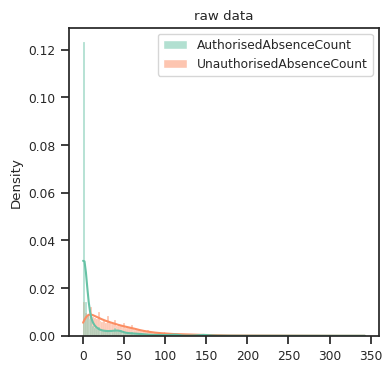

In [ ]:
plt.figure(figsize=(4,4))
sns.histplot(data_2[added_cols_2], kde=True, stat="density")
plt.title("raw data")

In [ ]:
data_2[added_cols_2].describe()

,AuthorisedAbsenceCount,UnauthorisedAbsenceCount
count,24851.00,24851.00
mean,15.12,40.49
std,28.92,39.03
min,0.00,0.00
25%,0.00,12.00
50%,1.00,29.00
75%,15.00,56.00
max,292.00,343.00


missing rate (any) after imputing: 0.0%


Text(0.5, 1.0, 'imputed with median value')

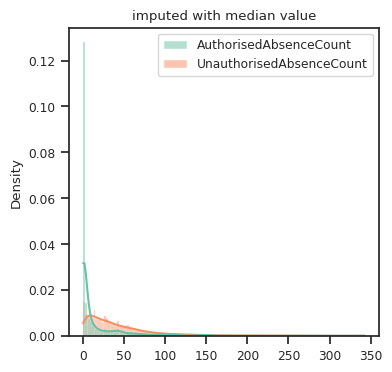

In [ ]:
MedianImputer = SimpleImputer(strategy="median")
MedianImputer.fit(data_2[added_cols_2])
data_2[added_cols_2] = MedianImputer.transform(data_2[added_cols_2])
print(f"missing rate (any) after imputing: {(data_2[added_cols_2].isna().any(axis=1).mean()*100).round(2)}%")
plt.figure(figsize=(4,4))
sns.histplot(data_2[added_cols_2], kde=True, stat="density")
plt.title("imputed with median value")

In [ ]:
# data_2 = raw_data_2.copy()
# MeanImputer = SimpleImputer(strategy="mean")
# MeanImputer.fit(data_2[added_cols_2])
# data_2[added_cols_2] = MeanImputer.transform(data_2[added_cols_2])
# print(f"missing rate (any) after imputing: {(data_2[added_cols_2].isna().any(axis=1).mean()*100).round(2)}%")
# plt.figure(figsize=(4,4))
# sns.histplot(data_2[added_cols_2], kde=True, stat="density")
# plt.title("imputed with mean value")

**Summary of Stage 2 variables** to be used in the data pre-processing step prior to modelling:

In [ ]:
# -------- Stage 2 variables --------

# All numeric features (including ordinal features)
numeric_features_2 = numeric_features_1 + ["absent_ok", "absent_notok"]

# Features to be dropped after preprocessing
del_cols_2 = del_cols_1

# Newly added features at Stage 2
added_cols_2 = ["AuthorisedAbsenceCount", "UnauthorisedAbsenceCount"]

### 🔹 Insights

- Two features have been added at this Stage:
  - *Authorised Absence Count*
  - *Unauthorised Absence Count*   
  The missing values would be imputed using the median strategy.

- *Authorised Absence Count* and *Unauthorised Absence Count* were not combined into a single feature because they capture distinct behavioural patterns with different implications.   
Unauthorised absence is likely a stronger predictor of dropout. Because it reflects a failure to communicate or obtain approval, suggesting disengagement, low accountability, or underlying personal challenges.
In contrast, authorised absence indicates legitimate or pre-approved reasons for non-attendance. Therefore it is less indicative of dropout.

### Stage 3

**Stage 3: Pre-processing instructions**


- Remove any columns not useful in the analysis (LearnerCode).
- Remove columns with high cardinality (use >200 unique values, as a guideline for this data set).
- Remove columns with >50% data missing.
- Perform ordinal encoding for ordinal data.
- Perform one-hot encoding for all other categorical data.
- Choose how to engage with rows that have missing values, which can be done in one of two ways for this project:
  *   Impute the rows with appropriate values.
  *   Remove rows with missing values but ONLY in cases where rows with missing values are minimal: <2% of the overall data.






In [ ]:
data_3 = raw_data_3.copy()

In [ ]:
data_3.shape

(25059, 21)

Checking for missing values

In [ ]:
# Percentage of missing values for each column
data_3.isnull().mean() * 100

,0
CentreName,0.00
LearnerCode,0.00
BookingType,0.00
LeadSource,0.00
DiscountType,69.69
DateofBirth,0.00
Gender,0.00
Nationality,0.00
HomeState,64.38
HomeCity,13.76


Checking whether my intial guess that $AssessedModules=PassedModules+FailedModules$ is true. It is correct!

In [ ]:
(data_3["AssessedModules"].isna() == data_3["PassedModules"].isna() + data_3["FailedModules"].isna()).value_counts()

,count
True,25059


In [ ]:
# Newly added features at Stage 3
added_cols_3 = ["AssessedModules", "PassedModules", "FailedModules"]

In [ ]:
# Checking the missing rate of the newly added feature (before splitting X and y)
missing_rate_any = data_3[added_cols_3].isna().any(axis=1).mean() * 100
missing_rate_all = data_3[added_cols_3].isna().all(axis=1).mean() * 100

if missing_rate_any < 2:
    data_3.dropna(subset = added_cols_3, axis=0, inplace=True)
else:
    print(f"missing rate (any): {missing_rate_any:.2f}% - missing rate (all): {missing_rate_all:.2f}% - Impute the missing values with appropriate values.")

data_3.shape

missing rate (any): 8.90% - missing rate (all): 8.90% - Impute the missing values with appropriate values.


(25059, 21)

Since the missing rate (any) = missing rate (all) = 8.9%, all missing values co-occur across the three features in the same rows. This means it is not possible to impute missing values using

$AssessedModules = PassedModules + FailedModules$

The newly added features are related to each other.We can distil their information into a single variable:

Pass Rate: The proportion of passed modules to assessed modules


In [ ]:
data_3["pass_rate"] = data_3["PassedModules"]/(data_3["AssessedModules"])

Text(0.5, 1.0, 'raw data')

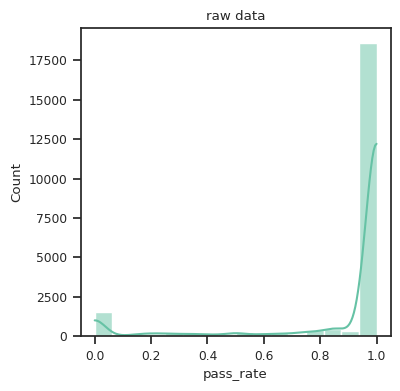

In [ ]:
plt.figure(figsize=(4,4))
sns.histplot(data_3["pass_rate"], kde=True)
plt.title("raw data")

In [ ]:
data_3["pass_rate"].describe()

,pass_rate
count,22828.00
mean,0.89
std,0.28
min,0.00
25%,1.00
50%,1.00
75%,1.00
max,1.00


*Pass_rate* is extremely left-skewed. Imputing its missing values with the mean would be a poor choice that would change the distribution. Therefore, missing values will be imputed using the median.

missing rate (any): 0.0%


Text(0.5, 1.0, 'imputed with median value')

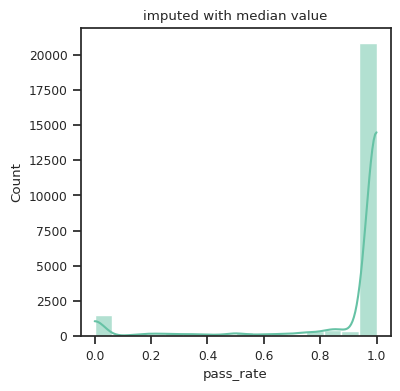

In [ ]:
MedianImputer = SimpleImputer(strategy="median")
MedianImputer.fit(data_3[["pass_rate"]])
data_3["pass_rate"] = MedianImputer.transform(data_3[["pass_rate"]])
print(f"missing rate (any): {(data_3["pass_rate"].isna().mean()*100).round(2)}%")
plt.figure(figsize=(4,4))
sns.histplot(data_3["pass_rate"], kde=True)
plt.title("imputed with median value")

missing rate (any): 0.0%


Text(0.5, 1.0, 'imputed with median value')

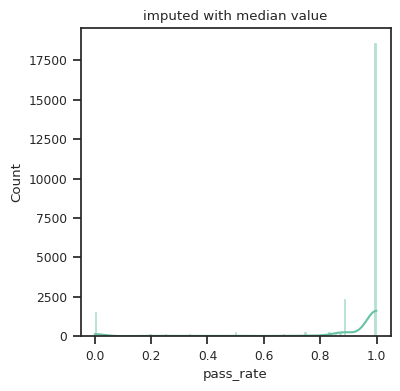

In [ ]:
data_3["pass_rate"] = data_3["PassedModules"]/(data_3["AssessedModules"])

MeanImputer = SimpleImputer(strategy="mean")
MeanImputer.fit(data_3[["pass_rate"]])
data_3["pass_rate"] = MeanImputer.transform(data_3[["pass_rate"]])
print(f"missing rate (any): {(data_3["pass_rate"].isna().mean()*100).round(2)}%")
plt.figure(figsize=(4,4))
sns.histplot(data_3["pass_rate"], kde=True)
plt.title("imputed with median value")

Checking if devision to zero has resulted in infinity values

In [ ]:
data_3[data_3["pass_rate"] == np.inf]["pass_rate"].count()

np.int64(0)

**Summary of Stage 3 variables** to be used in the data pre-processing step prior to modelling:

In [ ]:
# -------- Stage 3 variables --------

# All numeric features (including ordinal features)
numeric_features_3 = numeric_features_2 + ["pass_rate"]

# Features to be dropped after preprocessing
del_cols_3 = del_cols_2 + ["assessed", "passed", "failed"]

# Newly added features at Stage 3
added_cols_3 = added_cols_2 + ["AssessedModules", "PassedModules", "FailedModules"]

### 🔹 Insights

- Three features have been added at this Stage:
  - *Assessed Modules*
  - *Passed Modules*   
  - *Failed Modules*   
  
  The newly added features are related to each other:
  $AssessedModules = PassedModules + FailedModules$
  
  <br>
  
  The information has been distilled into a single variable:
  - Pass Rate: The proportion of passed modules to assessed modules

  <br>
  
- The missing values would be imputed using the median strategy.

**Summary of common variables** used throughout the data pre-processing steps across **all Stages**


In [ ]:
# -------- All stages --------

# Creating cohesive feature names
rename_dict = {
    "CentreName": "centre",
    "LearnerCode": "learner_code",
    "BookingType": "booking_type",
    "LeadSource": "lead_src",
    "DiscountType": "discount_type",
    "DateofBirth": "dob",
    "Gender": "gender",
    "Nationality": "nationality",
    "HomeState": "state",
    "HomeCity": "city",
    "CourseLevel": "course_lvl",
    "CourseName": "course_name",
    "IsFirstIntake": "first_intake",
    "CompletedCourse": "completed",
    "ProgressionDegree": "degree",
    "ProgressionUniversity": "uni",
    "AuthorisedAbsenceCount": "absent_ok",
    "UnauthorisedAbsenceCount": "absent_notok",
    "AssessedModules": "assessed",
    "PassedModules": "passed",
    "FailedModules": "failed"
}

# Target variable
target_col = "CompletedCourse"

# Define the labels for your classes
class_labels = ["not dropout", "dropout"]

# Features to be dropped (either irrelevant or high cardinality)
irr_cols = ["learner_code"]
print(irr_cols)

# Features with a missing rate higher than 50%
# missing_rate = data_1.isnull().mean()
# missing_cols = data_1.columns[missing_rate > 0.5].tolist()
print(missing_cols)

# Features with cardinality above 200
# cardinality = data_1[categorical_features].nunique()
# high_card_cols = data_1[categorical_features].columns[cardinality > 200].tolist()
print(high_card_cols)


# Categorical features (No more categorical features will be added in Stage 2 and 3)
nominal_features = ["centre", "booking_type", "lead_src", "gender", "nationality", "first_intake", "uni", "subject_group", "degree_group"]
print(nominal_features)

ordinal_features = ["course_lvl"]
ordinal_map = {
    "course_lvl": {
        "Foundation": 1,
        "International Year One": 2,
        "International Year Two": 3,
        "Pre-Masters": 4
    }
}


['learner_code']
['discount_type', 'state']
['dob', 'city', 'degree']
['centre', 'booking_type', 'lead_src', 'gender', 'nationality', 'first_intake', 'uni', 'subject_group', 'degree_group']


**Summary of Stage 1 variables** to be used in the data pre-processing step prior to modelling:

In [ ]:
# -------- Stage 1 variables --------

# All numeric features (including ordinal features)
numeric_features_1 = ["course_lvl", "age"]

# Features to be dropped after feature engineering
del_cols_1 = ["course_name", "degree"]

**Summary of Stage 2 variables** to be used in the data pre-processing step prior to modelling:

In [ ]:
# -------- Stage 2 variables --------

# All numeric features (including ordinal features)
numeric_features_2 = numeric_features_1 + ["absent_ok", "absent_notok"]

# Features to be dropped after preprocessing
del_cols_2 = del_cols_1

# Newly added features at Stage 2
added_cols_2 = ["AuthorisedAbsenceCount", "UnauthorisedAbsenceCount"]

**Summary of Stage 3 variables** to be used in the data pre-processing step prior to modelling:

In [ ]:
# -------- Stage 3 variables --------

# All numeric features (including ordinal features)
numeric_features_3 = numeric_features_2 + ["pass_rate"]

# Features to be dropped after preprocessing
del_cols_3 = del_cols_2 + ["assessed", "passed", "failed"]

# Newly added features at Stage 3
added_cols_3 = added_cols_2 + ["AssessedModules", "PassedModules", "FailedModules"]

## EDA

Since Stage 3 data encompasses both Stage 2 and Stage 1, performing EDA on Stage 3 alone would suffice.

In [ ]:
# Clean Stage 3 data for EDA
eda = eda_prep(
    data_3, config,
    stage=3,
    rename_dict=rename_dict,
    irr_cols=irr_cols,
    missing_cols=missing_cols,
    high_card_cols=high_card_cols,
    del_cols=del_cols_3
    )

# Access the results
eda_data = eda["eda_data"]
eda_pipeline = eda["eda_pipeline"]

In [ ]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   centre         25059 non-null  object  
 1   booking_type   25059 non-null  object  
 2   lead_src       25059 non-null  object  
 3   gender         25059 non-null  object  
 4   nationality    25059 non-null  object  
 5   course_lvl     25059 non-null  object  
 6   first_intake   25059 non-null  category
 7   completed      25059 non-null  object  
 8   uni            25059 non-null  category
 9   absent_ok      24851 non-null  float64 
 10  absent_notok   24851 non-null  float64 
 11  pass_rate      22828 non-null  float64 
 12  age            25059 non-null  int32   
 13  subject_group  25059 non-null  category
 14  degree_group   24184 non-null  category
dtypes: category(4), float64(3), int32(1), object(7)
memory usage: 2.1+ MB


In [ ]:
eda_data.describe()

,absent_ok,absent_notok,pass_rate,age
count,24851.00,24851.00,22828.00,25059.00
mean,15.12,40.49,0.89,25.02
std,28.92,39.03,0.28,3.17
min,0.00,0.00,0.00,19.00
25%,0.00,12.00,1.00,23.00
50%,1.00,29.00,1.00,24.00
75%,15.00,56.00,1.00,27.00
max,292.00,343.00,1.00,63.00


Checking the outliers

In [ ]:
num_cols = eda_data.drop(columns="completed", axis=1).select_dtypes(include=["float", "int"]).columns

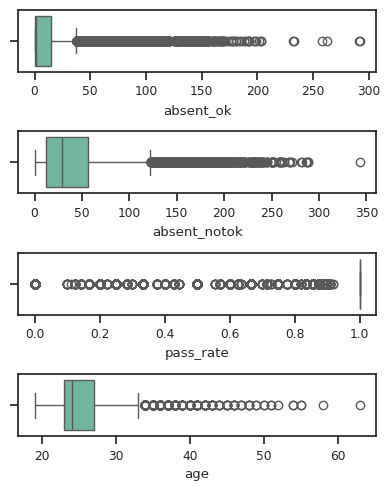

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(4, 5))
axes = axes.flatten()

# Plot a box plot for each feature
for i, col in enumerate(num_cols):
    sns.boxplot(data=eda_data[col], ax=axes[i], orient="h")

plt.tight_layout()
plt.show()

Checking the distribution of numeric features

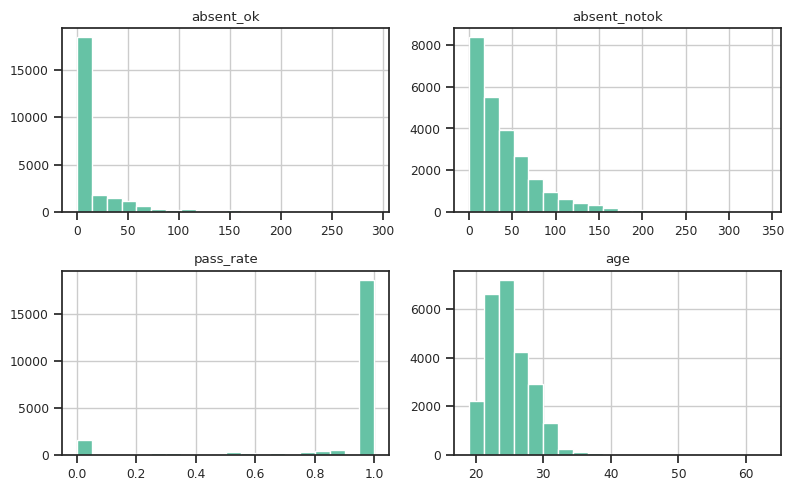

In [ ]:
eda_data[num_cols].hist(bins=20, figsize=(8, 5))

plt.tight_layout()
plt.show()

Checking the balance of the target variable

In [ ]:
# Create the target variable
eda_data["dropout"] = (eda_data["completed"] == "No").astype(int)
eda_data = eda_data.drop(columns=["completed"], axis=1)

In [ ]:
eda_data["dropout"].value_counts()

,count
dropout,
0,21305
1,3754


In [ ]:
eda_data["dropout"].value_counts(normalize=True)

,proportion
dropout,
0,0.85
1,0.15


In [ ]:
class_ratio = eda_data["dropout"].value_counts().min()/eda_data["dropout"].value_counts().max()
class_ratio

0.1762027693029805

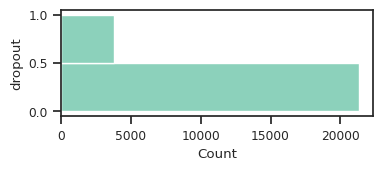

In [ ]:
fig = plt.figure(figsize=(4, 1.8))

# Plot a histogram plot for the target variable
sns.histplot(y=eda_data["dropout"], bins=2)

plt.tight_layout()
plt.show()

Checking the distribution of the learners who dropped out (dropout=1) across the classes of each categorical feature

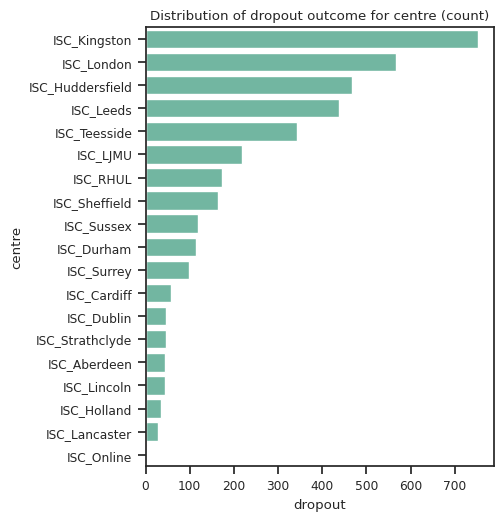

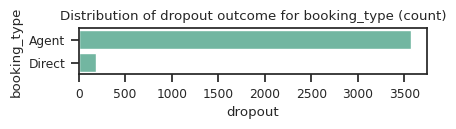

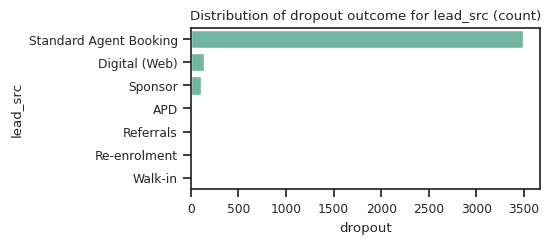

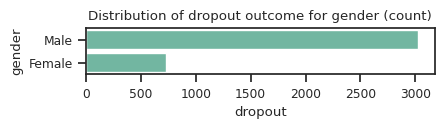

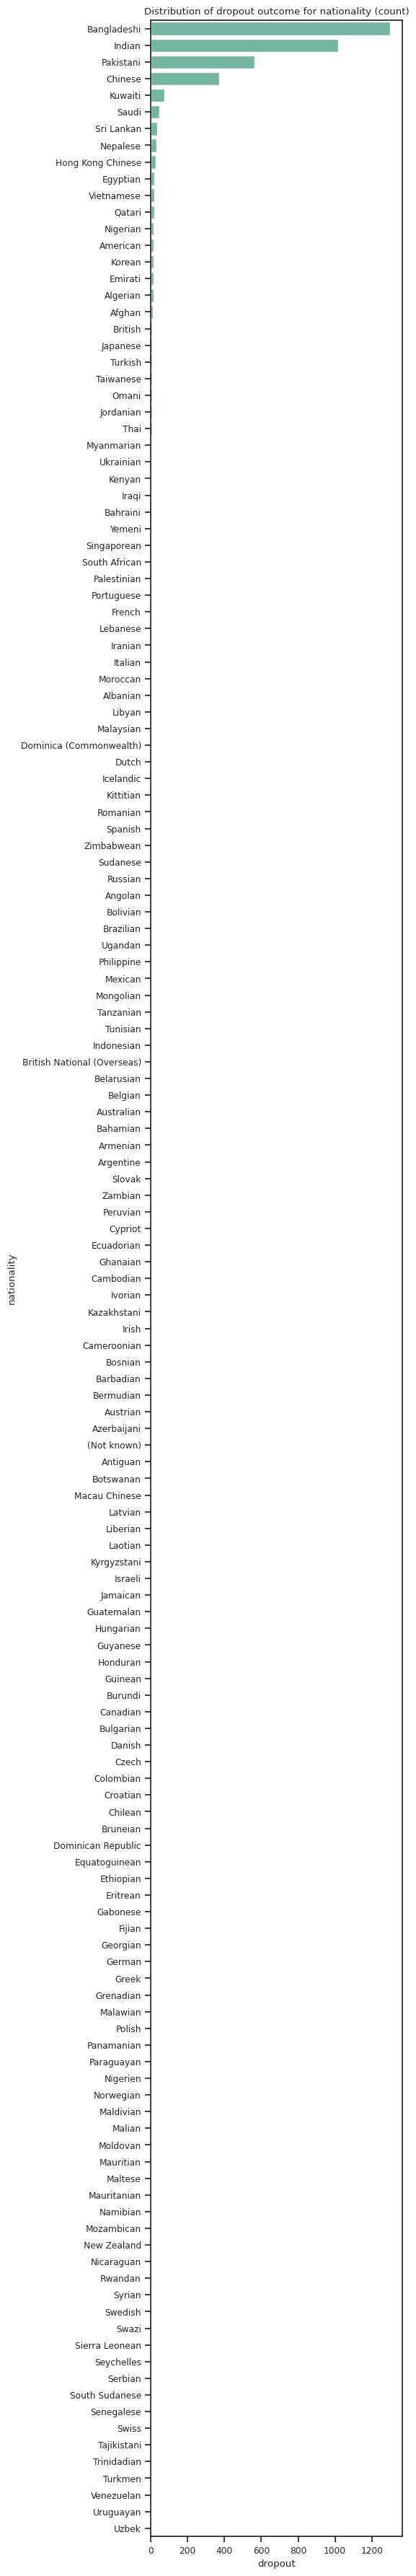

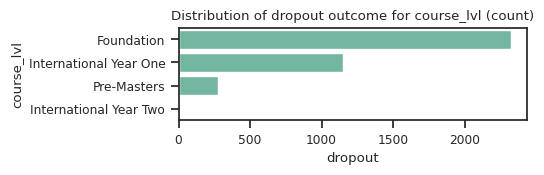

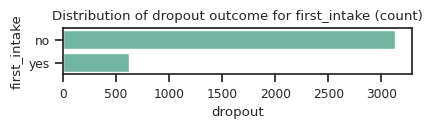

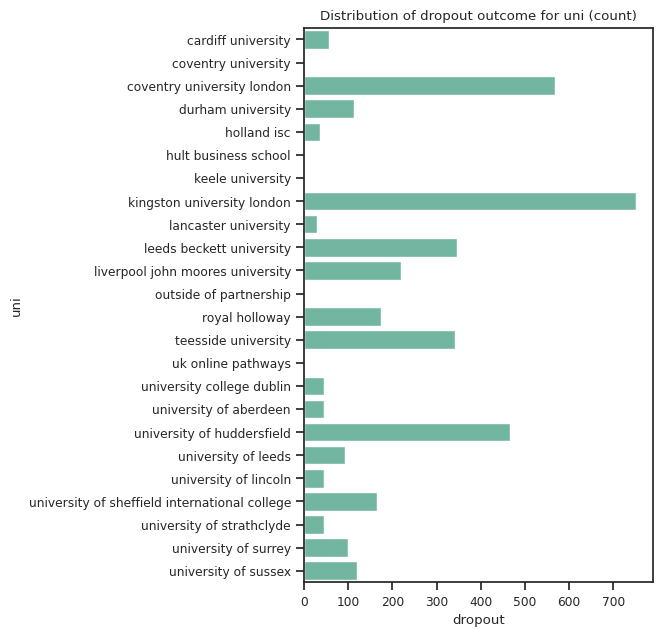

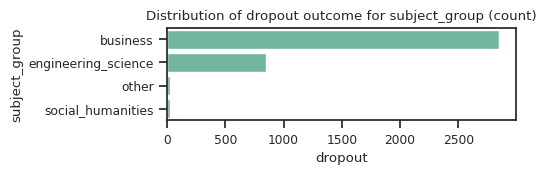

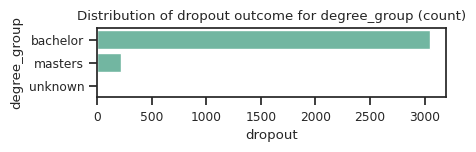

In [ ]:
cat_cols = eda_data.select_dtypes(include=["object", "category"]).columns

for col in cat_cols:
    # Group the learners by their outcome for each feature & plot the dropout count
    dropout_counts_by_category = eda_data.groupby(col, dropna=False)["dropout"].sum().sort_values(ascending= False)

    fig = plt.figure(figsize=(4.5, 0.3*eda_data[col].nunique()))

    # Plot a histogram plot for each
    sns.barplot(dropout_counts_by_category, orient="h")
    plt.title(f"Distribution of dropout outcome for {col} (count)")

plt.tight_layout()
plt.show()

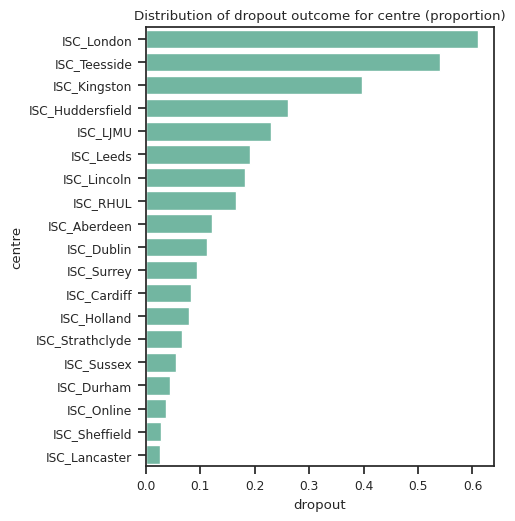

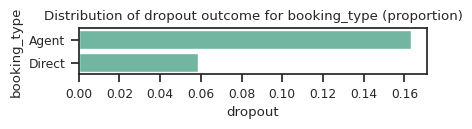

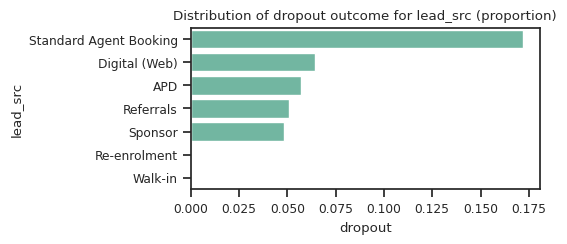

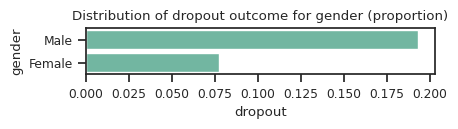

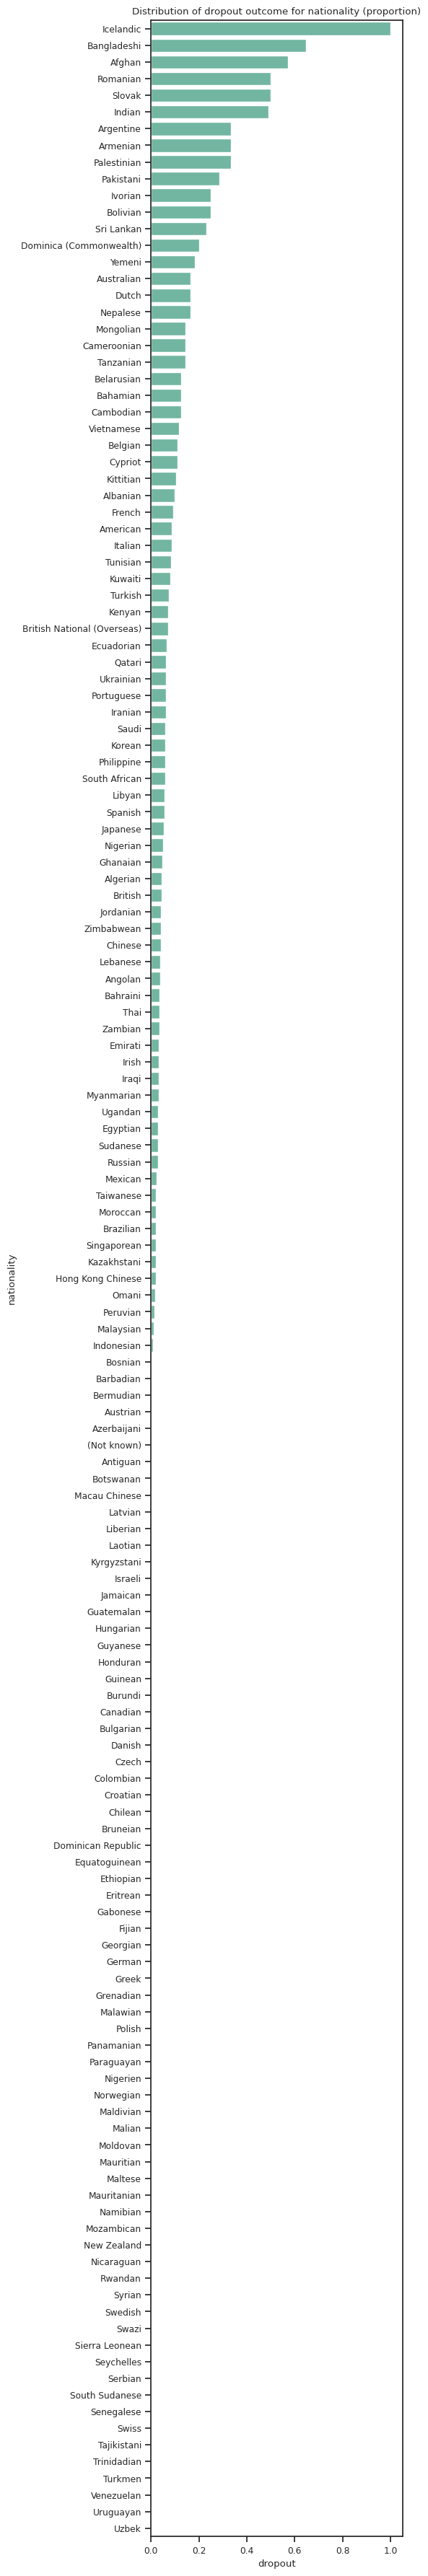

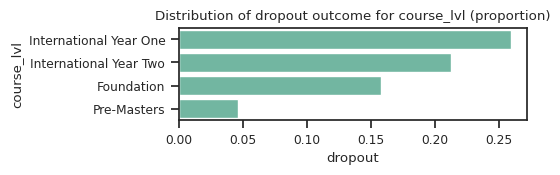

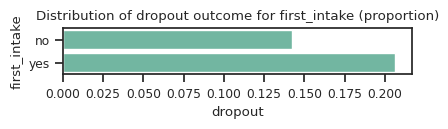

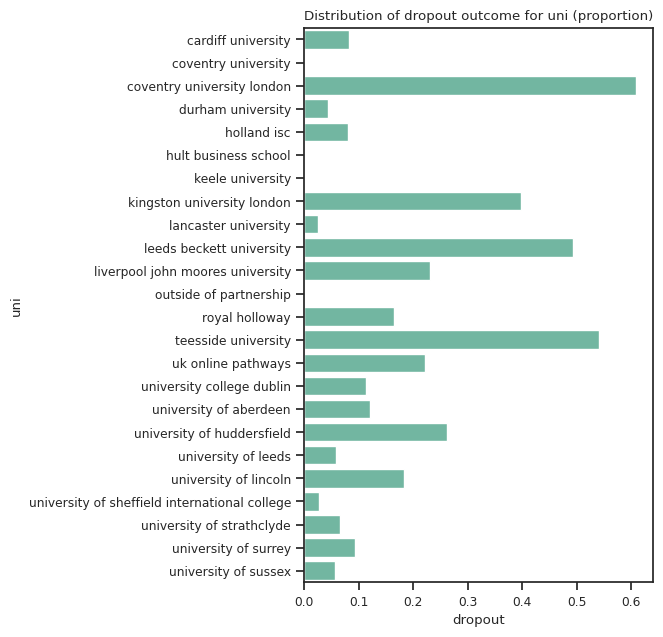

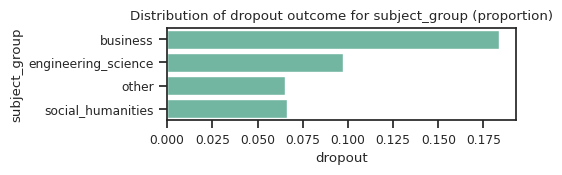

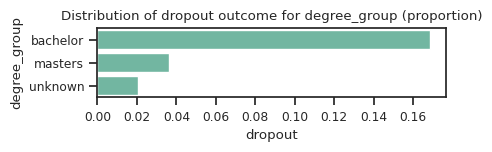

In [ ]:
cat_cols = eda_data.select_dtypes(include=["object", "category"]).columns

for col in cat_cols:
    # Group the learners by their outcome for each feature & plot the dropout proportion
    dropout_counts_by_category = eda_data.groupby(col, dropna=False)["dropout"].mean().sort_values(ascending= False)

    fig = plt.figure(figsize=(4.5, 0.3*eda_data[col].nunique()))

    # Plot a histogram plot for each
    sns.barplot(dropout_counts_by_category, orient="h")
    plt.title(f"Distribution of dropout outcome for {col} (proportion)")

plt.tight_layout()
plt.show()

Checking the distribution of numeric features for each dropout outcome

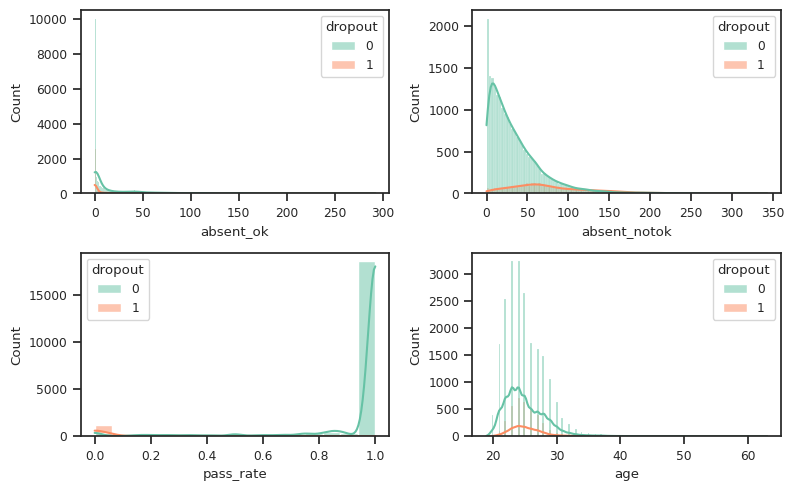

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 5))
axes = axes.flatten()

# # Plot a histogram for each feature
for i, col in enumerate(num_cols):
    sns.histplot(x=eda_data[col], hue=eda_data["dropout"], ax=axes[i], kde=True)

plt.tight_layout()
plt.show()

### 🔹 Insights

- We are dealing with a highly imbalanced dataset, with the dropout group comprising only 15% of the observations (Prevalence=0.15). This imbalance may adversely affect model performance. One option would be to up-sample the minority class. Down-sampling is less desirable, as the dataset is not large, and it is preferable not to discard any observations. Despite these options, it is good practice to begin modelling without altering the data and only address the imbalance if the initial results prove unsatisfactory.

- Some features show a strong association with the target variable. We expect these to emerge as important predictors in the modelling step:
  - unauthorised absent count
  - pass rate
  - nationality
  - centre
  

- The distribution of numeric features is not normal, and there are outliers present in the data. As these outliers may carry informative signals relevant to dropout prediction, we have chosen not to discard them. The XGBoost model is inherently robust to feature magnitude, while the Neural Network becomes robust once scaling is applied during the data pre-processing pipeline.

# 🧠 Neural Network

In [ ]:
modelling = "neural_network"

The Neural Network was trained on the training data, monitored on the validation data, and evaluated on the test data.


To ensure robustness and efficiency, several callbacks were employed. Early Stopping was used to halt training once the model's performance on the validation set ceased to improve, thereby preventing overfitting. Model Checkpoints were implemented to save the model version that achieved the best validation loss, accuracy, or PR-AUC score.


In [ ]:
config_0 = dict(config)
nn_config = config_0["model_params"]["neural_network"]
nn_config

{'api': 'sequential',
 'layer': 'dense',
 'n_neuron': [16, 16, 1],
 'hidden_activation': 'relu',
 'output_activation': 'sigmoid',
 'dropout_rate': 0.5,
 'optimizer': 'adam',
 'learning_rate': 0.001,
 'loss': 'binary_crossentropy',
 'metrics': [<BinaryAccuracy name=accuracy>,
  <Precision name=precision>,
  <Recall name=recall>,
  <F1Score name=f1_score>,
  <AUC name=roc_auc>,
  <AUC name=pr_auc>],
 'decision_threshold': 0.5,
 'epochs': 50,
 'batch_size': 32,
 'early_stoppying_monitor': 'val_loss',
 'patience': 5,
 'checkpoint_monitor': {'loss': ['val_loss', 'min'],
  'accuracy': ['val_accuracy', 'max'],
  'pr_auc': ['val_pr_auc', 'max']},
 'tuner_objective': <keras_tuner.src.engine.objective.Objective at 0x7c2f2277ef60>}

Above **configuration** provides the initial set of hyperparameters required for the Neural Network model.

- The model is constructed using a Sequential API, stacking layers linearly one after another.

- The model consists of fully connected layers (Dense Layers) allowing the network to learn complex relationships between all input variables

- Starting from a simple architecture, the network architecture uses two hidden layers with 16 neurons each, leading to a single output neuron. This shallow and narrow architecture is selected as a baseline, ensuring low computational overhead while maintaining sufficient capacity to capture initial patterns in the data.

- The Rectified Linear Unit (ReLU) function, the default choice for hidden layers, is applied to introduce non-linearity in the hidden layers.

- The Sigmoid function is used on the final layer to produce a prediction probability between 0 and 1.

- Dropout was applied as a regularisation technique to force the network to learn more robust features that are not dependent on any single neuron. Therefore, 50%  of neurons are randomly ignored during each training step to prevent the model from overfitting.

- The Adam algorithm is used to efficiently adjust the model's weights during training. Because of its simplicity and directness, it is ideal for defining a standard feed-forward network structure.

- The magnitude of change applied to the model's weights during optimisation is set to 0.001, a common and safe starting point for the learning rate.

- Binary Crossentropy loss function measures the model's error for this binary classification task.

- The model is limited to a maximum of 50 training cycles over the entire dataset. This provides a reasonable training time, ensuring the model has enough iterations to learn patterns.

- The model processes 32 samples at a time before updating its internal weights. A small batch size is often preferred in imbalanced classification as it help the model focus more on the minority class samples (dropouts).

- A comprehensive set of performance scores will be monitored during training as accuracy alone would be misleading on the imbalanced data involved in this project.
  - the threshold-dependent metrics: accuracy, precision, recall, F1 score
  For the threshold-independent metrics the decision threshold is set to 0.5, meaning any predicted probability greater than 0.5 is classified as a positive outcome (dropout). 0.5 is the standard default threshold used as a neutral starting point. However, it can be potentially adjusted based on the specific business trade-off between precision and recall.
  - the threshold-independent metrics: ROC-AUC, and PR-AUC


- The training process will check the validation loss to determine if the model's performance has plateaued. Training will automatically stop if the the validation loss does not improve for 5 consecutive epochs.

- The model's weights are saved whenever it achieves the best validation loss, accuracy, or PR-AUC score.


For **hyperparameter tuning**:

- Among the hyperparameters set in the intial configuration, the following hyperparameters were tuned to find the best model:

  - number of neurons
  - optimisers
  - activations functions


The model was tuned using an exhaustive Grid Search across all possible combinations of hyperparameter values.

During hyperparameter optimisation, the best model was selected based on the highest validation PR-AUC. PR-AUC was used as the main evaluation metric because it captures the balance between recall and precision across all possible thresholds. It is the optimal choice for binary classification with strong class imbalance, as it does not include True Negatives, which are very common in this dataset and can easily hide weak performance on the minority class(REF 1). The baseline PR-AUC is equal to the Prevalence, which in this case is 0.15.


Defining the hyperparameter space for tuning

In [ ]:
# Define parameter grid for hyperparameter tuning
nn_param_grid = {
    # Neuron configurations to test
    "n_neuron": [
        [128, 64, 32, 16, 1],
        [256, 64, 1],
        [256, 16, 1]
    ],
    "n_neuron_indx": [0, 1, 2],

    # Optimizers to test
    "optimizer": ["adam", "rmsprop"],
    # Learning rates to test
    "learning_rate": [0.0001, 0.001],

    # Activation functions to test
    "hidden_activation": ["relu", "elu"],
}

## Stage 1

In [ ]:
stage = 1

###  data pre-process

Pre-processing Stage 1 data and preparing it for the neural network modelling

In [ ]:
data_1 = raw_data_1.copy()

In [ ]:
data_1.shape

(25059, 16)

In [ ]:
# -------- Stage 1 variables --------

# All numeric features (including ordinal features)
numeric_features_1 = ["course_lvl", "age"]

# Features to be dropped after feature engineering
del_cols_1 = ["course_name", "degree"]

In [ ]:
modelling = "neural_network"

stage1_data = pre_modelling_prep(
    data_1, config,
    stage=stage,
    rename_dict=rename_dict,
    irr_cols=irr_cols,
    missing_cols=missing_cols,
    high_card_cols=high_card_cols,
    ordinal_map=ordinal_map,
    numeric_features=numeric_features_1,
    nominal_features=nominal_features,
    added_cols=None,
    del_cols=del_cols_1,
    modelling=modelling
    )


# Access the results
X_train_1 = stage1_data["X_train"]
X_val_1 = stage1_data["X_val"]
X_test_1 = stage1_data["X_test"]
y_train_1 = stage1_data["y_train"]
y_val_1 = stage1_data["y_val"]
y_test_1 = stage1_data["y_test"]
pipeline_1 = stage1_data["pipeline"]

Checking the shape of each split

In [ ]:
print(X_train_1.shape, X_val_1.shape, X_test_1.shape, y_train_1.shape, y_val_1.shape, y_test_1.shape)

(18042, 194) (2005, 194) (5012, 194) (18042,) (2005,) (5012,)


### simple initial trial

Neural netwrok modelling using the initial simple configuration and Stage 1 data

In [ ]:
test_log_dir = f"{parent_log_dir}/models/intial_{stage}"
nn_training_1 = train_nn_model(stage, seed, X_train_1, y_train_1, X_val_1, y_val_1, nn_config, test_log_dir)


Epoch 1: val_pr_auc improved from -inf to 0.56216, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/models/intial_1/checkpoint/stage_1/best_model_val_pr_auc.keras

Epoch 2: val_pr_auc improved from 0.56216 to 0.60033, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/models/intial_1/checkpoint/stage_1/best_model_val_pr_auc.keras

Epoch 3: val_pr_auc improved from 0.60033 to 0.60419, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/models/intial_1/checkpoint/stage_1/best_model_val_pr_auc.keras

Epoch 4: val_pr_auc did not improve from 0.60419

Epoch 5: val_pr_auc improved from 0.60419 to 0.60857, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/models/intial_1/checkpoint/stage_1/best_model_val_pr_auc.keras

Epoch 6: val_pr_auc improved from 0.60857 to 0.61060, saving model to /content/drive/My Drive/Career

In [ ]:
# Load the model
nn_model_dir = test_log_dir + f"/checkpoint/stage_{stage}/best_model_val_pr_auc.keras"
nn_model_1 = tf.keras.models.load_model(nn_model_dir)

In [ ]:
nn_model_1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 16)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,229 (39.96 KB)

 Trainable params: 3,409 (13.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,820 (26.64 KB)

Visulising the training process and how model's training and validation loss and metrics evolve across epochs

In [ ]:
%tensorboard --logdir "/content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/models"

Evaluating the model on the test data

Keras metrics  
Stage : 1 
Loss : 0.26244163513183594 
PR-AUC: 0.6631826162338257 
ROC-AUC: 0.8936715126037598 
Accuracy: 0.8916600346565247 
Precision: 0.6661341786384583 
Recall : 0.555259644985199 
F1: 0.2606281340122223 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold-independent metrics  
Stage1
pr-auc: 0.6625937877109691 
roc-auc: 0.8936569280543097 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage1
accuracy: 0.891660015961692 
precision: 0.6661341853035144 
recall: 0.5552596537949401 
f1: 0.6056644880174292 



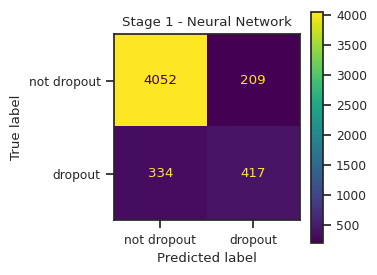

In [ ]:
evaluate_1_test = evaluate_nn(stage, X_test_1, y_test_1, nn_config, nn_model_1, class_labels)

◼ The default decision threshold of 0.5 can be unreliable for our imbalanced dataset, as it often leads to poor Recall (missing dropout cases). Therefore, we focus our analysis on threshold-independent metrics like PR-AUC (Precision-Recall Area Under the Curve) and ROC-AUC (Receiver Operating Characteristic Area Under the Curve). These metrics evaluate the model's performance across all possible cutoffs, providing a robust measure of its ability to distinguish dropouts from non-dropouts, regardless of any single, arbitrary threshold.

### 🔹 Insights
- The training was successfully halted before overtraining occurred. The low number of final epochs indicates that the model quickly learned as much as it could from the available data.

- The performance of the simple initial neural network model is quite decent (PR-AUC: 0.66).
For an imbalanced dataset, the baseline PR-AUC corresponds to the Prevalence, in this case: 0.15.

- The model achieved a PR-AUC of 0.66, showing that even a relatively simple initial network was able to capture the underlying patterns and relationships effectively.

- The ROC-AUC (0.89), exceeds 0.5 (whcih corresponds to the performance of a random classifier). This confirms the model's acceptable discriminative ability. As expected, the accuracy metric is relatively high and provides an inflated estimate of the model's actual performance.

### hyperparameter tuning

Hyperparameter tuning and saving the best hyperparameters

In [ ]:
# stage = 1
# config_0 = dict(config)
# nn_config = config_0["model_params"]["neural_network"]
# tuning_log_dir = f"{parent_log_dir}/tuning/stage_{stage}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
# tuner_1 = hp_tuner(stage, seed, build_wrapper, nn_config, X_train_1, y_train_1, X_val_1, y_val_1, tuning_log_dir, True) # Change the True to False to load the already existing results

Retrieving the hyperparameter tuning results

In [ ]:
stage = 1
config_0 = dict(config)
nn_config = config_0["model_params"]["neural_network"]
directory = f"{parent_log_dir}/tuning/stage_{stage}_20251109-141808"
tuner_1 = hp_tuner(stage, seed, build_wrapper, nn_config, X_train_1, y_train_1, X_val_1, y_val_1, directory, False)

Reloading Tuner from /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/tuning/stage_1_20251109-141808/nn_tuning_grid_1/tuner0.json


Visulising the tuning process and how model's training and validation loss and metrics evolve across epochs

In [ ]:
%tensorboard --logdir "/content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/tuning/stage_1_20251109-141808"

Best configuration based on the hyperparameter tuning results

In [ ]:
nn_tuning_1 = best_nn_hp(tuner_1, nn_param_grid, nn_config)
best_nn_config_1 = nn_tuning_1["best_nn_config"]

Best hyperparameters:
Hidden activation: relu
Optimizer: adam
Learning rate: 0.001
Number of neurons: [256, 64, 1]



In [ ]:
best_nn_config_1

{'api': 'sequential',
 'layer': 'dense',
 'n_neuron': [256, 64, 1],
 'hidden_activation': 'relu',
 'output_activation': 'sigmoid',
 'dropout_rate': 0.5,
 'optimizer': 'adam',
 'learning_rate': 0.001,
 'loss': 'binary_crossentropy',
 'metrics': [<BinaryAccuracy name=accuracy>,
  <Precision name=precision>,
  <Recall name=recall>,
  <F1Score name=f1_score>,
  <AUC name=roc_auc>,
  <AUC name=pr_auc>],
 'decision_threshold': 0.5,
 'epochs': 50,
 'batch_size': 32,
 'early_stoppying_monitor': 'val_loss',
 'patience': 5,
 'checkpoint_monitor': {'loss': ['val_loss', 'min'],
  'accuracy': ['val_accuracy', 'max'],
  'pr_auc': ['val_pr_auc', 'max']},
 'tuner_objective': <keras_tuner.src.engine.objective.Objective at 0x7c2f2277ef60>}

Training the model using the best configuration

In [ ]:
best_log_dir = f"{parent_log_dir}/bests/best_{stage}"
best_nn_training_1 = train_nn_model(stage, seed, X_train_1, y_train_1, X_val_1, y_val_1, best_nn_config_1, best_log_dir)


Epoch 1: val_pr_auc improved from -inf to 0.60445, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/bests/best_1/checkpoint/stage_1/best_model_val_pr_auc.keras

Epoch 2: val_pr_auc improved from 0.60445 to 0.61551, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/bests/best_1/checkpoint/stage_1/best_model_val_pr_auc.keras

Epoch 3: val_pr_auc improved from 0.61551 to 0.62014, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/bests/best_1/checkpoint/stage_1/best_model_val_pr_auc.keras

Epoch 4: val_pr_auc improved from 0.62014 to 0.62547, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/bests/best_1/checkpoint/stage_1/best_model_val_pr_auc.keras

Epoch 5: val_pr_auc improved from 0.62547 to 0.62626, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/bests/best_1/

In [ ]:
# Load the model
best_nn_model_dir = best_log_dir + f"/checkpoint/stage_{stage}/best_model_val_pr_auc.keras"
best_nn_model_1 = tf.keras.models.load_model(best_nn_model_dir)

Evaluating the model on the test data

Keras metrics  
Stage : 1 
Loss : 0.258349746465683 
PR-AUC: 0.6675971746444702 
ROC-AUC: 0.8955680131912231 
Accuracy: 0.8954508900642395 
Precision: 0.6748844385147095 
Recall : 0.5832223892211914 
F1: 0.2606281340122223 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold-independent metrics  
Stage1
pr-auc: 0.6685350315031227 
roc-auc: 0.8955956713898794 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage1
accuracy: 0.8954509177972865 
precision: 0.674884437596302 
recall: 0.5832223701731025 
f1: 0.6257142857142857 



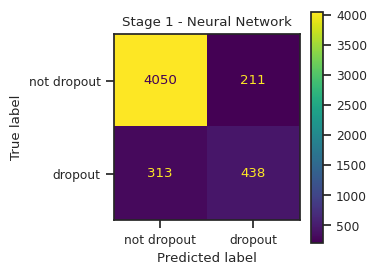

In [ ]:
evaluate_1_test = evaluate_nn(stage, X_test_1, y_test_1, best_nn_config_1, best_nn_model_1, class_labels)

Visulising the training process and how model's training and validation loss and metrics evolve across epochs

In [ ]:
%tensorboard --logdir "/content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/bests"

Feature importance and explainability with SHAP

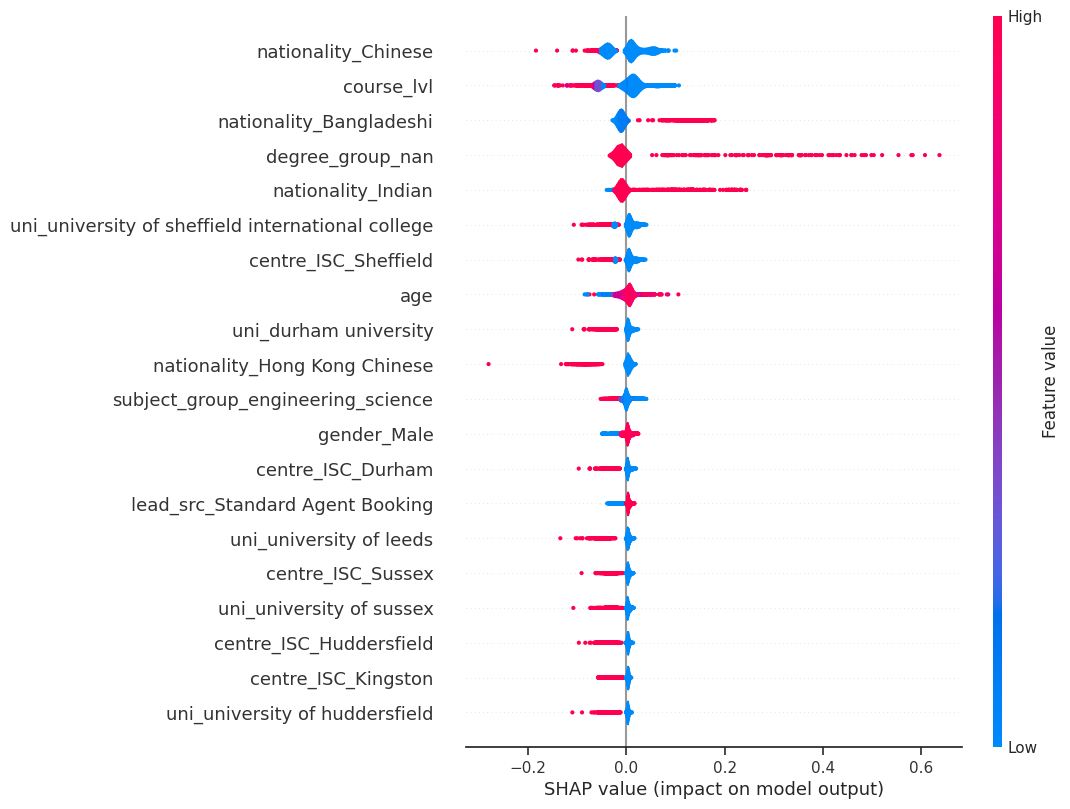

In [ ]:
features_1_nn = pipeline_1.named_steps["scaler_encoder"].get_feature_names_out()
cleaned_features_1_nn = [name.split("__")[-1] for name in features_1_nn]

# Choose a background dataset (reference)
num_rows = X_train_1.shape[0]
sample_indices = np.random.choice(
    num_rows,
    size=1000,
    replace=False,
)

# a small sample of the training data that serves as the baseline or expected value (E[f(x)])
background = X_train_1[sample_indices].astype(np.float32)

# Choose the SHAP Explainer
explainer = shap.DeepExplainer(best_nn_model_1, background)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test_1.astype(np.float32))

# Use the SHAP values for the positive class for binary classification
shap_values_positive_class = shap_values[:, :, 0]

# Violin plot for most important features
shap.plots.violin(
    shap_values_positive_class,
    X_test_1,
    feature_names=cleaned_features_1_nn,
    show=True
)


### 🔹 Insights

- After hyperparameter tuning, only a slight increase (1.3%) was observed in the main metric (PR-AUC: 0.66 >> 0.67).

- The remaining metrics also showed only marginal improvements. This suggests that:

  - although the model's performance improved, the gain is not substantial enough to justify the computational cost of tuning;

  - neural networks are indeed powerful. Given the dataset's moderate complexity and sample size, even a relatively simple initial model was able to capture the underlying patterns and relationships effectively;


- Visual inspection of the loss curves in TensorBoard revealed no noticeable signs of overfitting.

- Features with the highest mean absolute SHAP values (importance) are as follows:

  - Learners from China or Hong Kong show lower risk of dropout, while Bangladeshi and Indian learners show higher risk.  

  - Lower course levels are associated with higher dropout risk.  

  - Learners whose intended partner university is the University of Sheffield International College, Durham University, the University of Leeds, or the University of Huddersfield are not at risk of dropout.  

  - Learners located at ********** ISC Sheffield, ISC Durham, ISC Sussex, ISC Huddersfield, or ISC Kingston centres are also not at risk.  

  - Older learners show higher risk of dropout.

  - Male learners show higher risk of dropout.

  - Learners studying engineering or science appear less prone to dropout.  

  - Learners with missing degree information form a large group with high dropout risk. This is worth investigating. There may be hidden structure or missing-not-at-random patterns here.  




- Interestingly, the direction of these feature influences may appear counterintuitive when compared with simple univariate observations from the EDA. For example, EDA showed that Chinese learners are among the nationalities with high dropout counts. However, the Neural Network, which has a multivariate perspective, tells a different story. This highlights the presence of strong feature interactions, meaning that the predictive patterns are not straightforward one-to-one associations.   
  ▪ One explanation for this could be that Chinese learners are mainly enrolled at centres, or intend to progress to universities, with already high dropout risk. In that case, the combination of other risky factors may have effectively masked the individual contribution of the nationality variable.     
  ▪ Another explanation could be that Chinese learners are disproportionately represented in the group with missing degree information, and their elevated dropout risk may have been captured and expressed through the degree = NaN feature importance instead. In other words, the model found a better, more specific feature (for example degree=NaN) to explain the dropout risk. The risk is still there, but attributed elsewhere.   

  ✔ Detailed investigation of the data revealed that the sample size of dropouts among Chinese learners is extremely small relative to the total number of Chinese students (4%). In other words, the class imbalance is even more extreme within this subgroup, making it difficult for the model to rely on nationality to identify Chinese dropouts. In this context, it is more informative to examine the EDA plots showing the proportion of dropouts within each subgroup rather than raw dropout counts. The proportional view provides a clearer initial sense of subgroup-level risk.

In [ ]:
eda_data["dropout"].value_counts(normalize=True)

,proportion
dropout,
0,0.85
1,0.15


In [ ]:
eda_data[eda_data["nationality"]=="Chinese"]["dropout"].value_counts(normalize=True)

,proportion
dropout,
0,0.96
1,0.04


## Stage 2

In [ ]:
stage = 2

###  data pre-process

Pre-processing Stage 2 data and preparing it for the neural network modelling

In [ ]:
data_2 = raw_data_2.copy()

In [ ]:
data_2.shape

(25059, 18)

In [ ]:
# -------- Stage 2 variables --------

# All numeric features (including ordinal features)
numeric_features_2 = numeric_features_1 + ["absent_ok", "absent_notok"]

# Features to be dropped after preprocessing
del_cols_2 = del_cols_1

# Newly added features at Stage 2
added_cols_2 = ["AuthorisedAbsenceCount", "UnauthorisedAbsenceCount"]

In [ ]:
modelling = "neural_network"

stage2_data = pre_modelling_prep(
    data_2, config,
    stage=stage,
    rename_dict=rename_dict,
    irr_cols=irr_cols,
    missing_cols=missing_cols,
    high_card_cols=high_card_cols,
    ordinal_map=ordinal_map,
    numeric_features=numeric_features_2,
    nominal_features=nominal_features,
    added_cols=added_cols_2,
    del_cols=del_cols_2,
    modelling=modelling)


# Access the results
X_train_2 = stage2_data["X_train"]
X_val_2 = stage2_data["X_val"]
X_test_2 = stage2_data["X_test"]
y_train_2 = stage2_data["y_train"]
y_val_2 = stage2_data["y_val"]
y_test_2 = stage2_data["y_test"]
pipeline_2 = stage2_data["pipeline"]

In [ ]:
print(X_train_2.shape, X_val_2.shape, X_test_2.shape, y_train_2.shape, y_val_2.shape, y_test_2.shape)

(18042, 196) (2005, 196) (5012, 196) (18042,) (2005,) (5012,)


### simple initial trial

Neural netwrok modelling using the initial simple configuration and Stage 2 data

In [ ]:
test_log_dir = f"{parent_log_dir}/models/intial_{stage}"
nn_training_2 = train_nn_model(stage, seed, X_train_2, y_train_2, X_val_2, y_val_2, nn_config, test_log_dir)


Epoch 1: val_pr_auc improved from -inf to 0.64596, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/models/intial_2/checkpoint/stage_2/best_model_val_pr_auc.keras

Epoch 2: val_pr_auc improved from 0.64596 to 0.67157, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/models/intial_2/checkpoint/stage_2/best_model_val_pr_auc.keras

Epoch 3: val_pr_auc improved from 0.67157 to 0.68510, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/models/intial_2/checkpoint/stage_2/best_model_val_pr_auc.keras

Epoch 4: val_pr_auc improved from 0.68510 to 0.68818, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/models/intial_2/checkpoint/stage_2/best_model_val_pr_auc.keras

Epoch 5: val_pr_auc improved from 0.68818 to 0.69146, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/m

In [ ]:
# Load the model
nn_model_dir = test_log_dir + f"/checkpoint/stage_{stage}/best_model_val_pr_auc.keras"
nn_model_2 = tf.keras.models.load_model(nn_model_dir)

In [ ]:
nn_model_2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 16)             │         3,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,325 (40.34 KB)

 Trainable params: 3,441 (13.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,884 (26.89 KB)

Visulising the training process and how model's training and validation loss and metrics evolve across epochs

In [ ]:
%tensorboard --logdir "/content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/models"

Evaluating the model on the test data

Keras metrics  
Stage : 2 
Loss : 0.2367331087589264 
PR-AUC: 0.7188225984573364 
ROC-AUC: 0.9185606241226196 
Accuracy: 0.9048284292221069 
Precision: 0.7362068891525269 
Recall : 0.5685752034187317 
F1: 0.2606281340122223 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Threshold-independent metrics  
Stage2
pr-auc: 0.7190579361583032 
roc-auc: 0.9190718406905477 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage2
accuracy: 0.9048284118116521 
precision: 0.7362068965517241 
recall: 0.5685752330226365 
f1: 0.6416228399699474 



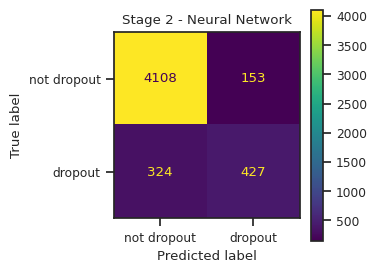

In [ ]:
evaluate_2_test = evaluate_nn(stage, X_test_2, y_test_2, nn_config, nn_model_2, class_labels)

### 🔹 Insights
- The training was successfully halted before overtraining occurred.

- The performance of the simple initial neural network model is quite decent.
For an imbalanced dataset, the baseline PR-AUC corresponds to the Prevalence, in this case: 0.15.

- The model achieved a PR-AUC of 0.72, showing that even a relatively simple initial network is able to capture the underlying patterns and relationships effectively.

- Since the configuration of the initial models is identical across Stage 1 and Stage 2, we can conclude that the improvement in model performance from Stage 1 (0.66) to Stage 2 (0.72) is solely due to the addition of valuable data. This finding suggests that student engagement data enhances the predictive power of the model.

- The ROC-AUC (0.92) exceeds 0.5 (whcih corresponds to the performance of a random classifier). This confirms the model's acceptable discriminative ability. As anticipated, the accuracy metric is relatively high and provides an inflated estimate of the model's actual performance.

### hyperparameter tuning

Hyperparameter tuning and saving the best hyperparameters

In [ ]:
# stage = 2
# config_0 = dict(config)
# nn_config = config_0["model_params"]["neural_network"]
# tuning_log_dir = f"{parent_log_dir}/tuning/stage_{stage}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
# tuner_2 = hp_tuner(stage, seed, build_wrapper, nn_config, X_train_2, y_train_2, X_val_2, y_val_2, tuning_log_dir, True) # Change the True to False to load the already existing results

Retrieving the hyperparameter tuning results

In [ ]:
stage = 2
config_0 = dict(config)
nn_config = config_0["model_params"]["neural_network"]
directory = f"{parent_log_dir}/tuning/stage_{stage}_20251109-145728"
tuner_2 = hp_tuner(stage, seed, build_wrapper, nn_config, X_train_2, y_train_2, X_val_2, y_val_2, directory, False)

Reloading Tuner from /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/tuning/stage_2_20251109-145728/nn_tuning_grid_2/tuner0.json


Visulising the training process and how model's training and validation loss and metrics evolve across epochs

In [ ]:
%tensorboard --logdir "/content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/tuning/stage_2_20251109-145728"

Best configuration based on the hyperparameter tuning results

In [ ]:
nn_tuning_2 = best_nn_hp(tuner_2, nn_param_grid, nn_config)
best_nn_config_2 = nn_tuning_2["best_nn_config"]

Best hyperparameters:
Hidden activation: relu
Optimizer: adam
Learning rate: 0.001
Number of neurons: [256, 16, 1]



In [ ]:
best_nn_config_2

{'api': 'sequential',
 'layer': 'dense',
 'n_neuron': [256, 16, 1],
 'hidden_activation': 'relu',
 'output_activation': 'sigmoid',
 'dropout_rate': 0.5,
 'optimizer': 'adam',
 'learning_rate': 0.001,
 'loss': 'binary_crossentropy',
 'metrics': [<BinaryAccuracy name=accuracy>,
  <Precision name=precision>,
  <Recall name=recall>,
  <F1Score name=f1_score>,
  <AUC name=roc_auc>,
  <AUC name=pr_auc>],
 'decision_threshold': 0.5,
 'epochs': 50,
 'batch_size': 32,
 'early_stoppying_monitor': 'val_loss',
 'patience': 5,
 'checkpoint_monitor': {'loss': ['val_loss', 'min'],
  'accuracy': ['val_accuracy', 'max'],
  'pr_auc': ['val_pr_auc', 'max']},
 'tuner_objective': <keras_tuner.src.engine.objective.Objective at 0x7c2f2277ef60>}

Training the model using the best configuration

In [ ]:
best_log_dir = f"{parent_log_dir}/bests/best_{stage}"
best_nn_training_2 = train_nn_model(stage, seed, X_train_2, y_train_2, X_val_2, y_val_2, best_nn_config_2, best_log_dir)


Epoch 1: val_pr_auc improved from -inf to 0.68559, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/bests/best_2/checkpoint/stage_2/best_model_val_pr_auc.keras

Epoch 2: val_pr_auc improved from 0.68559 to 0.68780, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/bests/best_2/checkpoint/stage_2/best_model_val_pr_auc.keras

Epoch 3: val_pr_auc improved from 0.68780 to 0.69795, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/bests/best_2/checkpoint/stage_2/best_model_val_pr_auc.keras

Epoch 4: val_pr_auc improved from 0.69795 to 0.70690, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/bests/best_2/checkpoint/stage_2/best_model_val_pr_auc.keras

Epoch 5: val_pr_auc did not improve from 0.70690

Epoch 6: val_pr_auc improved from 0.70690 to 0.71259, saving model to /content/drive/My Drive/Career Accelerator

In [ ]:
# Load the model
best_nn_model_dir = best_log_dir + f"/checkpoint/stage_{stage}/best_model_val_pr_auc.keras"
best_nn_model_2 = tf.keras.models.load_model(best_nn_model_dir)

Evaluating the model on the test data

Keras metrics  
Stage : 2 
Loss : 0.22747033834457397 
PR-AUC: 0.7527367472648621 
ROC-AUC: 0.9249436855316162 
Accuracy: 0.9080207347869873 
Precision: 0.759856641292572 
Recall : 0.5645805597305298 
F1: 0.2606281340122223 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold-independent metrics  
Stage2
pr-auc: 0.752858909852906 
roc-auc: 0.9250154140095141 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage2
accuracy: 0.9080207501995211 
precision: 0.7598566308243727 
recall: 0.5645805592543276 
f1: 0.6478227654698243 



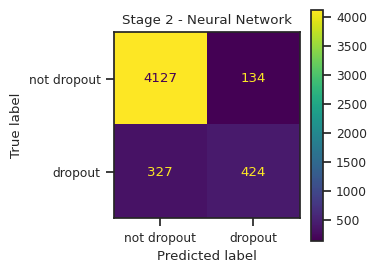

In [ ]:
evaluate_2_test = evaluate_nn(stage, X_test_2, y_test_2, best_nn_config_2, best_nn_model_2, class_labels)

Visulising the tuning process and how model's training and validation loss and metrics evolve across epochs

In [ ]:
%tensorboard --logdir "/content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/bests"

Feature importance and explainability with SHAP

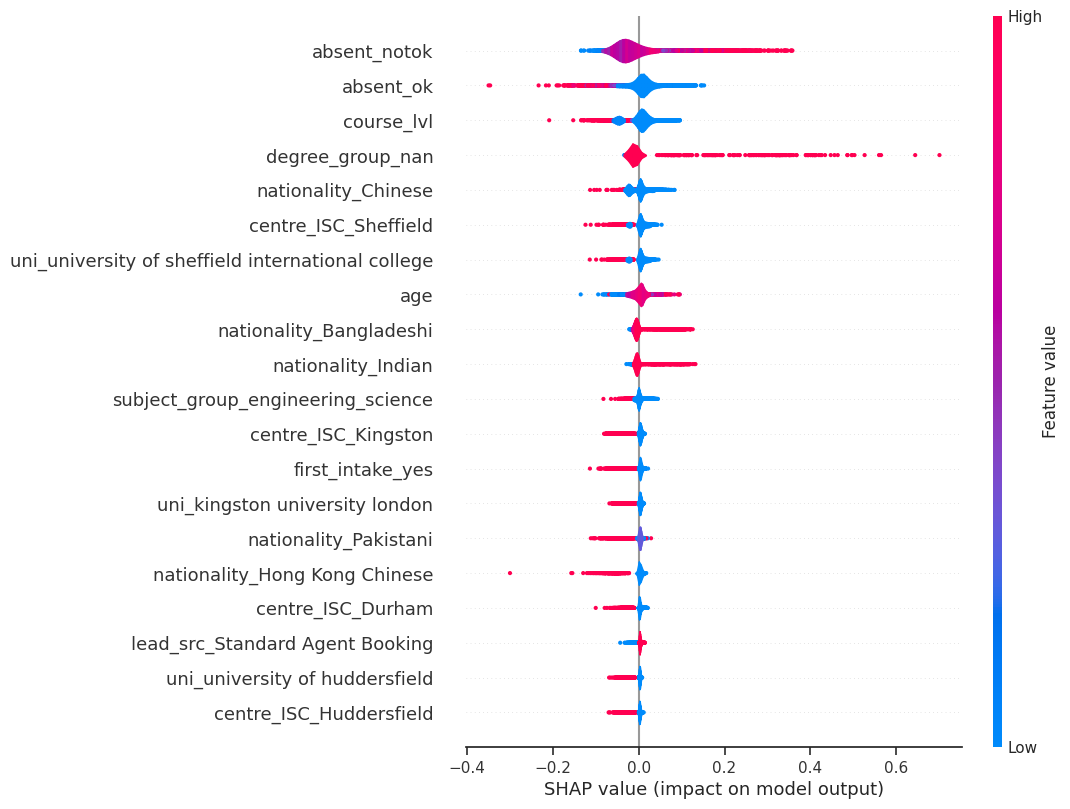

In [ ]:
features_2_nn = pipeline_2.named_steps["scaler_encoder"].get_feature_names_out()
cleaned_features_2_nn = [name.split("__")[-1] for name in features_2_nn]

# Choose a background dataset (reference)
num_rows = X_train_2.shape[0]
sample_indices = np.random.choice(
    num_rows,
    size=1000,
    replace=False,
)

# a small sample of the training data that serves as the baseline or expected value (E[f(x)])
background = X_train_2[sample_indices].astype(np.float32)

# Choose the SHAP Explainer
explainer = shap.DeepExplainer(best_nn_model_2, background)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test_2.astype(np.float32))

# Use the SHAP values for the positive class for binary classification
shap_values_positive_class = shap_values[:, :, 0]

# Violin plot for most important features
shap.plots.violin(
    shap_values_positive_class,
    X_test_2,
    feature_names=cleaned_features_2_nn,
    show=True
)


### 🔹 Insights

- After hyperparameter tuning, we observed a 4.6% increase in the main metric (PR-AUC: 0.72 >> 0.75).

- Among the remaining metrics, the most notable improvement was a 5.2% increase in Precision, and a 2.8% improvement in F1 score.


  - although the model's performance improved, the gain still may not be substantial enough to justify the computational cost of tuning;

  - neural networks are indeed powerful. Given the dataset's moderate complexity and sample size, even a relatively simple initial model was able to capture the underlying patterns and relationships effectively;

- Visual inspection of the loss curves in TensorBoard revealed no noticeable signs of overfitting.


- Features with the highest mean absolute SHAP values (importance) are as follows:

  - Learners with a high number of unauthorised absences and a low number of authorised absences are more prone to dropout.
  - Learners from China or Hong Kong have lower risk of dropout, while Bangladeshi and Indian learners show higher risk. The dropout risk for Pakistani learners is not clearly indicated in this plot.
  - The lower the course level, the higher the dropout risk.
  - Learners whose intended partner university is the University of Sheffield International College, Kingston University London, or Lancaster University are not at risk of dropout.
  - Learners based at ********** ISC Sheffield, ISC Durham, or ISC Kingston centres are not at risk of dropout.
  - Older learners have a higher risk of dropout.
  - Male learners have a higher risk of dropout.
  - Learners studying engineering or science are less prone to dropout.
  - Learners for whom this is the first intake for the course are less prone to dropout.
  - Learners who found out about the course via a sponsor are less at risk of dropout.
  - Learners with missing degree information form a large group with high dropout risk. This is worth investigating. There may be hidden structure or missing-not-at-random patterns here.





- The newly added features related to student engagement appear at the top, indicating that they are the most influential predictors. This is consistent with the 12.6% performance improvement observed in Stage 2 relative to Stage 1. The direction of their effects is fully aligned with the observations from the EDA.


## Stage 3

In [ ]:
stage = 3

Pre-processing Stage 3 data and preparing it for the neural network modelling

###  data pre-process

Pre-processing Stage 3 data and preparing it for the neural network modelling

In [ ]:
data_3 = raw_data_3.copy()

In [ ]:
data_3.shape

(25059, 21)

In [ ]:
# -------- Stage 3 variables --------

# All numeric features (including ordinal features)
numeric_features_3 = numeric_features_2 + ["pass_rate"]

# Features to be dropped after preprocessing
del_cols_3 = del_cols_2 + ["assessed", "passed", "failed"]

# Newly added features at Stage 3
added_cols_3 = added_cols_2 + ["AssessedModules", "PassedModules", "FailedModules"]

In [ ]:
modelling = "neural_network"

stage3_data = pre_modelling_prep(
    data_3, config,
    stage=stage,
    rename_dict=rename_dict,
    irr_cols=irr_cols,
    missing_cols=missing_cols,
    high_card_cols=high_card_cols,
    ordinal_map=ordinal_map,
    numeric_features=numeric_features_3,
    nominal_features=nominal_features,
    added_cols=added_cols_3,
    del_cols=del_cols_3,
    modelling=modelling)



# Access the results
X_train_3 = stage3_data["X_train"]
X_val_3 = stage3_data["X_val"]
X_test_3 = stage3_data["X_test"]
y_train_3 = stage3_data["y_train"]
y_val_3 = stage3_data["y_val"]
y_test_3 = stage3_data["y_test"]
pipeline_3 = stage3_data["pipeline"]

In [ ]:
print(X_train_3.shape, X_val_3.shape, X_test_3.shape, y_train_3.shape, y_val_3.shape, y_test_3.shape)

(18042, 197) (2005, 197) (5012, 197) (18042,) (2005,) (5012,)


### simple initial trial

Neural netwrok modelling using the initial simple configuration and Stage 3 data

In [ ]:
test_log_dir = f"{parent_log_dir}/models/intial_{stage}"
nn_training_3 = train_nn_model(stage, seed, X_train_3, y_train_3, X_val_3, y_val_3, nn_config, test_log_dir)


Epoch 1: val_pr_auc improved from -inf to 0.65369, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/models/intial_3/checkpoint/stage_3/best_model_val_pr_auc.keras

Epoch 2: val_pr_auc improved from 0.65369 to 0.67847, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/models/intial_3/checkpoint/stage_3/best_model_val_pr_auc.keras

Epoch 3: val_pr_auc improved from 0.67847 to 0.70383, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/models/intial_3/checkpoint/stage_3/best_model_val_pr_auc.keras

Epoch 4: val_pr_auc improved from 0.70383 to 0.71029, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/models/intial_3/checkpoint/stage_3/best_model_val_pr_auc.keras

Epoch 5: val_pr_auc improved from 0.71029 to 0.72392, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/m

In [ ]:
# Load the model
nn_model_dir = f"{parent_log_dir}/models/intial_{stage}/checkpoint/stage_{stage}/best_model_val_pr_auc.keras"
nn_model_3 = tf.keras.models.load_model(nn_model_dir)

In [ ]:
nn_model_3.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,373 (40.52 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,916 (27.02 KB)

Visulising the training process and how model's training and validation loss and metrics evolve across epochs

In [ ]:
%tensorboard --logdir "/content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/models"

Evaluating the model on the test data

Keras metrics  
Stage : 3 
Loss : 0.20901991426944733 
PR-AUC: 0.7876498699188232 
ROC-AUC: 0.9377886056900024 
Accuracy: 0.9177972674369812 
Precision: 0.7511110901832581 
Recall : 0.6750998497009277 
F1: 0.2606281340122223 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold-independent metrics  
Stage3
pr-auc: 0.7880450379329702 
roc-auc: 0.9390316158288206 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage3
accuracy: 0.9177972865123704 
precision: 0.7511111111111111 
recall: 0.6750998668442078 
f1: 0.7110799438990182 



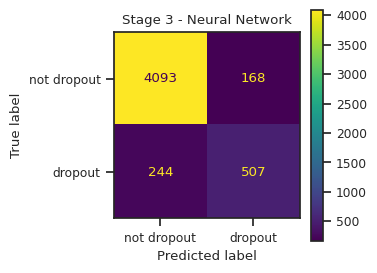

In [ ]:
evaluate_3_test = evaluate_nn(stage, X_test_3, y_test_3, nn_config, nn_model_3, class_labels)

### 🔹 Insights
- The training was successfully halted before overtraining occurred.

- The performance of the simple initial neural network model is quite decent.
For an imbalanced dataset, the baseline PR-AUC corresponds to the Prevalence, in this case: 0.15.

- The model achieved a PR-AUC of 0.79, showing that even a relatively simple initial network was able to capture the underlying patterns and relationships effectively.


- Since the configuration of the initial models is identical across Stage 2 and Stage 3, we can conclude that the improvement in model performance from Stage 2 (0.72) to Stage 3 (0.79) is solely due to the addition of valuable data. This finding suggests that academic performance data enhances the predictive power of the model.


- The ROC-AUC (0.94) exceeds 0.5 (whcih corresponds to the performance of a random classifier). This confirms the model's acceptable discriminative ability. As expected, the accuracy metric is relatively high and provides an inflated estimate of the model's actual performance.

### hyperparameter tuning

Hyperparameter tuning and saving the best hyperparameters

In [ ]:
# stage = 3
# config_0 = dict(config)
# nn_config = config_0["model_params"]["neural_network"]
# tuning_log_dir = f"{parent_log_dir}/tuning/stage_{stage}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
# tuner_3 = hp_tuner(stage, seed, build_wrapper, nn_config, X_train_3, y_train_3, X_val_3, y_val_3, tuning_log_dir, True) # Change the True to False to load the already existing results

Retrieving the hyperparameter tuning results

In [ ]:
stage = 3
config_0 = dict(config)
nn_config = config_0["model_params"]["neural_network"]
directory = f"{parent_log_dir}/tuning/stage_{stage}_20251109-154254"
tuner_3 = hp_tuner(stage, seed, build_wrapper, nn_config, X_train_3, y_train_3, X_val_3, y_val_3, directory, False)

Reloading Tuner from /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/tuning/stage_3_20251109-154254/nn_tuning_grid_3/tuner0.json


Visulising the training process and how model's training and validation loss and metrics evolve across epochs

In [ ]:
%tensorboard --logdir "/content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/tuning/stage_3_20251109-154254"

Best configuration based on the hyperparameter tuning results

In [ ]:
nn_tuning_3 = best_nn_hp(tuner_3, nn_param_grid, nn_config)
best_nn_config_3 = nn_tuning_3["best_nn_config"]

Best hyperparameters:
Hidden activation: relu
Optimizer: adam
Learning rate: 0.001
Number of neurons: [256, 64, 1]



In [ ]:
best_nn_config_3

{'api': 'sequential',
 'layer': 'dense',
 'n_neuron': [256, 64, 1],
 'hidden_activation': 'relu',
 'output_activation': 'sigmoid',
 'dropout_rate': 0.5,
 'optimizer': 'adam',
 'learning_rate': 0.001,
 'loss': 'binary_crossentropy',
 'metrics': [<BinaryAccuracy name=accuracy>,
  <Precision name=precision>,
  <Recall name=recall>,
  <F1Score name=f1_score>,
  <AUC name=roc_auc>,
  <AUC name=pr_auc>],
 'decision_threshold': 0.5,
 'epochs': 50,
 'batch_size': 32,
 'early_stoppying_monitor': 'val_loss',
 'patience': 5,
 'checkpoint_monitor': {'loss': ['val_loss', 'min'],
  'accuracy': ['val_accuracy', 'max'],
  'pr_auc': ['val_pr_auc', 'max']},
 'tuner_objective': <keras_tuner.src.engine.objective.Objective at 0x7c2f2277ef60>}

Training the model using the best configuration

In [ ]:
best_log_dir = f"{parent_log_dir}/bests/best_{stage}"
best_nn_training_3 = train_nn_model(stage, seed, X_train_3, y_train_3, X_val_3, y_val_3, best_nn_config_3, best_log_dir)


Epoch 1: val_pr_auc improved from -inf to 0.75189, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/bests/best_3/checkpoint/stage_3/best_model_val_pr_auc.keras

Epoch 2: val_pr_auc improved from 0.75189 to 0.78230, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/bests/best_3/checkpoint/stage_3/best_model_val_pr_auc.keras

Epoch 3: val_pr_auc improved from 0.78230 to 0.78958, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/bests/best_3/checkpoint/stage_3/best_model_val_pr_auc.keras

Epoch 4: val_pr_auc improved from 0.78958 to 0.79631, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/bests/best_3/checkpoint/stage_3/best_model_val_pr_auc.keras

Epoch 5: val_pr_auc improved from 0.79631 to 0.80144, saving model to /content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/bests/best_3/

In [ ]:
# Load the model
best_nn_model_dir = best_log_dir + f"/checkpoint/stage_{stage}/best_model_val_pr_auc.keras"
best_nn_model_3 = tf.keras.models.load_model(best_nn_model_dir)

Evaluating the model on the test data

Keras metrics  
Stage : 3 
Loss : 0.1879618912935257 
PR-AUC: 0.8283290266990662 
ROC-AUC: 0.946797251701355 
Accuracy: 0.9259776473045349 
Precision: 0.8209459185600281 
Recall : 0.6471371650695801 
F1: 0.2606281340122223 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold-independent metrics  
Stage3
pr-auc: 0.8287378153405819 
roc-auc: 0.9483622087549075 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage3
accuracy: 0.9259776536312849 
precision: 0.8209459459459459 
recall: 0.6471371504660453 
f1: 0.723752792256143 



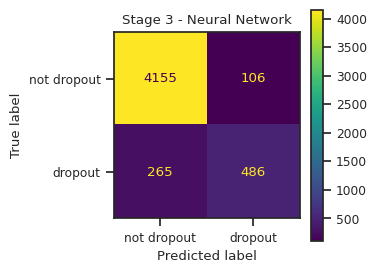

In [ ]:
evaluate_3_test = evaluate_nn(stage, X_test_3, y_test_3, best_nn_config_3, best_nn_model_3, class_labels)

Visulising the training process and how model's training and validation loss and metrics evolve across epochs

In [ ]:
%tensorboard --logdir "/content/drive/My Drive/Career Accelerator/Course_2/assignments/mini_project_3/bests"

Feature importance and explainability with SHAP

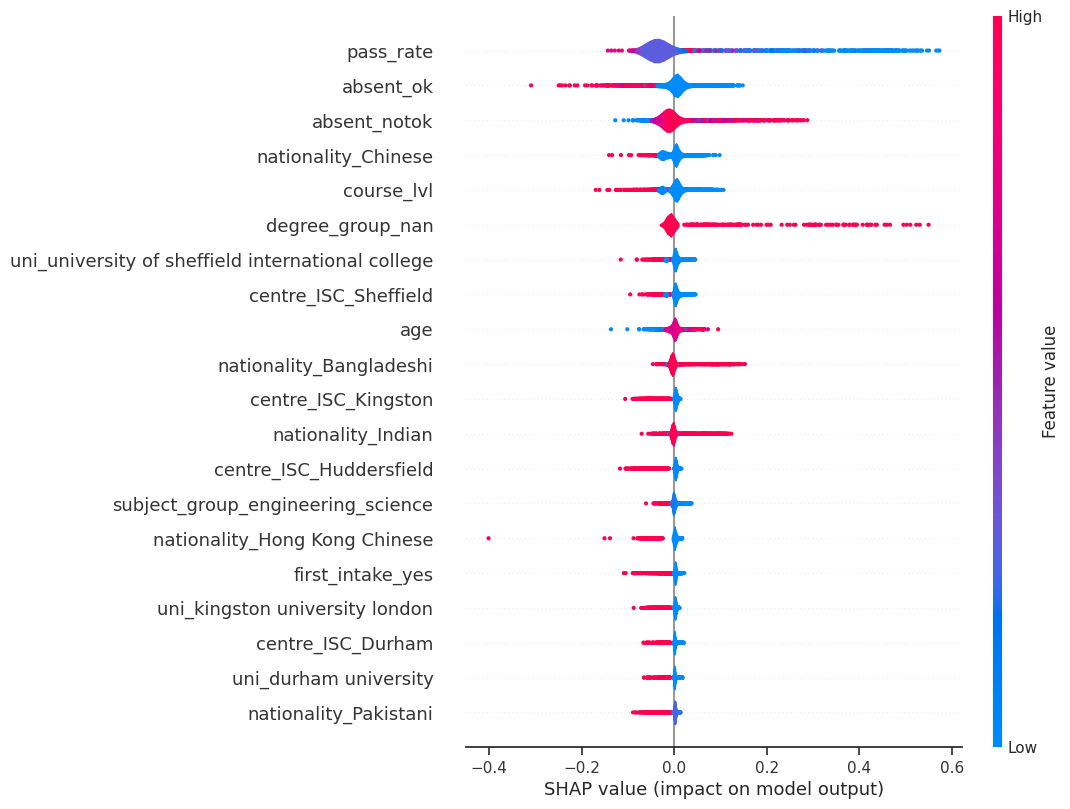

In [ ]:
features_3_nn = pipeline_3.named_steps["scaler_encoder"].get_feature_names_out()
cleaned_features_3_nn = [name.split("__")[-1] for name in features_3_nn]

# Choose a background dataset (reference)
num_rows = X_train_3.shape[0]
sample_indices = np.random.choice(
    num_rows,
    size=1000,
    replace=False,
)

# a small sample of the training data that serves as the baseline or expected value (E[f(x)])
background = X_train_3[sample_indices].astype(np.float32)

# Choose the SHAP Explainer
explainer = shap.DeepExplainer(best_nn_model_3, background)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test_3.astype(np.float32))

# Use the SHAP values for the positive class for binary classification
shap_values_positive_class = shap_values[:, :, 0]

# Violin plot for most important features
shap.plots.violin(
    shap_values_positive_class,
    X_test_3,
    feature_names=cleaned_features_3_nn,
    show=True
)



### 🔹 Insights

- After hyperparameter tuning, we observed a 4.9% increase in the main metric (PR-AUC: 0.79 >> 0.83).

- Among the remaining metrics, we observed an 8% increase in Precision and a 1.9% decrease in Recall. This opposite directional change is expected, as improving Precision often comes at the cost of reduced Recall.

  - although the model's performance improved, the gain may still not be substantial enough to justify the computational cost of tuning;

  - neural networks are indeed powerful. Given the dataset's moderate complexity and sample size, even a relatively simple initial model was able to capture the underlying patterns and relationships effectively;


- Visual inspection of the loss curves in TensorBoard revealed no noticeable signs of overfitting.



- Features with the highest mean absolute SHAP values (importance) are as follows:

  - Learners with low pass rate have higher risk of dropout.
  - Learners with a high number of unauthorised absences and a low number of authorised absences are more prone to dropout.
  - The lower the course level, the higher the dropout risk.
  - Learners based at ********** ISC Sheffield, ISC Kingston, ISC Huddersfield, or ISC Durham centres are not at risk of dropout.
  - Learners whose intended partner university is the University of Sheffield International College, Kingston University London, or Durham University are not at risk of dropout.
  - Learners from China, Hong Kong, or Pakistan have lower risk of dropout. The dropout risk for Bangladeshi or Indian learners is not clearly indicated in this plot.
  - Older learners have a higher risk of dropout.
  - Learners studying engineering or science are less prone to dropout.
  - Learners for whom this is the first intake for the course are less prone to dropout.
  - Learners with missing degree information form a large group with high dropout risk. This is worth investigating. There may be hidden structure or missing-not-at-random patterns here.





- The newly added feature related to academic performance appear at the top, indicating that it is the most influential predictor. This is consistent with the 10.1% performance improvement observed in Stage 3 relative to Stage 2. The direction of their effects is fully aligned with the observations from the EDA.






## Comparing Stage 1, 2, 3

Keras metrics  
Stage : 1 
Loss : 0.26244163513183594 
PR-AUC: 0.6631826162338257 
ROC-AUC: 0.8936715126037598 
Accuracy: 0.8916600346565247 
Precision: 0.6661341786384583 
Recall : 0.555259644985199 
F1: 0.2606281340122223 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold-independent metrics  
Stage1
pr-auc: 0.6625937877109691 
roc-auc: 0.8936569280543097 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage1
accuracy: 0.891660015961692 
precision: 0.6661341853035144 
recall: 0.5552596537949401 
f1: 0.6056644880174292 

Keras metrics  
Stage : 2 
Loss : 0.2367331087589264 
PR-AUC: 0.7188225984573364 
ROC-AUC: 0.9185606241226196 
Accuracy: 0.9048284292221069 
Precision: 0.7362068891525269 
Recall : 0.5685752034187317 
F1: 0.2606281340122223 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Threshold-independent metrics  
Stage2
pr-auc: 0.7190579361583032 
roc-auc: 0.9190718406905477 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage2
accuracy: 0.9048284118116521 
preci

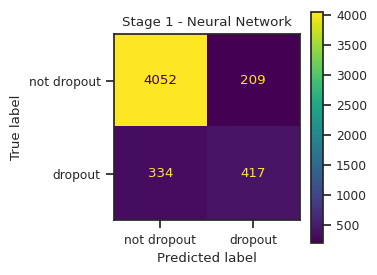

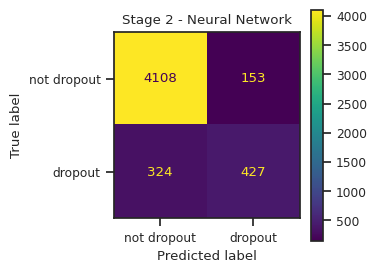

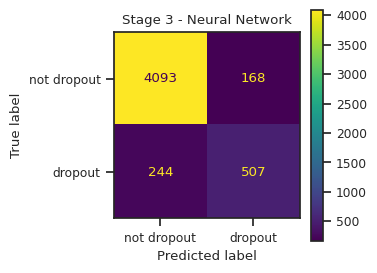

In [ ]:
n_stages = 3
modelling = "neural_network"
X_tests = [X_test_1, X_test_2, X_test_3]
y_tests = [y_test_1, y_test_2, y_test_3]
initial_nn_models = [nn_model_1, nn_model_2, nn_model_3]
initial_nn_configs = [nn_config, nn_config, nn_config]

all_initial_results_nn = all_stages(n_stages, X_tests, y_tests, initial_nn_configs, initial_nn_models, class_labels, modelling)

Performance results of the initial model for each Stage

In [ ]:
pd.DataFrame(all_initial_results_nn)

,evaluate_1,evaluate_2,evaluate_3
pr_auc,0.66,0.72,0.79
roc_auc,0.89,0.92,0.94
accuracy,0.89,0.90,0.92
precision,0.67,0.74,0.75
recall,0.56,0.57,0.68
f1,0.61,0.64,0.71


### 🔹 Insights (initial models)

Since the configuration of the initial models is identical across all Stages, we can conclude that the improvement in model performance from Stage 1 to Stage 3 is solely due to the addition of valuable data.

- The addition of student engagement improved the model's PR-AUC by 9.1%. It increased Precision by 7.5% while it reduced Recall by 3.4%.  
Including academic performance further improved PR-AUC by 9.7%, Precision by 5.6%, and Recall by 17.9%, reflecting its strength in predicting true dropout cases successfully.

- These findings indicate that both academic performance and student engagement serve as influential distinguishing factors, contributing predictive value beyond demographic and course-related features.

- As expected, Accuracy of all Stages is relatively high providing an inflated estimate of the model's actual performance.

Performance results of the best model for each Stage

Keras metrics  
Stage : 1 
Loss : 0.258349746465683 
PR-AUC: 0.6675971746444702 
ROC-AUC: 0.8955680131912231 
Accuracy: 0.8954508900642395 
Precision: 0.6748844385147095 
Recall : 0.5832223892211914 
F1: 0.2606281340122223 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold-independent metrics  
Stage1
pr-auc: 0.6685350315031227 
roc-auc: 0.8955956713898794 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage1
accuracy: 0.8954509177972865 
precision: 0.674884437596302 
recall: 0.5832223701731025 
f1: 0.6257142857142857 

Keras metrics  
Stage : 2 
Loss : 0.22747033834457397 
PR-AUC: 0.7527367472648621 
ROC-AUC: 0.9249436855316162 
Accuracy: 0.9080207347869873 
Precision: 0.759856641292572 
Recall : 0.5645805597305298 
F1: 0.2606281340122223 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold-independent metrics  
Stage2
pr-auc: 0.752858909852906 
roc-auc: 0.9250154140095141 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage2
accuracy: 0.9080207501995211 
precisi

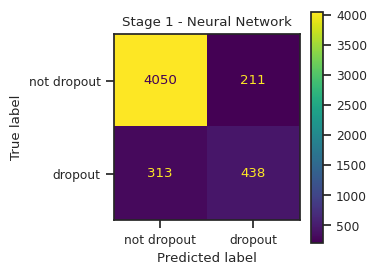

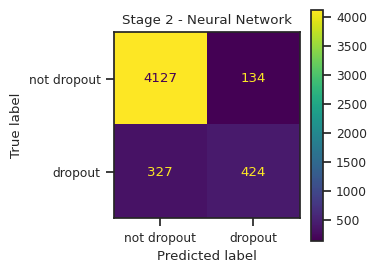

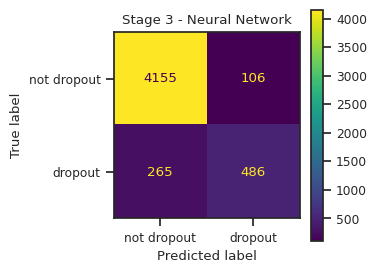

In [ ]:
n_stages = 3
modelling = "neural_network"
X_tests = [X_test_1, X_test_2, X_test_3]
y_tests = [y_test_1, y_test_2, y_test_3]
best_nn_models = [best_nn_model_1, best_nn_model_2, best_nn_model_3]
best_nn_configs = [best_nn_config_1, best_nn_config_2, best_nn_config_3]

all_best_results_nn = all_stages(n_stages, X_tests, y_tests, best_nn_configs, best_nn_models, class_labels, modelling)

In [ ]:
pd.DataFrame(all_best_results_nn)

,evaluate_1,evaluate_2,evaluate_3
pr_auc,0.67,0.75,0.83
roc_auc,0.90,0.93,0.95
accuracy,0.90,0.91,0.93
precision,0.67,0.76,0.82
recall,0.58,0.56,0.65
f1,0.63,0.65,0.72


### 🔹 Insights (best models)

Surprisingly, the tuning process arrived at the same model configuration across all Stages. Therefore, we can conclude that the improvement in tunned model performance from Stage 1 to Stage 3 is solely due to the addition of valuable data.

- The addition of student engagement improved the model's PR-AUC by 12.6%. It increased Precision by 12.6% while it reduced Recall by 3.2%.  
Including academic performance further improved PR-AUC by 10.1%, Precision by 8%, and Recall by 14.6%, reflecting its strength in predicting true dropout cases successfully.

- These findings are consistent with the initial simple models, both demonstrating that academic performance and student engagement function as major distinguishing factors that add predictive value beyond demographic and course-related features.


- Overal, the Stage 3 model outperforms all others and delivers the best overall result (catching the most dropouts)
  - The model is robust at separating the small dropout class from the large non-dropout class (PR-AUC: 0.83).
  - 82% of the times the detected dropout case is correctly detected (Precision: 0.82).
  - It is able to detect 65% of all actual dropout cases (Recall: 0.65).
  - With F1 score of 0.72 sitting between Precision (0.82) and Recall (0.65), the model offers a highly effective compromise.




- As expected, Accuracy of all Stages is relatively high providing an inflated estimate of the model's actual performance.





# 🌳 XGBoost

In [ ]:
modelling = "xgboost"

The XGBoost was trained on the training data, monitored on the validation data, and evaluated on the test data.

In [ ]:
config_0 = dict(config)
xgb_config = config_0["model_params"]["xgboost"]
xgb_config

{'objective': 'binary:logistic',
 'enable_categorical': True,
 'max_depth': 5,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'eval_metric': ['logloss', 'aucpr', 'auc'],
 'scoring': {'accuracy': 'accuracy',
  'precision': 'precision',
  'recall': 'recall',
  'f1': 'f1',
  'roc_auc': 'roc_auc',
  'pr_auc': 'average_precision'},
 'decision_threshold': 0.5,
 'cross_validation': 'custom_split',
 'refit': 'pr_auc'}

Above **configuration** provides the initial set of hyperparameters required for the XGBoost model:

- The model is configured with the "binary:logistic" objective to get the output as a probability between 0 and 1 (non-dropout vs. dropout).


- Categorical handling is enabled ("enable_categorical": True), allowing the model to process categorical features itself, without the need for one-hot encoding prior to the modelling.

- The model will build 100 decision trees sequentially.

- The maximum depth of each individual tree is limited to 5, a moderate setting chosen to prevent initial overfitting.

- The learning rate is set to 0.1, a balanced pace of learning to start with.

- During internal training, the model tracks multiple evaluation metrics, including logloss, aucpr (PR-AUC), and auc (ROC-AUC).

- A comprehensive set of performance scores will be monitored during tuning as accuracy alone would be misleading on the imbalanced data involved in this project.

  - the threshold-dependent metrics: accuracy, precision, recall, F1 score   
  For the threshold-independent metrics the decision threshold is set to 0.5, meaning any predicted probability greater than 0.5 is classified as a positive outcome (dropout). 0.5 is the standard default threshold used as a neutral starting point. However, it can be potentially adjusted based on the specific business trade-off between precision and recall.
  - the threshold-independent metrics: ROC-AUC, and PR-AUC

- The hyperparameter tuning process will select the best model based on maximising the PR-AUC , which is the most reliable metric for imbalanced data.

- With the custom split strategy for cross validation the evaluation process uses the pre-defined train/validation split created during data preparation. This maintains consistency and prevents data leakage during tuning.


For **hyperparameter tuning**

- learning rate
- max depth
- number of estimators


The model was tuned using an exhaustive Grid Search across all possible combinations of hyperparameter values.

During hyperparameter optimisation, the best model was selected based on the highest validation PR-AUC. PR-AUC was chosen as the optimisation metric because it is highly sensitive to performance on the minority class, making it the most appropriate metric for tuning models in imbalanced classification tasks such as dropout prediction.

Defining the hyperparameter space for tuning

In [ ]:
# Define parameter grid for hyperparameter tuning
xgb_param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [50, 100, 200, 300]
}

## Stage 1

In [ ]:
stage = 1

###  data pre-process

Pre-processing Stage 1 data and preparing it for the XGBoost modelling

In [ ]:
modelling = "xgboost"

In [ ]:
data_1 = raw_data_1.copy()

In [ ]:
# -------- Stage 1 variables --------

# All numeric features (including ordinal features)
numeric_features_1 = ["course_lvl", "age"]

# Features to be dropped after feature engineering
del_cols_1 = ["course_name", "degree"]

In [ ]:
modelling = "xgboost"

stage1_data = pre_modelling_prep(
    data_1, config,
    stage=stage,
    rename_dict=rename_dict,
    irr_cols=irr_cols,
    missing_cols=missing_cols,
    high_card_cols=high_card_cols,
    ordinal_map=ordinal_map,
    numeric_features=numeric_features_1,
    nominal_features=nominal_features,
    added_cols=None,
    del_cols=del_cols_1,
    modelling=modelling
)


# Access the results
X_train_1 = stage1_data["X_train"]
X_val_1 = stage1_data["X_val"]
X_test_1 = stage1_data["X_test"]
y_train_1 = stage1_data["y_train"]
y_val_1 = stage1_data["y_val"]
y_test_1 = stage1_data["y_test"]
pipeline_1 = stage1_data["pipeline"]

In [ ]:
print(X_train_1.shape, X_val_1.shape, X_test_1.shape, y_train_1.shape, y_val_1.shape, y_test_1.shape)

(18042, 11) (2005, 11) (5012, 11) (18042,) (2005,) (5012,)


In [ ]:
pipeline_1.named_steps["cleaner"].get_feature_names_out()

array(['centre', 'booking_type', 'lead_src', 'gender', 'nationality',
       'course_lvl', 'first_intake', 'uni', 'age', 'subject_group',
       'degree_group'], dtype='<U13')

In [ ]:
pipeline_1.named_steps["ordinal_encoder"].get_feature_names_out()

array(['centre', 'booking_type', 'lead_src', 'gender', 'nationality',
       'course_lvl', 'first_intake', 'uni', 'age', 'subject_group',
       'degree_group'], dtype='<U13')

In [ ]:
X_train_1.dtypes

,0
centre,category
booking_type,category
lead_src,category
gender,category
nationality,category
course_lvl,category
first_intake,category
uni,category
age,int32
subject_group,category


### simple initial trial

XGBoost modelling using the initial simple configuration and Stage 1 data

In [ ]:
xgb_model_1 = train_xgb_model(stage, seed, X_train_1, y_train_1, X_val_1, y_val_1, xgb_config)

Evaluating the model on the test data

Threshold-independent metrics  
Stage 1
pr-auc: 0.46396757548571327 
roc-auc: 0.7697878226043599 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 1
accuracy: 0.8976456504389465 
precision: 0.6847826086956522 
recall: 0.5872170439414115 
f1: 0.632258064516129 



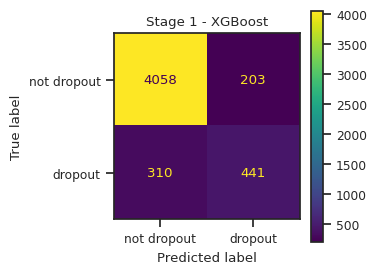

In [ ]:
evaluate_1_test = evaluate_xgb(stage, X_test_1, y_test_1, xgb_config, xgb_model_1, class_labels)

Since we haven't implemented any preventative measures against overfitting, the model may overfit. We should check by comparing the training and validation metrics. If the key metric (PR-AUC) is substantially higher on the training set than on the validation set, it indicates poor generalisation and confirms that the model has overfit by memorising the training data.

If both metrics are low and close to each other, the model is underfitting, meaning it is either too simple or hasn't been trained sufficiently to capture the underlying patterns in the data.

Threshold-independent metrics  
Stage 1
pr-auc: 0.5118964156093554 
roc-auc: 0.790479303877395 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 1
accuracy: 0.9093226914976167 
precision: 0.7330712101354303 
recall: 0.6207917129115798 
f1: 0.6722756410256411 



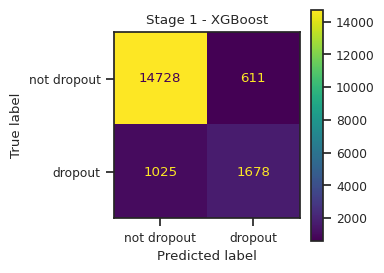

In [ ]:
evaluate_1_train = evaluate_xgb(stage, X_train_1, y_train_1, xgb_config, xgb_model_1, class_labels)

Threshold-independent metrics  
Stage 1
pr-auc: 0.45590757619226274 
roc-auc: 0.7512316715542522 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 1
accuracy: 0.8992518703241895 
precision: 0.7168141592920354 
recall: 0.54 
f1: 0.6159695817490495 



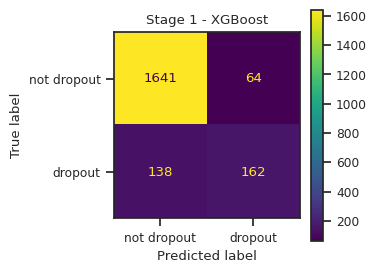

In [ ]:
evaluate_1_val = evaluate_xgb(stage, X_val_1, y_val_1, xgb_config, xgb_model_1, class_labels)

Extracting feature importance from an the best model

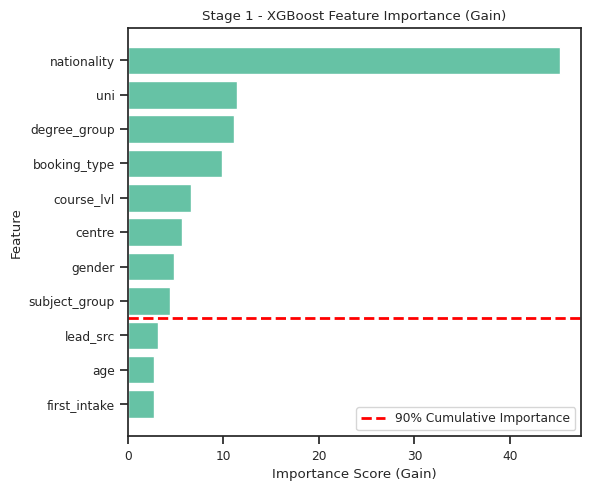

In [ ]:
feature_imp_1 = feature_imp_xgb(stage, xgb_model_1)

In [ ]:
feature_imp_1.sort_values("importance", ascending=False).reset_index(drop=True)

,feature,importance,percentage_imp,cumulative_imp
0,nationality,45.21,41.99,41.99
1,uni,11.40,10.59,52.58
2,degree_group,11.09,10.30,62.88
3,booking_type,9.81,9.11,71.99
4,course_lvl,6.62,6.15,78.14
5,centre,5.61,5.21,83.35
6,gender,4.84,4.50,87.85
7,subject_group,4.43,4.12,91.96
8,lead_src,3.19,2.96,94.92
9,age,2.75,2.55,97.47


◼ The default decision threshold of 0.5 is unreliable for our imbalanced dataset, as it often leads to poor Recall (missing dropout cases). Therefore, we focus our analysis on threshold-independent metrics like **PR-AUC** (Precision-Recall Area Under the Curve) and ROC-AUC (Receiver Operating Characteristic Area Under the Curve). These metrics evaluate the model's performance across all possible cutoffs, providing a robust measure of its ability to distinguish dropouts from non-dropouts, regardless of any single, arbitrary threshold.

### 🔹 Insights

- Since the training and validation metrics are close (with the training metric still slightly higher, which is normal), we can conclude that the model is generalising well and there is no sign of overfitting.


  


- With a PR-AUC of 0.46 (well above the baseline of 0.15, the Prevalence) and a ROC-AUC of 0.77 (well above the random model baseline of 0.5), we can conclude that the simple initial XGBoost model performs acceptably, showing no signs of underfitting.

- The cumulative feature importance would be a more effective way to report feature importance rather than simple raw rankings.

- The features responsible for 90% of the total predictive gain of the XGBoost model:
  - nationality
  - university
  - degree
  - booking type
  - course level
  - centre
  - gender
  - subject    
  Most of these features showed a strong association with the dropout outcome during the EDA step.

### hyperparameter tuning

In [ ]:
xgb_tuning_1 = best_xgb_model(stage, seed, X_train_1, y_train_1, X_val_1, y_val_1, nominal_features, xgb_param_grid, xgb_config)

Stage : 1 
Validation PR-AUC: 0.6346805084770459 
Validation ROC-AUC: 0.874227761485826 
Validation Accuracy: 0.9007481296758105 
Validation Precision: 0.7186147186147186 
Validation Recall: 0.5533333333333333 
Validation F1 Score: 0.6252354048964218 

Best hyperparameters:
Max depth: 3
Learning rate: 0.2
Number of estimators: 200



 Saving the best hyperparameters & the best model

In [ ]:
best_xgb_model_1 = xgb_tuning_1["best_xgb_model"]
best_xgb_hp_1 = xgb_tuning_1["best_xgb_hp"]
best_xgb_score_1 = xgb_tuning_1["best_xgb_score"]
best_xgb_config_1 = xgb_tuning_1["best_xgb_config"]
best_xgb_config_1

{'objective': 'binary:logistic',
 'enable_categorical': True,
 'max_depth': 3,
 'learning_rate': 0.2,
 'n_estimators': 200,
 'eval_metric': ['logloss', 'aucpr', 'auc'],
 'scoring': {'accuracy': 'accuracy',
  'precision': 'precision',
  'recall': 'recall',
  'f1': 'f1',
  'roc_auc': 'roc_auc',
  'pr_auc': 'average_precision'},
 'decision_threshold': 0.5,
 'cross_validation': 'custom_split',
 'refit': 'pr_auc'}

Evaluating the model on the test data

Threshold-independent metrics  
Stage 1
pr-auc: 0.4754718235613563 
roc-auc: 0.7786393546772182 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 1
accuracy: 0.8996408619313647 
precision: 0.6873111782477341 
recall: 0.6058588548601864 
f1: 0.6440198159943383 



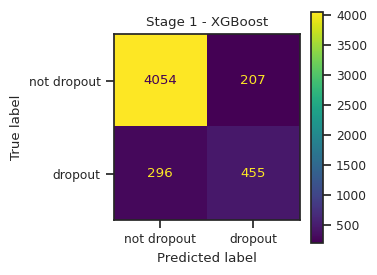

In [ ]:
evaluate_1_test = evaluate_xgb(stage, X_test_1, y_test_1, best_xgb_config_1, best_xgb_model_1, class_labels)

Since we haven't implemented any preventative measures against overfitting, the model may overfit. We should check by comparing the training and validation metrics. If the key metric (PR-AUC) is substantially higher on the training set than on the validation set, it indicates poor generalisation and confirms that the model has overfit by memorising the training data.

If both metrics are low and close to each other, the model is underfitting, meaning it is either too simple or hasn't been trained sufficiently to capture the underlying patterns in the data.

Threshold-independent metrics  
Stage 1
pr-auc: 0.5086609617276917 
roc-auc: 0.7895332051319064 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 1
accuracy: 0.9084912980822525 
precision: 0.7288946910356832 
recall: 0.6196818349981502 
f1: 0.669866026794641 



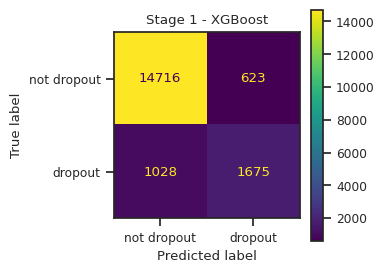

In [ ]:
evaluate_1_train= evaluate_xgb(stage, X_train_1, y_train_1, best_xgb_config_1, best_xgb_model_1, class_labels)

Threshold-independent metrics  
Stage 1
pr-auc: 0.48266533237721143 
roc-auc: 0.7668181818181817 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 1
accuracy: 0.9047381546134663 
precision: 0.7339055793991416 
recall: 0.57 
f1: 0.6416510318949343 



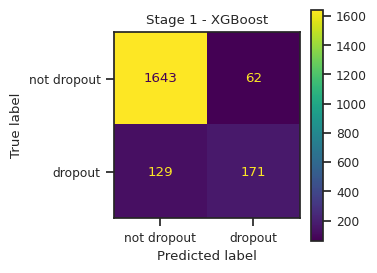

In [ ]:
evaluate_1_val = evaluate_xgb(stage, X_val_1, y_val_1, best_xgb_config_1, best_xgb_model_1, class_labels)

 Extracting feature importance from the best model

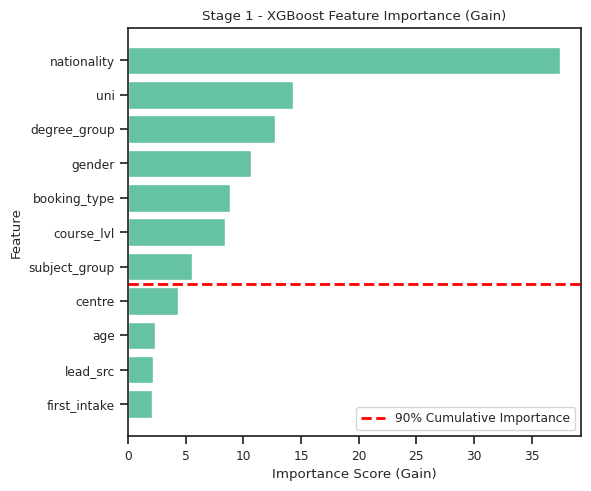

In [ ]:
feature_imp_1 = feature_imp_xgb(stage, best_xgb_model_1)

In [ ]:
feature_imp_1.sort_values("importance", ascending=False).reset_index(drop=True)

,feature,importance,percentage_imp,cumulative_imp
0,nationality,37.41,34.36,34.36
1,uni,14.32,13.15,47.51
2,degree_group,12.78,11.74,59.25
3,gender,10.65,9.78,69.02
4,booking_type,8.84,8.11,77.14
5,course_lvl,8.45,7.76,84.90
6,subject_group,5.59,5.13,90.04
7,centre,4.31,3.96,93.99
8,age,2.32,2.13,96.12
9,lead_src,2.18,2.00,98.12


### 🔹 Insights

- After hyperparameter tuning, only a slight increase was observed in the key metric (PR-AUC: 0.46 >> 0.48). The remaining metrics also showed only marginal improvements, if at all.

- This minimal improvement is likely because the dataset is not massive, and the relationship between the features and the target variable is not overly complex.  Therefore, even a relatively simple initial model was able to capture the underlying patterns and relationships effectively.

- Since the training and validation metrics are close (with the training metric still slightly higher, which is normal), we can conclude that the model is generalising well and there is no sign of overfitting.

- With a PR-AUC of 0.48 (well above the baseline of 0.15, the Prevalence) and a ROC-AUC of 0.78 (well above the random model baseline of 0.5), we can conclude that the simple initial XGBoost model performs acceptably, showing no signs of underfitting.


- The features responsible for 90% of the total predictive gain of the XGBoost model:
  - nationality
  - university
  - degree
  - **gender**
  - booking type
  - course level
  - subject

  *gender* displaced *centre* out of the most important list.  
  Most of these features showed a strong association with the dropout outcome during the EDA step.

    
- Although the model's negligible performance improvement may not justify the computational cost of tuning, the hyperparameter tuning was structurally beneficial. The best model now has a more broadly distributed predictive weight across the features. Such a shift can create a better-generalising model that is less reliant on a single dominant feature. This increases model stability and robustness.

## Stage 2

In [ ]:
stage = 2

###  data pre-process

Pre-processing Stage 2 data and preparing it for the XGBoost modelling

In [ ]:
data_2 = raw_data_2.copy()

In [ ]:
# -------- Stage 2 variables --------

# All numeric features (including ordinal features)
numeric_features_2 = numeric_features_1 + ["absent_ok", "absent_notok"]

# Features to be dropped after preprocessing
del_cols_2 = del_cols_1

# Newly added features at Stage 2
added_cols_2 = ["AuthorisedAbsenceCount", "UnauthorisedAbsenceCount"]

In [ ]:
modelling = "xgboost"

stage2_data = pre_modelling_prep(
    data_2, config,
    stage=stage,
    rename_dict=rename_dict,
    irr_cols=irr_cols,
    missing_cols=missing_cols,
    high_card_cols=high_card_cols,
    ordinal_map=ordinal_map,
    numeric_features=numeric_features_2,
    nominal_features=nominal_features,
    added_cols=added_cols_2,
    del_cols=del_cols_2,
    modelling=modelling)


# Access the results
X_train_2 = stage2_data["X_train"]
X_val_2 = stage2_data["X_val"]
X_test_2 = stage2_data["X_test"]
y_train_2 = stage2_data["y_train"]
y_val_2 = stage2_data["y_val"]
y_test_2 = stage2_data["y_test"]
pipeline_2 = stage2_data["pipeline"]

In [ ]:
print(X_train_2.shape, X_val_2.shape, X_test_2.shape, y_train_2.shape, y_val_2.shape, y_test_2.shape)

(18042, 13) (2005, 13) (5012, 13) (18042,) (2005,) (5012,)


In [ ]:
pipeline_2.named_steps["cleaner"].get_feature_names_out()

array(['centre', 'booking_type', 'lead_src', 'gender', 'nationality',
       'course_lvl', 'first_intake', 'uni', 'absent_ok', 'absent_notok',
       'age', 'subject_group', 'degree_group'], dtype='<U13')

In [ ]:
pipeline_2.named_steps["ordinal_encoder"].get_feature_names_out()

array(['centre', 'booking_type', 'lead_src', 'gender', 'nationality',
       'course_lvl', 'first_intake', 'uni', 'absent_ok', 'absent_notok',
       'age', 'subject_group', 'degree_group'], dtype='<U13')

### simple initial trial

XGBoost modelling using the initial simple configuration and Stage 2 data

In [ ]:
xgb_model_2 = train_xgb_model(stage, seed, X_train_2, y_train_2, X_val_2, y_val_2, xgb_config)

Evaluating the model on the test data

Threshold-independent metrics  
Stage 2
pr-auc: 0.5221318986246923 
roc-auc: 0.7984903801893182 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 2
accuracy: 0.9110135674381484 
precision: 0.7335375191424196 
recall: 0.6378162450066578 
f1: 0.6823361823361823 



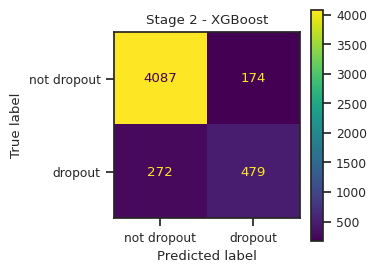

In [ ]:
evaluate_2_test = evaluate_xgb(stage, X_test_2, y_test_2, xgb_config, xgb_model_2, class_labels)

Since we haven't implemented any preventative measures against overfitting, the model may overfit. We should check by comparing the training and validation metrics. If the key metric (PR-AUC) is substantially higher on the training set than on the validation set, it indicates poor generalisation and confirms that the model has overfit by memorising the training data.

If both metrics are low and close to each other, the model is underfitting, meaning it is either too simple or hasn't been trained sufficiently to capture the underlying patterns in the data.

Threshold-independent metrics  
Stage 2
pr-auc: 0.6070736351626123 
roc-auc: 0.8313950446870755 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 2
accuracy: 0.9296641170601929 
precision: 0.8114682884448305 
recall: 0.6910839807621162 
f1: 0.7464535464535464 



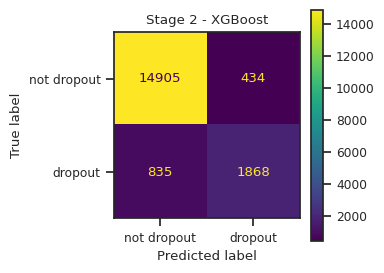

In [ ]:
evaluate_2_train = evaluate_xgb(stage, X_train_2, y_train_2, xgb_config, xgb_model_2, class_labels)

Threshold-independent metrics  
Stage 2
pr-auc: 0.521549135460105 
roc-auc: 0.7879912023460409 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 2
accuracy: 0.912718204488778 
precision: 0.7593360995850622 
recall: 0.61 
f1: 0.6765249537892791 



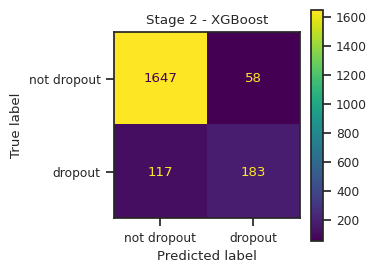

In [ ]:
evaluate_2_val = evaluate_xgb(stage, X_val_2, y_val_2, xgb_config, xgb_model_2, class_labels)

Extracting feature importance from an the best model

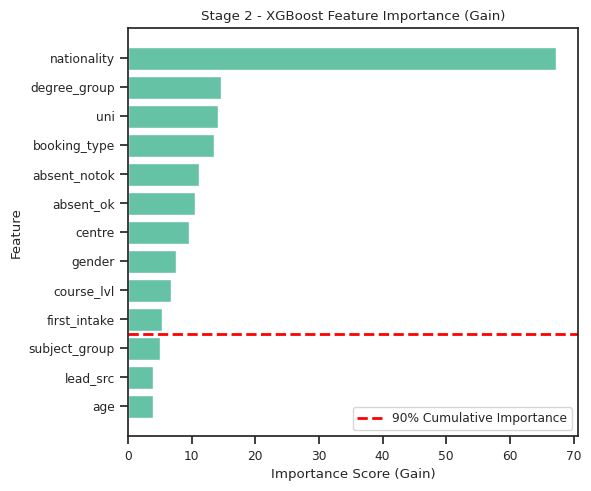

In [ ]:
feature_imp_2 = feature_imp_xgb(stage, xgb_model_2)

In [ ]:
feature_imp_2.sort_values("importance", ascending=False).reset_index(drop=True)

,feature,importance,percentage_imp,cumulative_imp
0,nationality,67.28,38.81,38.81
1,degree_group,14.69,8.47,47.28
2,uni,14.12,8.14,55.42
3,booking_type,13.46,7.76,63.19
4,absent_notok,11.16,6.44,69.63
5,absent_ok,10.52,6.07,75.69
6,centre,9.58,5.53,81.22
7,gender,7.52,4.34,85.56
8,course_lvl,6.76,3.90,89.46
9,first_intake,5.38,3.10,92.56


### 🔹 Insights

- The training metrics are noticeably higher than the validation metrics, suggesting that the model may struggle to generalise well and could be at risk of overfitting.

- With a PR-AUC of 0.52 (well above the baseline of 0.15, the Prevalence) and a ROC-AUC of 0.80 (well above the random model baseline of 0.5), we can conclude that the simple initial XGBoost model performs acceptably, showing no signs of underfitting.

- Since the configuration of the initial models is identical across Stage 1 and Stage 2, we can conclude that the improvement in model performance from Stage 1 (0.46) to Stage 2 (0.52) is solely due to the addition of valuable data. This finding suggests that student engagement data enhances the predictive power of the model.

- The features responsible for 90% of the total predictive gain of the XGBoost model:
  - nationality
  - degree
  - university
  - booking type
  - **unauthorised absence**
  - **authorised absence**
  - centre
  - gender
  - course level
  - first intake  
  Notably, engagement-related features, *unauthorised absence* and *authorised absence* have displaced previously important features from the applicant or course-related data, highlighting their strong predictive power.  
  Most of these features showed a strong association with the dropout outcome during the EDA step.

### hyperparameter tuning

In [ ]:
xgb_tuning_2 = best_xgb_model(stage, seed, X_train_2, y_train_2, X_val_2, y_val_2, nominal_features, xgb_param_grid, xgb_config)

Stage : 2 
Validation PR-AUC: 0.768599615113851 
Validation ROC-AUC: 0.9255777126099707 
Validation Accuracy: 0.913715710723192 
Validation Precision: 0.7725321888412017 
Validation Recall: 0.6 
Validation F1 Score: 0.6754221388367729 

Best hyperparameters:
Max depth: 5
Learning rate: 0.2
Number of estimators: 100



 Saving the best hyperparameters & the best model

In [ ]:
best_xgb_model_2 = xgb_tuning_2["best_xgb_model"]
best_xgb_hp_2 = xgb_tuning_2["best_xgb_hp"]
best_xgb_score_2 = xgb_tuning_2["best_xgb_score"]
best_xgb_config_2 = xgb_tuning_2["best_xgb_config"]
best_xgb_config_2

{'objective': 'binary:logistic',
 'enable_categorical': True,
 'max_depth': 5,
 'learning_rate': 0.2,
 'n_estimators': 100,
 'eval_metric': ['logloss', 'aucpr', 'auc'],
 'scoring': {'accuracy': 'accuracy',
  'precision': 'precision',
  'recall': 'recall',
  'f1': 'f1',
  'roc_auc': 'roc_auc',
  'pr_auc': 'average_precision'},
 'decision_threshold': 0.5,
 'cross_validation': 'custom_split',
 'refit': 'pr_auc'}

Evaluating the model on the test data

Threshold-independent metrics  
Stage 2
pr-auc: 0.5346022891475763 
roc-auc: 0.8064797277259359 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 2
accuracy: 0.9134078212290503 
precision: 0.7383458646616541 
recall: 0.6537949400798935 
f1: 0.693502824858757 



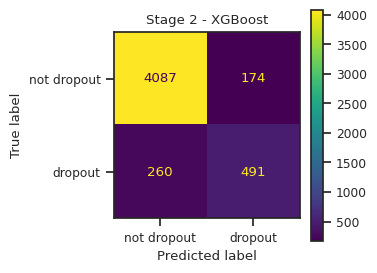

In [ ]:
evaluate_2_test = evaluate_xgb(stage, X_test_2, y_test_2, best_xgb_config_2, best_xgb_model_2, class_labels)

Since we haven't implemented any preventative measures against overfitting, the model may overfit. We should check by comparing the training and validation metrics. If the key metric (PR-AUC) is substantially higher on the training set than on the validation set, it indicates poor generalisation and confirms that the model has overfit by memorising the training data.

If both metrics are low and close to each other, the model is underfitting, meaning it is either too simple or hasn't been trained sufficiently to capture the underlying patterns in the data.

Threshold-independent metrics  
Stage 2
pr-auc: 0.6434001889018928 
roc-auc: 0.8495214587611869 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 2
accuracy: 0.9366478217492518 
precision: 0.8305084745762712 
recall: 0.7251202367739549 
f1: 0.7742445190598459 



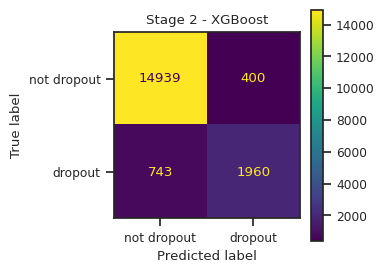

In [ ]:
evaluate_2_train= evaluate_xgb(stage, X_train_2, y_train_2, best_xgb_config_2, best_xgb_model_2, class_labels)

Threshold-independent metrics  
Stage 2
pr-auc: 0.6400294809534867 
roc-auc: 0.839149560117302 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 2
accuracy: 0.9366583541147132 
precision: 0.8502024291497976 
recall: 0.7 
f1: 0.7678244972577697 



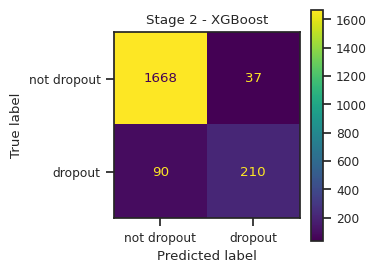

In [ ]:
evaluate_2_val = evaluate_xgb(stage, X_val_2, y_val_2, best_xgb_config_2, best_xgb_model_2, class_labels)

 Extracting feature importance from the best model

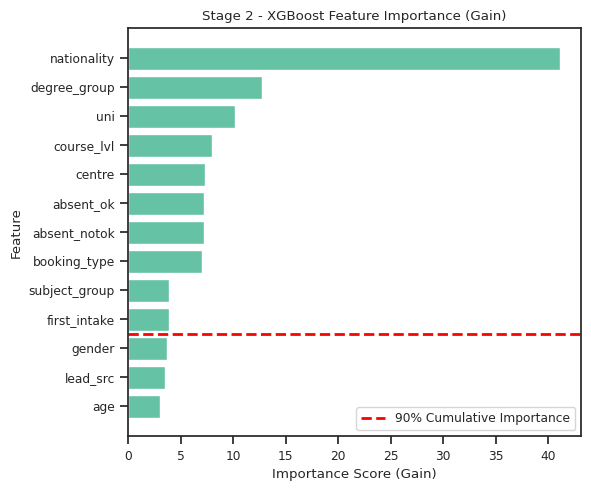

In [ ]:
feature_imp_2 = feature_imp_xgb(stage, best_xgb_model_2)

In [ ]:
feature_imp_2.sort_values("importance", ascending=False).reset_index(drop=True)

,feature,importance,percentage_imp,cumulative_imp
0,nationality,41.10,34.54,34.54
1,degree_group,12.78,10.74,45.28
2,uni,10.15,8.53,53.82
3,course_lvl,7.98,6.71,60.53
4,centre,7.35,6.17,66.70
5,absent_ok,7.24,6.08,72.78
6,absent_notok,7.22,6.07,78.85
7,booking_type,7.02,5.90,84.76
8,subject_group,3.92,3.30,88.06
9,first_intake,3.91,3.28,91.34


### 🔹 Insights

- After hyperparameter tuning, only a slight increase was observed in the key metric (PR-AUC: 0.52 >> 0.53). The remaining metrics exhibited only marginal improvements, if any.

- This minimal improvement is likely because the dataset is not massive, and the relationship between the features and the target variable is not overly complex.  Therefore, even a relatively simple initial model was able to capture the underlying patterns and relationships effectively.


- With a PR-AUC of 0.53 (well above the baseline of 0.15, the Prevalence) and a ROC-AUC of 0.81 (well above the random model baseline of 0.5), we can conclude that the simple initial XGBoost model performs acceptably, showing no signs of underfitting.

- The features responsible for 90% of the total predictive gain of the XGBoost model:
  - nationality
  - degree
  - university
  - course level
  - centre
  - **authorised absence**
  - **unauthorised absence**
  - booking type
  - subject
  - first intake

  Notably, engagement-related features, *authorised absence* and *unauthorised absence* have displaced previously important features from the applicant or course-related data, highlighting their strong predictive power.  
  Most of these features showed a strong association with the dropout outcome during the EDA step.

    
- Although the model's negligible performance improvement may not justify the computational cost of tuning, the hyperparameter optimisation was still beneficial. While the initial model exhibited signs of overfitting, the best-tuned model no longer does, as the training and validation metrics are now closely aligned.

## Stage 3

In [ ]:
stage = 3

###  data pre-process

Pre-processing Stage 3 data and preparing it for the XGBoost modelling

In [ ]:
data_3 = raw_data_3.copy()

In [ ]:
# -------- Stage 3 variables --------

# All numeric features (including ordinal features)
numeric_features_3 = numeric_features_2 + ["pass_rate"]

# Features to be dropped after preprocessing
del_cols_3 = del_cols_2 + ["assessed", "passed", "failed"]

# Newly added features at Stage 3
added_cols_3 = added_cols_2 + ["AssessedModules", "PassedModules", "FailedModules"]

In [ ]:
modelling = "xgboost"

stage3_data = pre_modelling_prep(
    data_3, config,
    stage=stage,
    rename_dict=rename_dict,
    irr_cols=irr_cols,
    missing_cols=missing_cols,
    high_card_cols=high_card_cols,
    ordinal_map=ordinal_map,
    numeric_features=numeric_features_3,
    nominal_features=nominal_features,
    added_cols=added_cols_3,
    del_cols=del_cols_3,
    modelling=modelling)



# Access the results
X_train_3 = stage3_data["X_train"]
X_val_3 = stage3_data["X_val"]
X_test_3 = stage3_data["X_test"]
y_train_3 = stage3_data["y_train"]
y_val_3 = stage3_data["y_val"]
y_test_3 = stage3_data["y_test"]
pipeline_3 = stage3_data["pipeline"]

In [ ]:
print(X_train_3.shape, X_val_3.shape, X_test_3.shape, y_train_3.shape, y_val_3.shape, y_test_3.shape)

(18042, 14) (2005, 14) (5012, 14) (18042,) (2005,) (5012,)


In [ ]:
pipeline_3.named_steps["cleaner"].get_feature_names_out()

array(['centre', 'booking_type', 'lead_src', 'gender', 'nationality',
       'course_lvl', 'first_intake', 'uni', 'absent_ok', 'absent_notok',
       'age', 'subject_group', 'degree_group', 'pass_rate'], dtype='<U13')

In [ ]:
pipeline_3.named_steps["ordinal_encoder"].get_feature_names_out()

array(['centre', 'booking_type', 'lead_src', 'gender', 'nationality',
       'course_lvl', 'first_intake', 'uni', 'absent_ok', 'absent_notok',
       'age', 'subject_group', 'degree_group', 'pass_rate'], dtype='<U13')

### simple initial trial

XGBoost modelling using the initial simple configuration and Stage 3 data

In [ ]:
xgb_model_3 = train_xgb_model(stage, seed, X_train_3, y_train_3, X_val_3, y_val_3, xgb_config)

Evaluating the model on the test data

Threshold-independent metrics  
Stage 3
pr-auc: 0.8720513394808567 
roc-auc: 0.9610020090555939 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 3
accuracy: 0.9784517158818835 
precision: 0.9213630406290957 
recall: 0.9360852197070573 
f1: 0.9286657859973579 



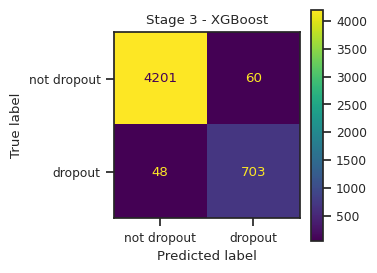

In [ ]:
evaluate_3_test = evaluate_xgb(stage, X_test_3, y_test_3, xgb_config, xgb_model_3, class_labels)

Since we haven't implemented any preventative measures against overfitting, the model may overfit. We should check by comparing the training and validation metrics. If the key metric (PR-AUC) is substantially higher on the training set than on the validation set, it indicates poor generalisation and confirms that the model has overfit by memorising the training data.

If both metrics are low and close to each other, the model is underfitting, meaning it is either too simple or hasn't been trained sufficiently to capture the underlying patterns in the data.

Threshold-independent metrics  
Stage 3
pr-auc: 0.9100477910301747 
roc-auc: 0.970931965330479 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 3
accuracy: 0.9850349185234453 
precision: 0.949390469154045 
recall: 0.9507954125046245 
f1: 0.9500924214417745 



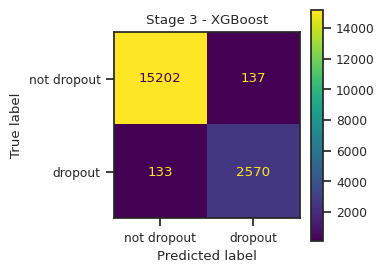

In [ ]:
evaluate_3_train = evaluate_xgb(stage, X_train_3, y_train_3, xgb_config, xgb_model_3, class_labels)

Threshold-independent metrics  
Stage 3
pr-auc: 0.8762494695661778 
roc-auc: 0.949227761485826 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 3
accuracy: 0.9790523690773068 
precision: 0.951048951048951 
recall: 0.9066666666666666 
f1: 0.9283276450511946 



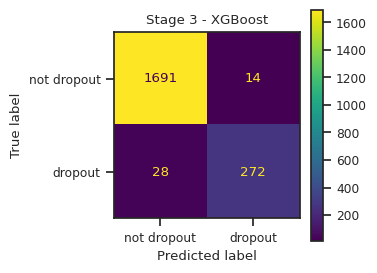

In [ ]:
evaluate_3_val = evaluate_xgb(stage, X_val_3, y_val_3, xgb_config, xgb_model_3, class_labels)

Extracting feature importance from an the best model

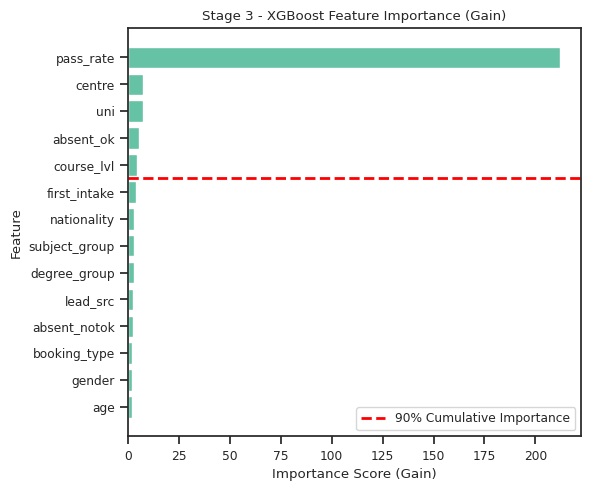

In [ ]:
feature_imp_3 = feature_imp_xgb(stage, xgb_model_3)

In [ ]:
feature_imp_3.sort_values("importance", ascending=False).reset_index(drop=True)

,feature,importance,percentage_imp,cumulative_imp
0,pass_rate,211.92,81.64,81.64
1,centre,7.34,2.83,84.47
2,uni,7.33,2.83,87.30
3,absent_ok,5.30,2.04,89.34
4,course_lvl,4.53,1.74,91.08
5,first_intake,3.85,1.49,92.57
6,nationality,2.99,1.15,93.72
7,subject_group,2.99,1.15,94.87
8,degree_group,2.90,1.12,95.99
9,lead_src,2.34,0.90,96.89


### 🔹 Insights

- Since the training and validation metrics are close (with the training metric still slightly higher, which is normal), we can conclude that the model is generalising well and there is no sign of overfitting.

- With a PR-AUC of 0.87 (well above the baseline of 0.15, the Prevalence) and a ROC-AUC of 0.96 (well above the random model baseline of 0.5), we can conclude that the simple initial XGBoost model performs very well, showing no signs of underfitting.

- Since the configuration of the initial models is identical across Stage 2 and Stage 3, we can conclude that the improvement in model performance from Stage 2 (0.52) to Stage 3 (0.87) is solely due to the addition of valuable data. This finding suggests that academic performance data enhances the predictive power of the model.

- The features responsible for 90% of the total predictive gain of the XGBoost model:
  - **pass rate**
  - centre
  - university
  - authorised absence
  - course level  
  Notably, the performance-related feature, *pass rate*, has displaced previously important features from Stage 2, highlighting its strong predictive power. However, the large importance gap between *pass rate* (211.92) and the next feature (*centre*, 7.34) indicates that the model is heavily dependent on this single academic metric and  this marginalises other features. This dominance may contribute to the high final performance, but it also introduces a significant risk: the model's performance could collapse if *pass rate* data becomes unavailable. Additionally, this reliance may mask smaller but still meaningful signals from early indicators (like *nationality* or *unauthorised absence*), which can be critical for timely intervention.   
  All of these features showed a strong association with the dropout outcome during the EDA step.

### hyperparameter tuning

In [ ]:
xgb_tuning_3 = best_xgb_model(stage, seed, X_train_3, y_train_3, X_val_3, y_val_3, nominal_features, xgb_param_grid, xgb_config)

Stage : 3 
Validation PR-AUC: 0.9858386966758446 
Validation ROC-AUC: 0.9971769305962855 
Validation Accuracy: 0.9790523690773068 
Validation Precision: 0.9479166666666666 
Validation Recall: 0.91 
Validation F1 Score: 0.9285714285714286 

Best hyperparameters:
Max depth: 7
Learning rate: 0.05
Number of estimators: 300



 Saving the best hyperparameters & the best model

In [ ]:
best_xgb_model_3 = xgb_tuning_3["best_xgb_model"]
best_xgb_hp_3 = xgb_tuning_3["best_xgb_hp"]
best_xgb_score_3 = xgb_tuning_3["best_xgb_score"]
best_xgb_config_3 = xgb_tuning_3["best_xgb_config"]
best_xgb_config_3

{'objective': 'binary:logistic',
 'enable_categorical': True,
 'max_depth': 7,
 'learning_rate': 0.05,
 'n_estimators': 300,
 'eval_metric': ['logloss', 'aucpr', 'auc'],
 'scoring': {'accuracy': 'accuracy',
  'precision': 'precision',
  'recall': 'recall',
  'f1': 'f1',
  'roc_auc': 'roc_auc',
  'pr_auc': 'average_precision'},
 'decision_threshold': 0.5,
 'cross_validation': 'custom_split',
 'refit': 'pr_auc'}

Evaluating the model on the test data

Threshold-independent metrics  
Stage 3
pr-auc: 0.8664743477615551 
roc-auc: 0.9554793717896595 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 3
accuracy: 0.9774541101356744 
precision: 0.9253333333333333 
recall: 0.9241011984021305 
f1: 0.9247168554297135 



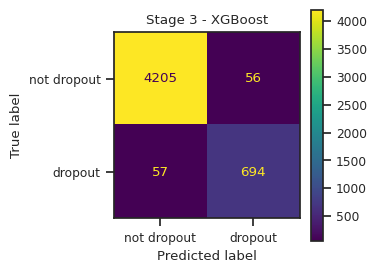

In [ ]:
evaluate_3_test = evaluate_xgb(stage, X_test_3, y_test_3, best_xgb_config_3, best_xgb_model_3, class_labels)

Since we haven't implemented any preventative measures against overfitting, the model may overfit. We should check by comparing the training and validation metrics. If the key metric (PR-AUC) is substantially higher on the training set than on the validation set, it indicates poor generalisation and confirms that the model has overfit by memorising the training data.

If both metrics are low and close to each other, the model is underfitting, meaning it is either too simple or hasn't been trained sufficiently to capture the underlying patterns in the data.

Threshold-independent metrics  
Stage 3
pr-auc: 0.964070571681607 
roc-auc: 0.9914289263893862 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 3
accuracy: 0.9942356723201419 
precision: 0.9744432274552757 
recall: 0.9874213836477987 
f1: 0.9808893789048144 



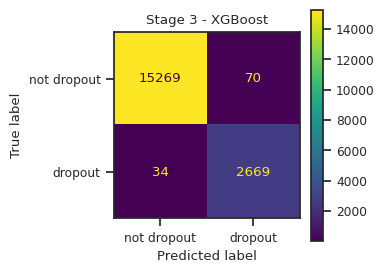

In [ ]:
evaluate_3_train= evaluate_xgb(stage, X_train_3, y_train_3, best_xgb_config_3, best_xgb_model_3, class_labels)

Threshold-independent metrics  
Stage 3
pr-auc: 0.9698381562871345 
roc-auc: 0.9888269794721408 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 3
accuracy: 0.9950124688279302 
precision: 0.9865771812080537 
recall: 0.98 
f1: 0.9832775919732442 



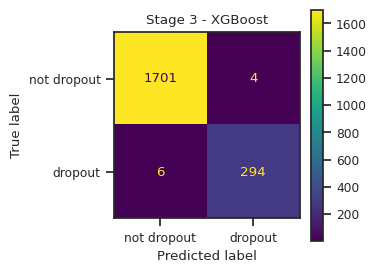

In [ ]:
evaluate_3_val = evaluate_xgb(stage, X_val_3, y_val_3, best_xgb_config_3, best_xgb_model_3, class_labels)

 Extracting feature importance from the best model

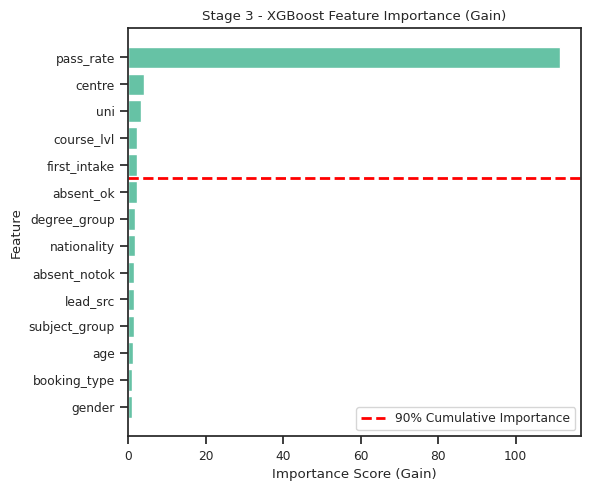

In [ ]:
feature_imp_3 = feature_imp_xgb(stage, best_xgb_model_3)

In [ ]:
feature_imp_3.sort_values("importance", ascending=False).reset_index(drop=True)

,feature,importance,percentage_imp,cumulative_imp
0,pass_rate,111.36,81.19,81.19
1,centre,4.19,3.06,84.24
2,uni,3.46,2.52,86.77
3,course_lvl,2.34,1.71,88.47
4,first_intake,2.23,1.63,90.10
5,absent_ok,2.23,1.63,91.73
6,degree_group,1.83,1.33,93.06
7,nationality,1.71,1.25,94.31
8,absent_notok,1.51,1.10,95.41
9,lead_src,1.47,1.07,96.49


### 🔹 Insights

- After hyperparameter tuning, no improvement was observed in the key metric (PR-AUC: 0.87 = 0.87). The remaining metrics also showed no improvement, except a slight decrease in recall and f1 score and a slight increase in precision.

- This minimal improvement is likely because the dataset is not massive, and the relationship between the features and the target variable is not overly complex.  Therefore, even a relatively simple initial model was able to capture the underlying patterns and relationships effectively.

- Since the training and validation metrics are close (with the training metric still slightly higher, which is normal), we can conclude that the model is generalising well and there is no sign of overfitting.

- With a PR-AUC of 0.97 (well above the baseline of 0.15, the Prevalence) and a ROC-AUC of 0.96 (well above the random model baseline of 0.5), we can conclude that the simple initial XGBoost model performs well, showing no signs of underfitting.

- The features responsible for 90% of the total predictive gain of the XGBoost model:
  - **pass rate**
  - centre
  - university
  - authorised absence
  - course level
  - first intake  
  Notably, the performance-related feature, *pass rate*, has displaced previously important features from Stage 2, highlighting its strong predictive power. However, the large importance gap between *pass rate* (211.92) and the next feature (*centre*, 7.34) indicates that the model is heavily dependent on this single academic metric and  this marginalises other features. This dominance may contribute to the high final performance, but it also introduces a significant risk: the model's performance could collapse if *pass rate* data becomes unavailable. Additionally, this reliance may mask smaller but still meaningful signals from early indicators (like *nationality* or *unauthorised absence*), which can be critical for timely intervention.   
  All of these features showed a strong association with the dropout outcome during the EDA step.

    
- The hyperparameter tuning's failure in both improving the model performance and improving the distribution of the features' importance cannot justify the computational cost of tuning. The best model still heaviliy relies on the single dominant feature (*pass rate*). This makes the model  volnurable to potential data unavailability.


- Overall, across all stages, the tuning provided only marginal improvements for XGBoost, less pronounced than for the Neural Networks. This aligns with XGBoost's strength in handling imbalanced, medium-sized tabular data.

## Comparing Stage 1, 2, 3

Performance results of the initial model for each Stage

Threshold-independent metrics  
Stage 1
pr-auc: 0.46396757548571327 
roc-auc: 0.7697878226043599 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 1
accuracy: 0.8976456504389465 
precision: 0.6847826086956522 
recall: 0.5872170439414115 
f1: 0.632258064516129 

Threshold-independent metrics  
Stage 2
pr-auc: 0.5221318986246923 
roc-auc: 0.7984903801893182 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 2
accuracy: 0.9110135674381484 
precision: 0.7335375191424196 
recall: 0.6378162450066578 
f1: 0.6823361823361823 

Threshold-independent metrics  
Stage 3
pr-auc: 0.8720513394808567 
roc-auc: 0.9610020090555939 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 3
accuracy: 0.9784517158818835 
precision: 0.9213630406290957 
recall: 0.9360852197070573 
f1: 0.9286657859973579 



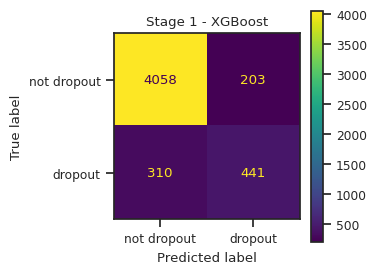

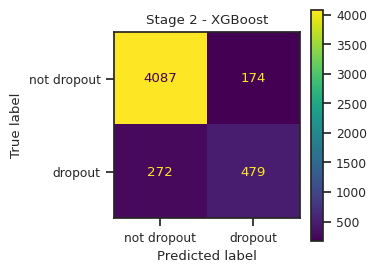

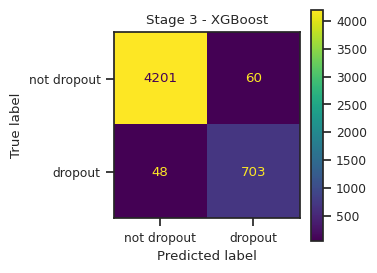

In [ ]:
n_stages = 3
modelling = "xgboost"
X_tests = [X_test_1, X_test_2, X_test_3]
y_tests = [y_test_1, y_test_2, y_test_3]
xgb_models = [xgb_model_1, xgb_model_2, xgb_model_3]
xgb_configs = [xgb_config, xgb_config, xgb_config]

all_initial_results_xgb = all_stages(n_stages, X_tests, y_tests, xgb_configs, xgb_models, class_labels, modelling)

In [ ]:
pd.DataFrame(all_initial_results_xgb)

,evaluate_1,evaluate_2,evaluate_3
pr_auc_score,0.46,0.52,0.87
roc_auc_score,0.77,0.80,0.96
accuracy_score,0.90,0.91,0.98
precision_score,0.68,0.73,0.92
recall_score,0.59,0.64,0.94
f1_score,0.63,0.68,0.93


### 🔹 Insights (initial models)

Since the configuration of the initial models is identical across all Stages, we can conclude that the improvement in model performance from Stage 1 to Stage 3 is solely due to the addition of valuable data.

- The addition of student engagement improved the model's PR-AUC by 13%. It increased Precision by 7.4% and Recall by 8.5%.  
Including academic performance further improved PR-AUC by 67.3%, Precision by 26%, and Recall by 46.9%, reflecting its strength in predicting true dropout cases successfully.

- These findings indicate that both academic performance and student engagement serve as influential distinguishing factors, contributing predictive value beyond demographic and course-related features.



- As expected, Accuracy of all Stages is relatively high providing an inflated estimate of the model's actual performance.

Performance results of the best model for each Stage

Threshold-independent metrics  
Stage 1
pr-auc: 0.4754718235613563 
roc-auc: 0.7786393546772182 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 1
accuracy: 0.8996408619313647 
precision: 0.6873111782477341 
recall: 0.6058588548601864 
f1: 0.6440198159943383 

Threshold-independent metrics  
Stage 2
pr-auc: 0.5346022891475763 
roc-auc: 0.8064797277259359 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 2
accuracy: 0.9134078212290503 
precision: 0.7383458646616541 
recall: 0.6537949400798935 
f1: 0.693502824858757 

Threshold-independent metrics  
Stage 3
pr-auc: 0.8664743477615551 
roc-auc: 0.9554793717896595 

Threshold-dependent metrics (desision threshold: 0.5) 
Stage 3
accuracy: 0.9774541101356744 
precision: 0.9253333333333333 
recall: 0.9241011984021305 
f1: 0.9247168554297135 



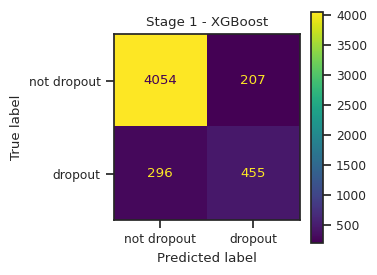

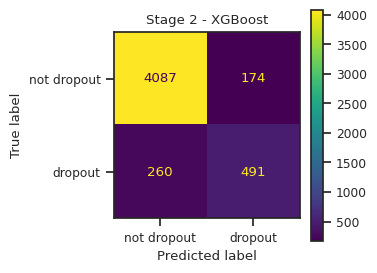

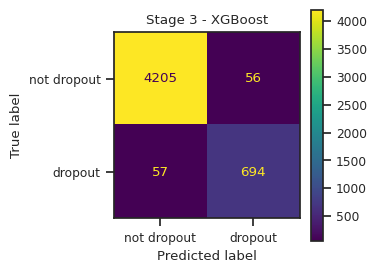

In [ ]:
n_stages = 3
modelling = "xgboost"
X_tests = [X_test_1, X_test_2, X_test_3]
y_tests = [y_test_1, y_test_2, y_test_3]
best_xgb_models = [best_xgb_model_1, best_xgb_model_2, best_xgb_model_3]
best_xgb_configs = [best_xgb_config_1, best_xgb_config_2, best_xgb_config_3]

all_best_results_xgb = all_stages(n_stages, X_tests, y_tests, best_xgb_configs, best_xgb_models, class_labels, modelling)

In [ ]:
pd.DataFrame(all_best_results_xgb)

,evaluate_1,evaluate_2,evaluate_3
pr_auc_score,0.48,0.53,0.87
roc_auc_score,0.78,0.81,0.96
accuracy_score,0.90,0.91,0.98
precision_score,0.69,0.74,0.93
recall_score,0.61,0.65,0.92
f1_score,0.64,0.69,0.92


### 🔹 Insights (best models)

- Since the configuration of the best models for each Stage is different, we cannot conclude that the improvement in tuned model performance from Stage 1 to Stage 3 is solely due to the addition of valuable data. However, assuming that the tuning process was effective enough to extract nearly all the signal available within each Stage's data, it is still valid to compare them, especially since the pattern of improvement is consistent with the initial models:

- The addition of student engagement improved the model's PR-AUC by 10.4%. It increased Precision by 7.2% and Recall by 6.6%.  
Including academic performance further improved PR-AUC by 64.2%, Precision by 25.7%, and Recall by 41.5%, reflecting its strength in predicting true dropout cases successfully.

- These findings are consistent with the initial simple models, both demonstrating that academic performance data adds more predictive value than student engagement data.


- Overal, the Stage 3 model outperforms all others and delivers the best overall result (catching the most dropouts)
  - The model is robust at separating the small dropout class from the large non-dropout class (PR-AUC: 0.87).
  - 93% of the times the detected dropout case is correctly detected (Precision: 0.93).
  - It is able to detect 92% of all actual dropout cases (Recall: 0.92).
  - With F1 score of 0.92 sitting between Precision (0.93) and Recall (0.92), the model offers a highly powerful and balanced model.


- As expected, Accuracy of all Stages is relatively high providing an inflated estimate of the model's actual performance.



# 🔷 Conclusions
Overall, academic performance is the primary and most influential predictor, though engagement-related data also offers strong predictive value, particularly when academic performance information is unavailable. The lower PR-AUC at Stage 1, compared with the later stages, reflects the limited effectiveness of application data on its own for identifying learners at risk.

At Stage 1, the model depends only on application data, which are weak predictors of dropout and often linked to sensitive characteristics like nationality, gender, or socioeconomic background. Therefore, the model is more exposed to biased patterns and uneven errors across different groups. This means we need error analysis and fairness checks to make sure early interventions don't consistently miss or misclassify certain learners. This helps maintain fairness and stops the model from repeating existing structural inequalities in the learner population. Also, a large high-risk group with missing degree information is evident, raising the need for further investigation, as it may reflect hidden structures or missing-not-at-random patterns.

For student dropout prediction on a highly imbalanced dataset, we recommend an ensemble approach: NNs for Stage 1 and Stage 2, and XGBoost for Stage 3. NNs seem to handle the complex, non-linear interactions of application and engagement-related data better at the early stages, when the strong academic signal is not yet available. They achieve stable and balanced predictions early on (Stage 1 PR-AUC: 0.67, Stage 2 PR-AUC: 0.75). At Stage 3, XGBoost clearly performs best (PR-AUC: 0.87, ROC-AUC: 0.96, Precision: 0.93, Recall: 0.92, F1: 0.92), showing that it responds most effectively to academic performance data for final high-confidence intervention decisions.


This strategy naturally supports a two-phase intervention system based on the trade-off between timing and impact. The staged approach also prevents less prominent yet meaningful features, such as course level, degree, centre, university, subject, nationality, and engagement-related features from being masked by the overwhelming predictive power of academic performance data.


1. Early, low-cost, proactive interventions, like check-ins or alerts can be started as soon as engagement signals become available at Stage 2. This point gives the largest early jump in predictive power (+12.6% PR-AUC).
2. More resource-intensive interventions like tutoring or counselling can be offered to learners flagged at Stage 3, when academic performance data becomes available. XGBoost's strong class separation at this stage helps confidently identify learners with high risk of dropout.

The current decision threshold of 0.5 treats Precision and Recall as equally important. This should be reviewed with stakeholders and, if necessary, adjusted to reflect available resources and the trade-off between incorrectly flagged cases and overlooked dropout cases.

One important limitation is that XGBoost becomes extremely dependent on a single predictor at Stage 3. Pass rate, with an importance of 81.2%, dominates the model, leaving the model vulnerable to missing or unreliable data.

To reduce the black box problem of NN and XGBoost models, explainability tools such as SHAP are necessary to support the decision-making process and to maintain transparency.

# References

Data provided by **********.

Clevert, D.-A., Unterthiner, T. and Hochreiter, S. (2016) Fast and accurate deep network learning by exponential linear units (elus), arXiv.org. Available at: https://arxiv.org/abs/1511.07289 (Accessed: 16 November 2025).

Davis, J. and Goadrich, M. (2006) ‘The relationship between precision-recall and ROC curves’, Proceedings of the 23rd international conference on Machine learning  - ICML ’06, pp. 233–240. doi:10.1145/1143844.1143874.

Grinsztajn, L., Oyallon, E. and Varoquaux, G. (2022). ‘Why do tree-based models still outperform deep learning on tabular data?’, 36th Conference on Neural Information Processing Systems (NeurIPS 2022), doi:https://doi.org/10.48550/arXiv.2207.08815.

Rebelo Marcolino, M., Reis Porto, T., Thompsen Primo, T., Targino, R., Ramos, V., Marques Queiroga, E., Munoz, R. and Cechinel, C. (2025). ‘Student dropout prediction through machine learning optimization: insights from moodle log data’, Scientific reports, [online] 15(1), p.9840. doi:https://doi.org/10.1038/s41598-025-93918-1.


# Declaration
By submitting your project, you indicate that the work is your own and has been created with academic integrity. Refer to the **Cambridge plagiarism regulations**.
